In [1]:
from Datageneration import User,CallGenerator,CallSimulator
from nonpredictor import NonPredictiveCallAdmissionController
from predictor import PredictiveCallAdmissionController, AdmissionMetrics,RAT_CAPACITIES,RATPool,RATState,RB_PER_SERVICE
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Dict, Optional, Tuple, List, Literal
from collections import Counter, defaultdict
from datetime import datetime, timedelta
import heapq
import pandas as pd
import numpy as np
from math import exp, log, sin, cos, pi
from datetime import datetime, timedelta
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from nn import CallDurationPredictor


Duration stats (seconds):
count    89397.000000
mean       282.088609
std        132.450642
min         38.306221
25%        185.249219
50%        248.182955
75%        350.468256
max       1310.803056
Name: duration_sec, dtype: float64

Median call duration: 248 seconds
Median call duration: 4.1 minutes
Median call duration: 4 minutes 8 seconds

Weibull Distribution Parameters:
Shape parameter (k): 2.261
Scale parameter (λ): 5.327 minutes


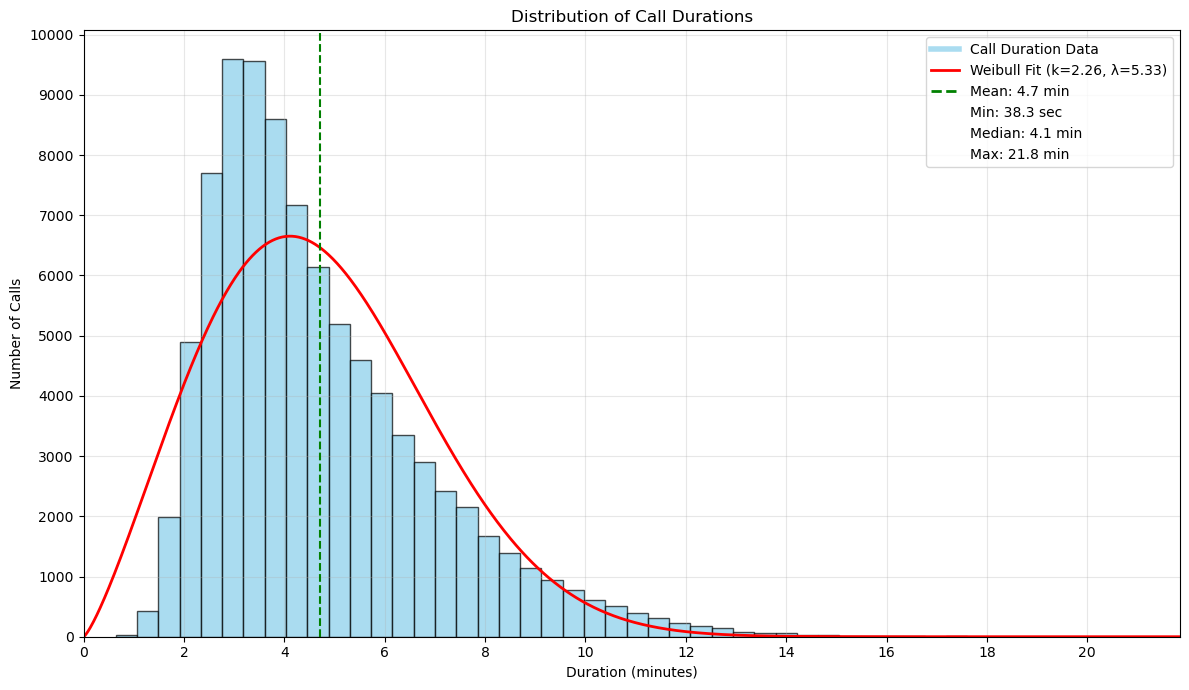


Weibull Distribution Insights:
Mean from Weibull: 4.72 minutes
Variance: 4.88


In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import gamma  # Import gamma function
df = pd.read_csv("data.csv")
# Inspect basic stats
print("Duration stats (seconds):")
print(df["duration_sec"].describe())

# Get median in seconds
median_seconds = df['duration_sec'].median()
print(f"\nMedian call duration: {median_seconds:.0f} seconds")

# Convert to minutes for easier interpretation
median_minutes = median_seconds / 60
print(f"Median call duration: {median_minutes:.1f} minutes")

# Or more precisely:
minutes = int(median_seconds // 60)
seconds = int(median_seconds % 60)
print(f"Median call duration: {minutes} minutes {seconds} seconds")

# Fit Weibull distribution to the data
data = df['duration_sec'].values / 60  # Convert to minutes
shape, loc, scale = stats.weibull_min.fit(data, floc=0)  # Fit with location=0

print(f"\nWeibull Distribution Parameters:")
print(f"Shape parameter (k): {shape:.3f}")
print(f"Scale parameter (λ): {scale:.3f} minutes")

# Calculate statistics for legend
min_duration = np.min(data)*60
max_duration = np.max(data)
median_duration = np.median(data)
mean_duration = np.mean(data)

# Create standalone figure
plt.figure(figsize=(12, 7))

# Plot histogram with 2-minute bins (FREQUENCY, not density)
n, bins, patches = plt.hist(data, bins=50, alpha=0.7, edgecolor='black', 
                           color='skyblue', density=False, label='Call Duration Data')

# Customize x-axis with 2-minute intervals
max_duration = np.max(data)
x_ticks = np.arange(0, max_duration + 2, 2)
plt.xticks(x_ticks)

# Create smooth curve for Weibull distribution (scaled to frequency)
x = np.linspace(0, max_duration, 1000)
weibull_pdf = stats.weibull_min.pdf(x, shape, loc=0, scale=scale)
# Scale the PDF to match frequency counts
bin_width = bins[1] - bins[0]
total_count = len(data)
weibull_scaled = weibull_pdf * total_count * bin_width

plt.plot(x, weibull_scaled, 'r-', linewidth=2, 
         label=f'Weibull Fit (k={shape:.2f}, λ={scale:.2f})')

# Add mean line (only mean as vertical line)
plt.axvline(mean_duration, color='green', linestyle='--', 
           label=f'Mean: {mean_duration:.1f} min')

# Customize y-axis with 1000 intervals
current_y_lim = plt.gca().get_ylim()
y_ticks = np.arange(0, current_y_lim[1] + 1000, 1000)
plt.yticks(y_ticks)

# FIX THE SPACE: Set axis limits to start exactly at 0
plt.xlim(0, max_duration)  # X-axis from 0 to max duration
plt.ylim(0, current_y_lim[1])  # Y-axis from 0 to current max

plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Calls')
plt.title('Distribution of Call Durations')

# Create custom legend entries for min, max, median (no lines on plot)
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='skyblue', alpha=0.7, lw=4),  # For histogram
    Line2D([0], [0], color='red', lw=2),              # For Weibull curve
    Line2D([0], [0], color='green', linestyle='--', lw=2),  # For mean line
    Line2D([0], [0], color='white', lw=0),            # Empty for min
    Line2D([0], [0], color='white', lw=0),            # Empty for median  
    Line2D([0], [0], color='white', lw=0)             # Empty for max
]

labels = [
    'Call Duration Data',
    f'Weibull Fit (k={shape:.2f}, λ={scale:.2f})',
    f'Mean: {mean_duration:.1f} min',
    f'Min: {min_duration:.1f} sec',
    f'Median: {median_duration:.1f} min', 
    f'Max: {max_duration:.1f} min'
]

plt.legend(custom_lines, labels, loc='best')
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# Additional Weibull insights
print(f"\nWeibull Distribution Insights:")
print(f"Mean from Weibull: {scale * gamma(1 + 1/shape):.2f} minutes")
print(f"Variance: {(scale**2) * (gamma(1 + 2/shape) - (gamma(1 + 1/shape))**2):.2f}")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load your data
df = pd.read_csv("data.csv")

# Pick first 2, middle 2, and last 2 rows
first_rows = df.head(2)
mid = len(df) // 2
middle_rows = df.iloc[mid-4:mid+3]  # Get 2 middle rows
last_rows = df.tail(2)

# Combine all samples
subset = pd.concat([first_rows, middle_rows, last_rows])

# Display as a nice table
print("SAMPLE CALL RECORDS (First 2, Middle 2, Last 2)")
print("=" * 55)
display(subset)

# Count calls in different duration ranges
bins = [0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, float('inf')]
labels = ['0-1 min', '1-2 min', '2-3 min', '3-4 min', '4-5 min', '5-6 min', '6-7 min', '7-8 min', 
          '8-9 min', '9-10 min', '10-11 min', '11-12 min', '12-13 min', '13-14 min', '14-15 min', '15+ min']

# Create the binned categories
df['duration_category'] = pd.cut(df['duration_sec'], bins=bins, labels=labels, right=False)

# Count calls in each category
duration_counts = df['duration_category'].value_counts().sort_index()

print("\nCall Duration Distribution:")
print("=" * 40)
for category, count in duration_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{category}: {count:,} calls ({percentage:.1f}%)")

# Also show the total for verification
print(f"\nTotal calls: {len(df):,}")

SAMPLE CALL RECORDS (First 2, Middle 2, Last 2)


,caller_id,callee_id,timestamp,service_type,relationship_score,caller_location,callee_location,past_avg_duration,pair_call_count,time_since_last_call_hours,duration_sec
0,10,45,2025-01-01 00:22:32,voice,1.1,home,campus,0.000000,1,NaN,248.837576
1,24,69,2025-01-01 00:30:55,voice,1.2,home,home,0.000000,1,NaN,384.593257
44694,73,98,2025-04-16 18:02:10,video,0.4,campus,work,49.283773,6,174.280000,43.501511
44695,6,1,2025-04-16 18:08:23,voice,0.6,campus,other_outdoor,88.398029,12,489.342500,76.443275
44696,80,74,2025-04-16 18:17:10,video,0.8,work,home,140.954825,27,47.708611,149.099096
44697,38,7,2025-04-16 18:17:57,voice,0.8,inTransit,home,163.923741,18,44.697778,126.674551
44698,49,20,2025-04-16 18:21:25,voice,1.3,home,home,444.337816,36,19.433333,583.675207
44699,66,64,2025-04-16 18:22:18,voice,1.1,campus,inTransit,486.946249,21,70.816389,278.599412
44700,100,94,2025-04-16 18:26:21,video,1.0,inTransit,home,277.486134,23,166.199722,207.349215
89395,5,29,2025-07-30 23:39:12,voice,1.1,work,inTransit,307.724105,56,48.646389,129.707686



Call Duration Distribution:
0-1 min: 938 calls (1.0%)
1-2 min: 6,858 calls (7.7%)
2-3 min: 11,621 calls (13.0%)
3-4 min: 12,620 calls (14.1%)
4-5 min: 11,286 calls (12.6%)
5-6 min: 9,006 calls (10.1%)
6-7 min: 7,520 calls (8.4%)
7-8 min: 6,054 calls (6.8%)
8-9 min: 4,587 calls (5.1%)
9-10 min: 3,813 calls (4.3%)
10-11 min: 2,869 calls (3.2%)
11-12 min: 2,309 calls (2.6%)
12-13 min: 1,802 calls (2.0%)
13-14 min: 1,467 calls (1.6%)
14-15 min: 1,212 calls (1.4%)
15+ min: 5,435 calls (6.1%)

Total calls: 89,397


In [4]:
def create_comprehensive_table(data):
    """Create a concise comprehensive table with key metrics"""
    
    data_minutes = data / 60
    
    comprehensive_data = {
        'Metric': [
            'Total Calls',
            'Mean Duration',
            'Median Duration',
            'Minimum Duration',
            'Maximum Duration',
            '25th Percentile (Q1)',
            '75th Percentile (Q3)',
            'Standard Deviation'
        ],
        'Value': [
            f"{len(data_minutes):,}",
            f"{np.mean(data_minutes):.2f} min",
            f"{np.percentile(data_minutes, 50):.2f} min",
            f"{np.min(data_minutes):.2f} min",
            f"{np.max(data_minutes):.2f} min",
            f"{np.percentile(data_minutes, 25):.2f} min",
            f"{np.percentile(data_minutes, 75):.2f} min",
            f"{np.std(data_minutes):.2f} min"
        ]
    }
    
    comprehensive_table = pd.DataFrame(comprehensive_data)
    
    print("KEY CALL DURATION STATISTICS")
    print("=" * 50)
    display(comprehensive_table)
    
    return comprehensive_table

# Usage for single table
comprehensive_table = create_comprehensive_table(df['duration_sec'])

KEY CALL DURATION STATISTICS


,Metric,Value
0,Total Calls,"89,397"
1,Mean Duration,6.51 min
2,Median Duration,5.14 min
3,Minimum Duration,0.60 min
4,Maximum Duration,61.30 min
5,25th Percentile (Q1),3.23 min
6,75th Percentile (Q3),8.21 min
7,Standard Deviation,4.93 min


Model and metrics loaded successfully!


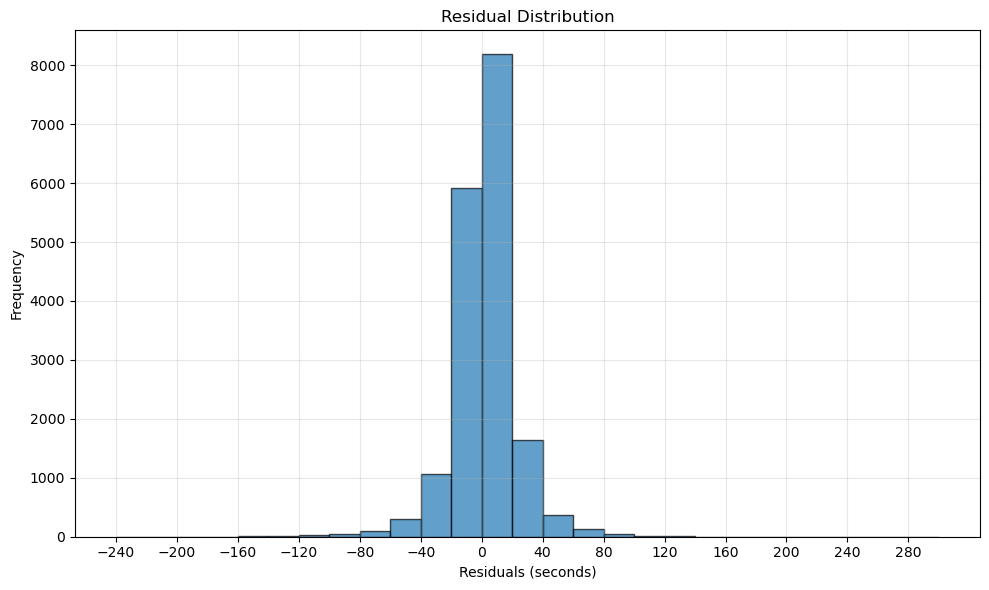

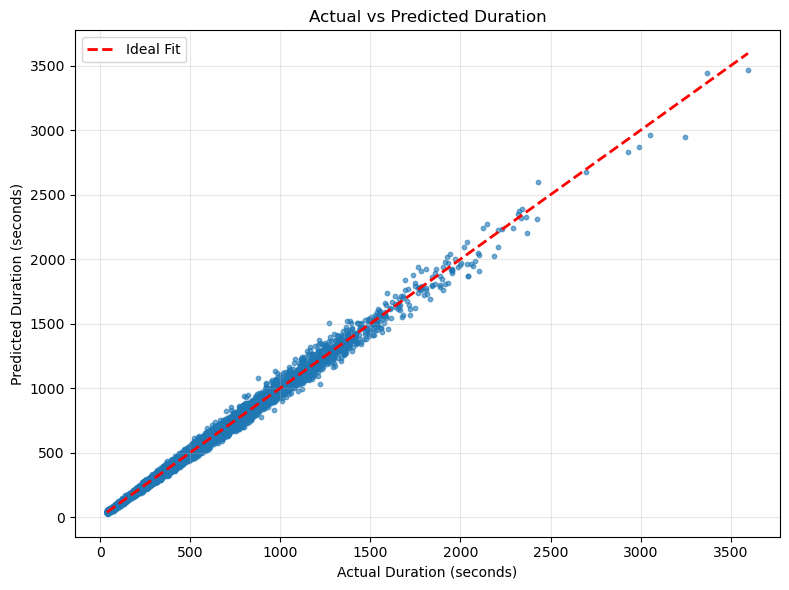

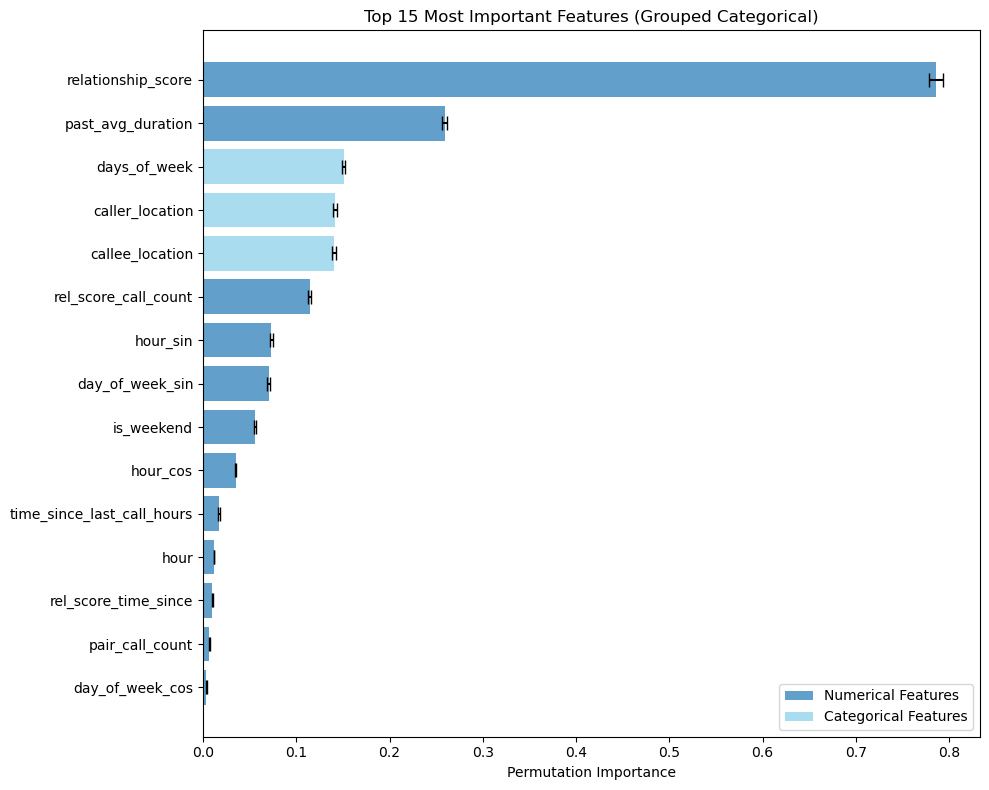


FEATURE IMPORTANCE SUMMARY:
relationship_score          0.7859 (Numerical)
past_avg_duration           0.2589 (Numerical)
days_of_week                0.1507 (Categorical)
caller_location             0.1415 (Categorical)
callee_location             0.1407 (Categorical)
rel_score_call_count        0.1143 (Numerical)
hour_sin                    0.0732 (Numerical)
day_of_week_sin             0.0703 (Numerical)
is_weekend                  0.0559 (Numerical)
hour_cos                    0.0351 (Numerical)
time_since_last_call_hours   0.0171 (Numerical)
hour                        0.0121 (Numerical)
rel_score_time_since        0.0100 (Numerical)
pair_call_count             0.0070 (Numerical)
day_of_week_cos             0.0037 (Numerical)


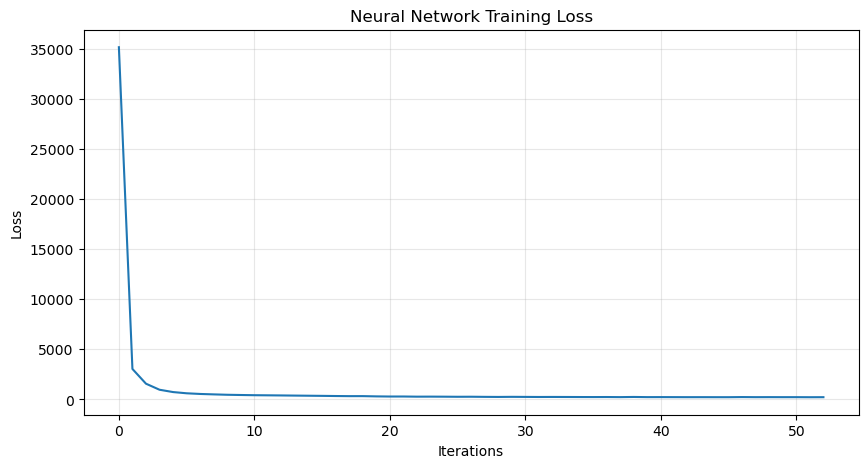

Final training loss: 224.3946
Training metrics: {'r2': 0.9951732580441874, 'rmse': 20.612624589493137, 'mae': 13.527214809806472, 'mse': 424.8802924673771}
Test metrics: {'r2': 0.9944715344267018, 'rmse': 21.616182022919066, 'mae': 14.007429614565106, 'mse': 467.25932524796934}


In [4]:
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
with open('trained_predictor.pkl', 'rb') as f:
    predictor = pickle.load(f)

# Load the metrics
with open('training_metrics.json', 'r') as f:
    metrics = json.load(f)

print("Model and metrics loaded successfully!")

# Now you can create plots without retraining
predictor.plot_residuals()
plt.show()

predictor.plot_feature_importance() 
plt.show()

predictor.plot_training_history()
plt.show()

# You can also access the metrics
print("Training metrics:", metrics['train_metrics'])
print("Test metrics:", metrics['test_metrics'])

Parallel Simulation Results:
   arrival_rate_per_second  predictive_blocking_prob  \
0                      0.1                  0.000000   
1                      1.0                  0.357378   
2                      2.0                  0.555099   
3                      3.0                  0.703564   
4                      4.0                  0.776955   
5                      5.0                  0.819690   

   nonpredictive_blocking_prob  
0                     0.000000  
1                     0.334066  
2                     0.554988  
3                     0.701793  
4                     0.774466  
5                     0.819645  
   arrival_rate_per_second  predictive_handoffs  nonpredictive_handoffs
0                      0.1                    0                     212
1                      1.0                  622                    1117
2                      2.0                 1316                    1373
3                      3.0                 1251            

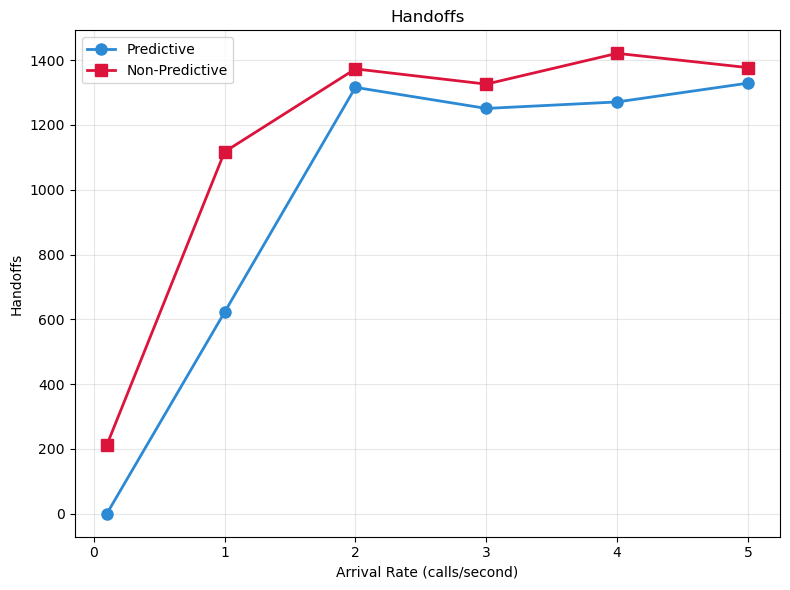

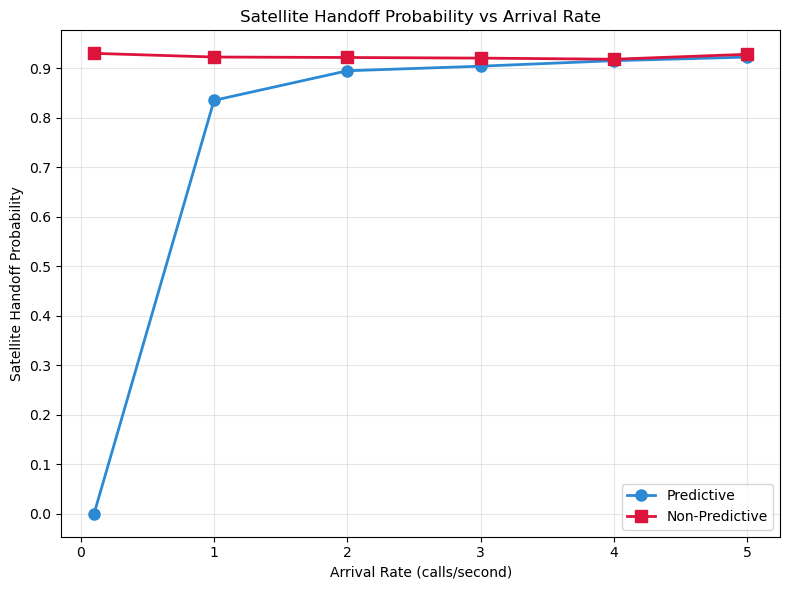

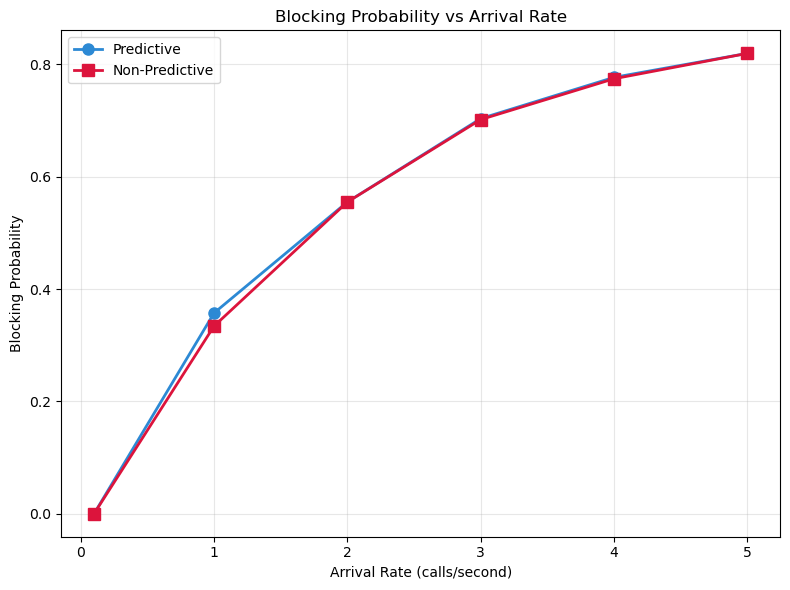

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the parallel results
with open('arrival_rate_resultsmainupdated.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("Parallel Simulation Results:")
print(df_results[['arrival_rate_per_second', 'predictive_blocking_prob', 'nonpredictive_blocking_prob']])
print(df_results[['arrival_rate_per_second', 'predictive_handoffs', 'nonpredictive_handoffs']])
print(df_results[['arrival_rate_per_second', 'predictive_handoff_prob', 'nonpredictive_handoff_prob_']])

# Set custom colors
PREDICTIVE_COLOR = '#2C89D4'      # or '#1f77b4' for specific #2C89D4
NON_PREDICTIVE_COLOR = '#DC143C'   # or '#d62728' for specific red

# Plot 1: Handoffs
plt.figure(figsize=(8, 6))
plt.plot(df_results['arrival_rate_per_second'], df_results['predictive_handoffs'], 
         'o-', color=PREDICTIVE_COLOR, label='Predictive', linewidth=2, markersize=8)
plt.plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoffs'], 
         's-', color=NON_PREDICTIVE_COLOR, label='Non-Predictive', linewidth=2, markersize=8)
plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('Handoffs')
plt.title('Handoffs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Satellite Handoff Probability
# Plot 2: Satellite Handoff Probability
plt.figure(figsize=(8, 6))
plt.plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_prob'], 
         'o-', color=PREDICTIVE_COLOR, label='Predictive', linewidth=2, markersize=8)
plt.plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_prob_'], 
         's-', color=NON_PREDICTIVE_COLOR, label='Non-Predictive', linewidth=2, markersize=8)
plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('Satellite Handoff Probability')
plt.title('Satellite Handoff Probability vs Arrival Rate')
plt.legend()
plt.grid(True, alpha=0.3)

# Set y-axis ticks with 0.1 increments
plt.yticks(np.arange(0, 1, 0.1))  # From 0 to 1.0 in 0.1 steps
plt.tight_layout()
plt.show()

# Plot 3: Blocking Probability
plt.figure(figsize=(8, 6))
plt.plot(df_results['arrival_rate_per_second'], df_results['predictive_blocking_prob'], 
         'o-', color=PREDICTIVE_COLOR, label='Predictive', linewidth=2, markersize=8)
plt.plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_blocking_prob'], 
         's-', color=NON_PREDICTIVE_COLOR, label='Non-Predictive', linewidth=2, markersize=8)
plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('Blocking Probability')
plt.title('Blocking Probability vs Arrival Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Parallel Simulation Results (Predictive Only):
     config_name  arrival_rate_per_second  predictive_blocking_prob
0   Group_A_100%                      0.3                  0.003563
1   Group_A_100%                      1.0                  0.216031
2   Group_A_100%                      2.0                  0.372514
3   Group_A_100%                      3.0                  0.481372
4   Group_A_100%                      4.0                  0.574791
5   Group_A_100%                      5.0                  0.651900
6   Group_B_100%                      0.3                  0.003888
7   Group_B_100%                      1.0                  0.219499
8   Group_B_100%                      2.0                  0.378709
9   Group_B_100%                      3.0                  0.481002
10  Group_B_100%                      4.0                  0.576980
11  Group_B_100%                      5.0                  0.653692
12  Group_C_100%                      0.3                  0.016053
1

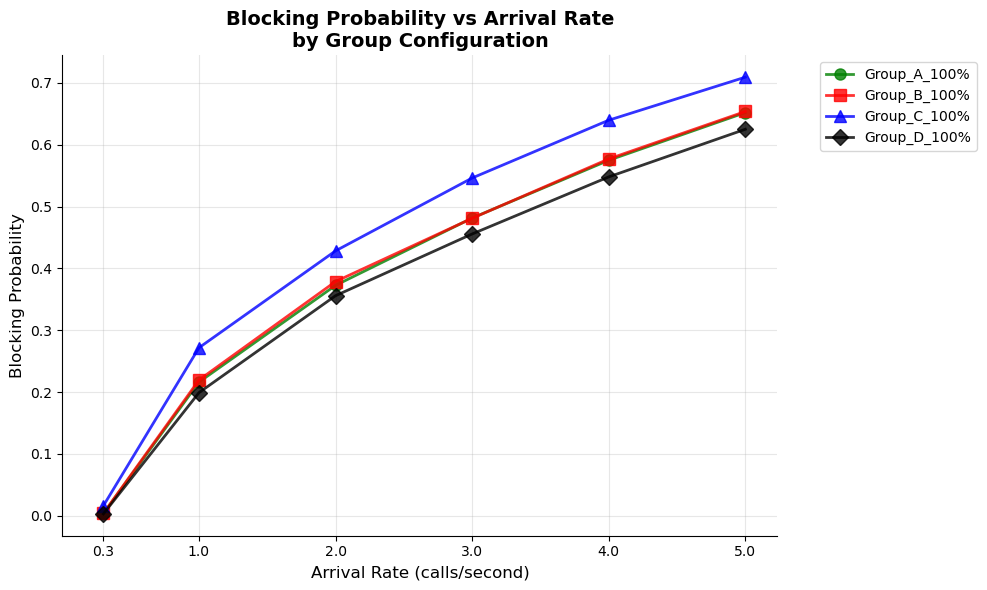

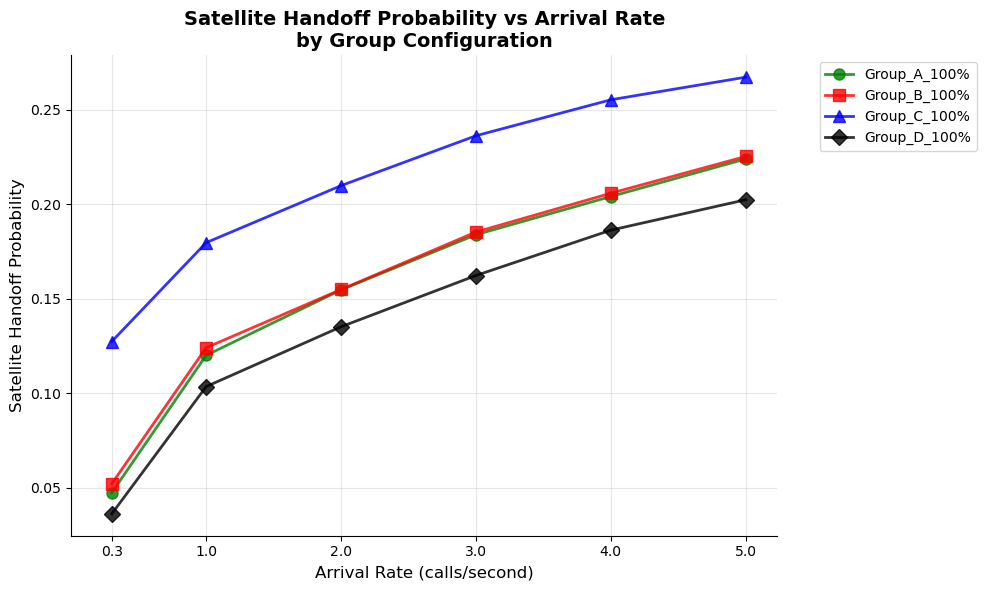

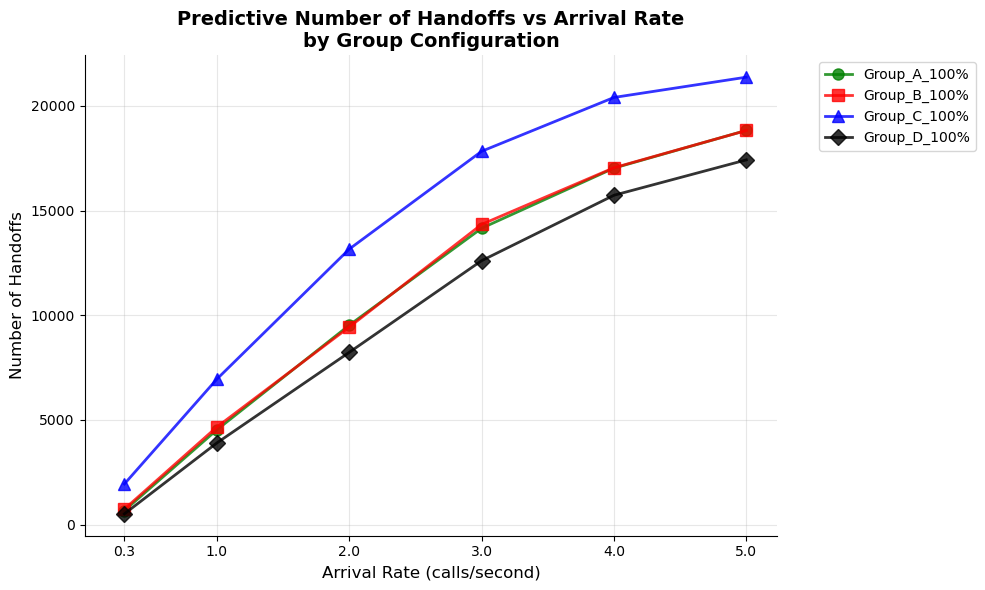


COMPREHENSIVE SUMMARY TABLE (PREDICTIVE ONLY)
Configuration  Arrival Rate (calls/sec) Predictive Blocking Prob Predictive Handoff Prob  Predictive Handoffs  Total Calls
 Group_A_100%                       0.3                   0.0036                  0.0474                  662        24700
 Group_A_100%                       1.0                   0.2160                  0.1200                 4529        82937
 Group_A_100%                       2.0                   0.3725                  0.1547                 9528       166053
 Group_A_100%                       3.0                   0.4814                  0.1838                14158       248718
 Group_A_100%                       4.0                   0.5748                  0.2040                17031       331823
 Group_A_100%                       5.0                   0.6519                  0.2239                18833       414453
 Group_B_100%                       0.3                   0.0039                  0.0521    

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

# Load the results
with open('arrival_rate_results_multiple_groupsvary1.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("Parallel Simulation Results (Predictive Only):")
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_blocking_prob']])
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_handoff_prob']])
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_handoffs']])

# Define color palette with green, red, blue, black
COLORS = ['green', 'red', 'blue', 'black']

# Get unique configurations and markers
configs = df_results['config_name'].unique()
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

# PLOT 1: BLOCKING PROBABILITY (Predictive Only)
plt.figure(figsize=(10, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_blocking_prob'], 
             marker=markers[idx], linestyle='-', 
             color=COLORS[idx % len(COLORS)], alpha=0.8,
             label=f'{config}', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Blocking Probability', fontsize=12)
plt.title('Blocking Probability vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
plt.xlim(left=0)  # Remove space between y-axis and x=0
sns.despine()
plt.tight_layout()
plt.show()

# PLOT 2: HANDOFF PROBABILITY (Predictive Only)
plt.figure(figsize=(10, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_handoff_prob'], 
             marker=markers[idx], linestyle='-', 
             color=COLORS[idx % len(COLORS)], alpha=0.8,
             label=f'{config}', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Satellite Handoff Probability', fontsize=12)
plt.title('Satellite Handoff Probability vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
plt.xlim(left=0)  # Remove space between y-axis and x=0
sns.despine()
plt.tight_layout()
plt.show()

# PLOT 3: NUMBER OF HANDOFFS (Predictive Only)
plt.figure(figsize=(10, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_handoffs'], 
             marker=markers[idx], linestyle='-', 
             color=COLORS[idx % len(COLORS)], alpha=0.8,
             label=f'{config}', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Number of Handoffs', fontsize=12)
plt.title('Predictive Number of Handoffs vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
plt.xlim(left=0)  # Remove space between y-axis and x=0
sns.despine()
plt.tight_layout()
plt.show()

# Print comprehensive summary table (Predictive Only)
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY TABLE (PREDICTIVE ONLY)")
print("="*80)

summary_data = []
for config in configs:
    config_data = df_results[df_results['config_name'] == config]
    for _, row in config_data.iterrows():
        summary_data.append({
            'Configuration': config,
            'Arrival Rate (calls/sec)': row['arrival_rate_per_second'],
            'Predictive Blocking Prob': f"{row['predictive_blocking_prob']:.4f}",
            'Predictive Handoff Prob': f"{row['predictive_handoff_prob']:.4f}",
            'Predictive Handoffs': row['predictive_handoffs'],
            'Total Calls': row['total_calls']
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

Parallel Simulation Results (Predictive Only):
     config_name  arrival_rate_per_second  predictive_blocking_prob
0   Group_A_100%                      0.3                  0.064441
1   Group_A_100%                      1.0                  0.367354
2   Group_A_100%                      2.0                  0.567159
3   Group_A_100%                      3.0                  0.700408
4   Group_A_100%                      4.0                  0.773182
5   Group_A_100%                      5.0                  0.817176
6    Group_A_50%                      0.3                  0.007987
7    Group_A_50%                      1.0                  0.272632
8    Group_A_50%                      2.0                  0.446784
9    Group_A_50%                      3.0                  0.576529
10   Group_A_50%                      4.0                  0.676498
11   Group_A_50%                      5.0                  0.742483
     config_name  arrival_rate_per_second  predictive_handoff_prob
0 

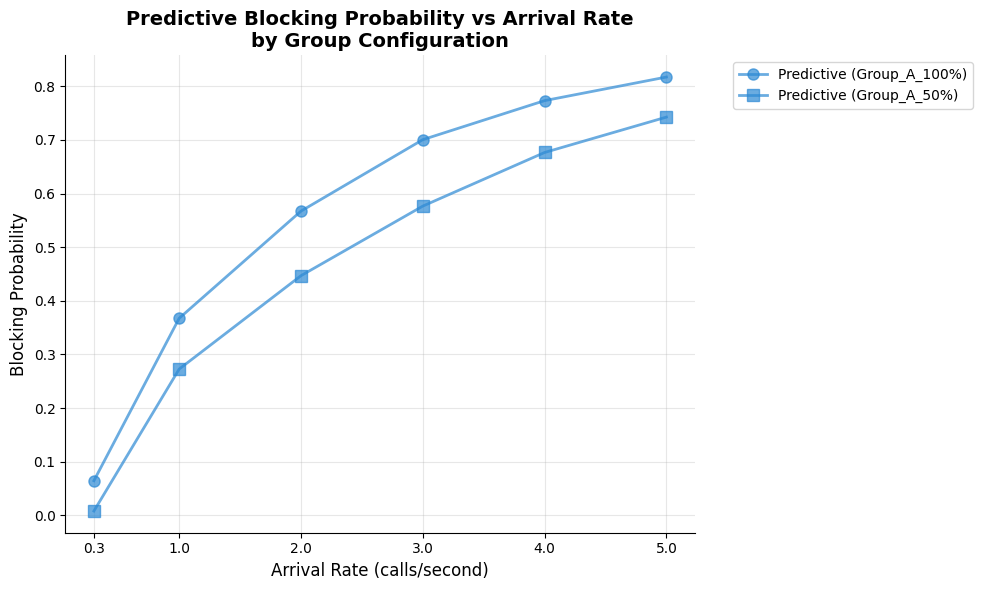

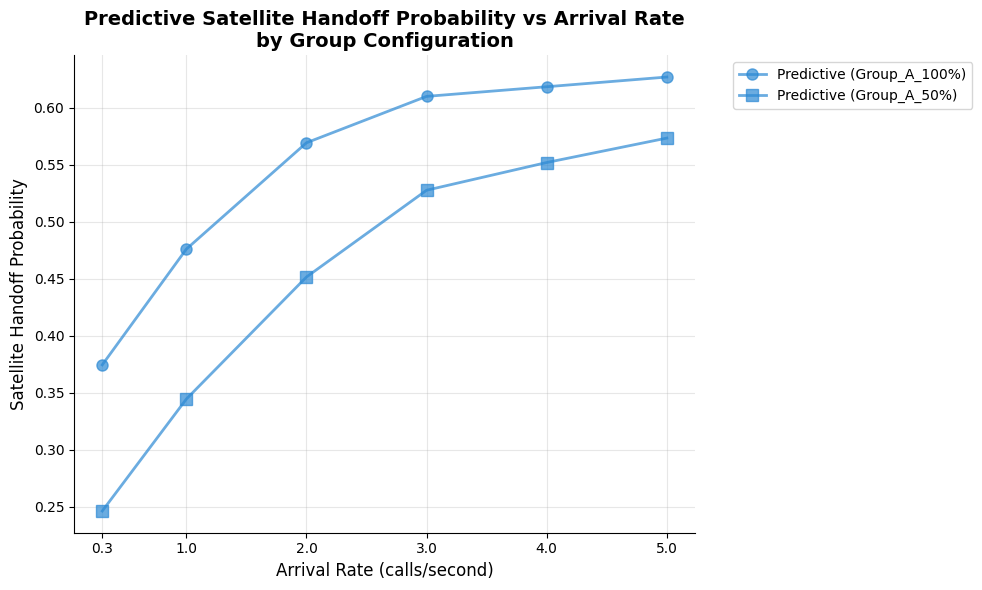

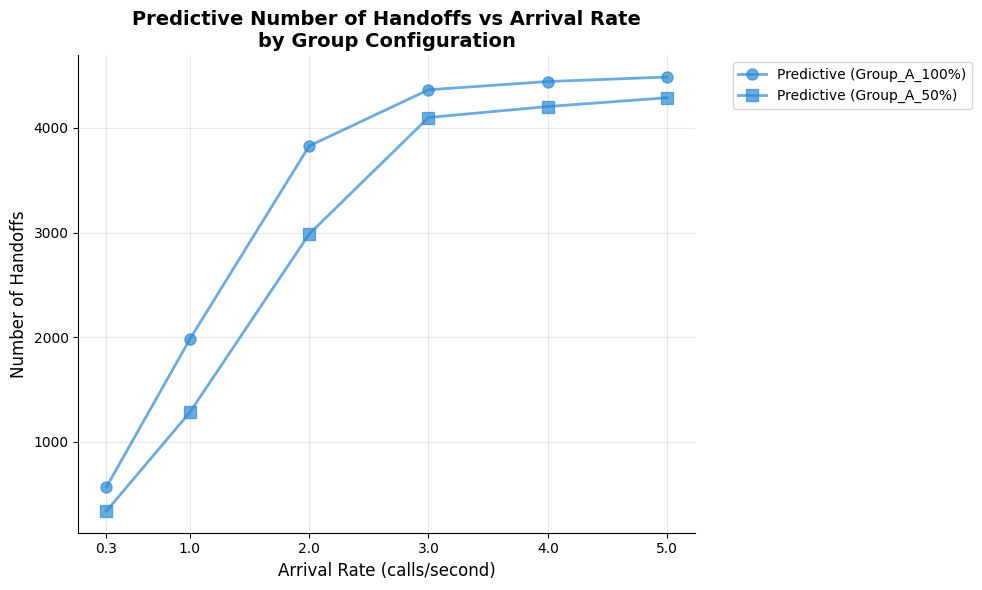


COMPREHENSIVE SUMMARY TABLE (PREDICTIVE ONLY)
Configuration  Arrival Rate (calls/sec) Predictive Blocking Prob Predictive Handoff Prob  Predictive Handoffs  Total Calls
 Group_A_100%                       0.3                   0.0644                  0.3745                  567         4283
 Group_A_100%                       1.0                   0.3674                  0.4760                 1982        14354
 Group_A_100%                       2.0                   0.5672                  0.5692                 3828        28611
 Group_A_100%                       3.0                   0.7004                  0.6099                 4365        43142
 Group_A_100%                       4.0                   0.7732                  0.6183                 4444        57522
 Group_A_100%                       5.0                   0.8172                  0.6269                 4487        72064
  Group_A_50%                       0.3                   0.0080                  0.2464    

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

# Load the results
with open('arrival_rate_results_multiple_groupsupdated.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("Parallel Simulation Results (Predictive Only):")
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_blocking_prob']])
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_handoff_prob']])
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_handoffs']])

# Set custom color for predictive only
PREDICTIVE_COLOR = '#2C89D4'

# Get unique configurations and markers
configs = df_results['config_name'].unique()
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

# PLOT 1: BLOCKING PROBABILITY (Predictive Only)
plt.figure(figsize=(10, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_blocking_prob'], 
             marker=markers[idx], linestyle='-', 
             color=PREDICTIVE_COLOR, alpha=0.7,
             label=f'Predictive ({config})', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Blocking Probability', fontsize=12)
plt.title('Predictive Blocking Probability vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
sns.despine()
plt.tight_layout()
plt.show()

# PLOT 2: HANDOFF PROBABILITY (Predictive Only)
plt.figure(figsize=(10, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_handoff_prob'], 
             marker=markers[idx], linestyle='-', 
             color=PREDICTIVE_COLOR, alpha=0.7,
             label=f'Predictive ({config})', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Satellite Handoff Probability', fontsize=12)
plt.title('Predictive Satellite Handoff Probability vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
sns.despine()
plt.tight_layout()
plt.show()

# PLOT 3: NUMBER OF HANDOFFS (Predictive Only)
plt.figure(figsize=(10, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_handoffs'], 
             marker=markers[idx], linestyle='-', 
             color=PREDICTIVE_COLOR, alpha=0.7,
             label=f'Predictive ({config})', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Number of Handoffs', fontsize=12)
plt.title('Predictive Number of Handoffs vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
sns.despine()
plt.tight_layout()
plt.show()

# Print comprehensive summary table (Predictive Only)
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY TABLE (PREDICTIVE ONLY)")
print("="*80)

summary_data = []
for config in configs:
    config_data = df_results[df_results['config_name'] == config]
    for _, row in config_data.iterrows():
        summary_data.append({
            'Configuration': config,
            'Arrival Rate (calls/sec)': row['arrival_rate_per_second'],
            'Predictive Blocking Prob': f"{row['predictive_blocking_prob']:.4f}",
            'Predictive Handoff Prob': f"{row['predictive_handoff_prob']:.4f}",
            'Predictive Handoffs': row['predictive_handoffs'],
            'Total Calls': row['total_calls']
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

Loading simulation results...
Results loaded:
Voice calls: 6 simulations
Video calls: 7 simulations

Generating predictive metrics only...


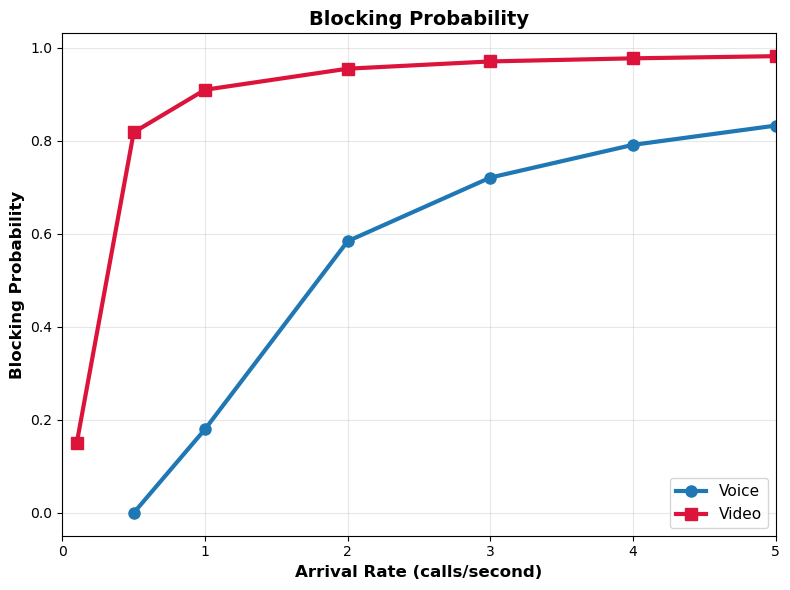

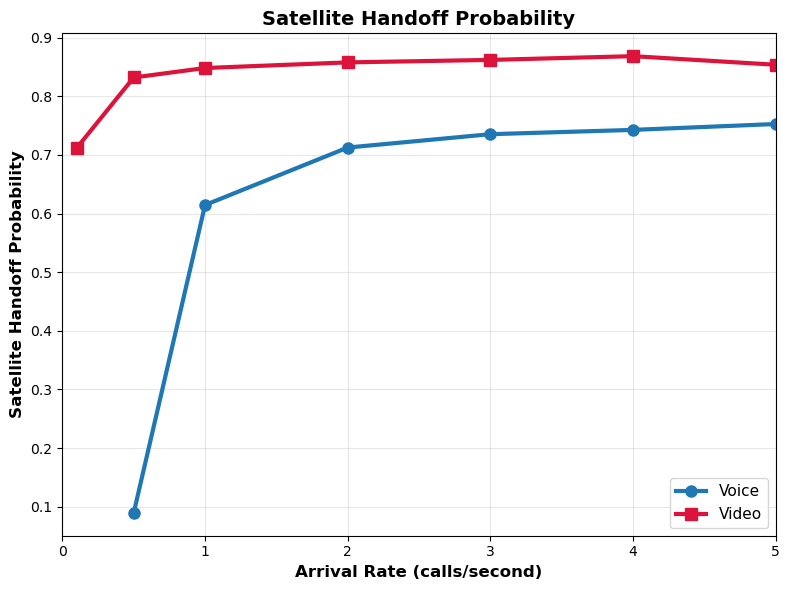

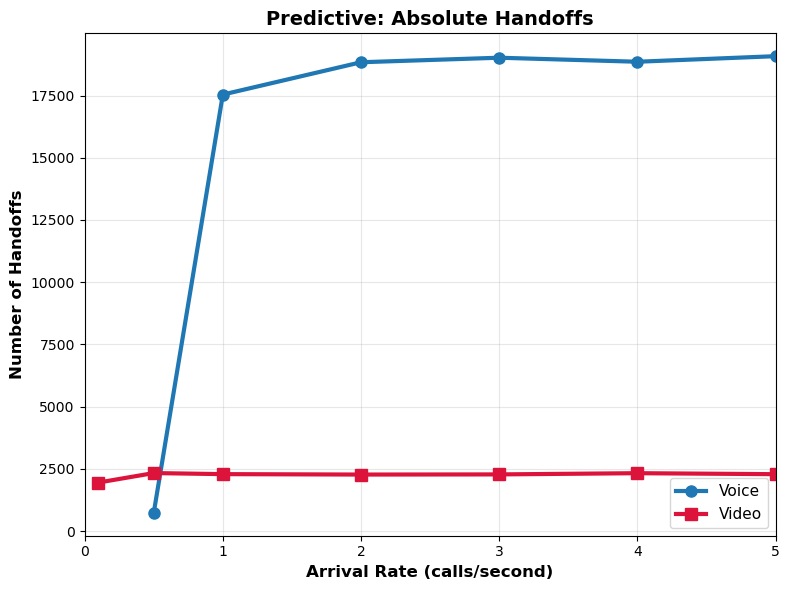


PREDICTIVE METRICS PLOTS GENERATED!


In [11]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_results(filename='service_type_different_rates_results1.pkl'):
    """Load and separate the simulation results by service type"""
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame and filter errors
    df = pd.DataFrame(results)
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Separate by service type
    voice_df = df[df['service_type'] == 'voice'].sort_values('arrival_rate_per_second')
    video_df = df[df['service_type'] == 'video'].sort_values('arrival_rate_per_second')
    
    print("Results loaded:")
    print(f"Voice calls: {len(voice_df)} simulations")
    print(f"Video calls: {len(video_df)} simulations")
    
    return voice_df, video_df

def plot_predictive_metrics_only(voice_df, video_df):
    """Plot only predictive metrics for both voice and video in separate graphs"""
    
    # Plot 1: Predictive Blocking Probability
    plt.figure(figsize=(8, 6))
    
    if len(voice_df) > 0:
        plt.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_blocking_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='#1f77b4', linestyle='-',
                label='Voice')
    
    if len(video_df) > 0:
        plt.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_blocking_prob'], 
                marker='s', linewidth=3, markersize=8,
                color='#DC143C', linestyle='-',
                label='Video')
    
    plt.xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    plt.ylabel('Blocking Probability', fontsize=12, fontweight='bold')
    plt.title('Blocking Probability', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)  # Changed to lower right
    plt.grid(True, alpha=0.3)
    
    # Remove gap between y-axis and x-axis
    plt.margins(x=0)
    plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Predictive Handoff Probability
    plt.figure(figsize=(8, 6))
    
    if len(voice_df) > 0:
        plt.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_handoff_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='#1f77b4', linestyle='-',
                label='Voice')
    
    if len(video_df) > 0:
        plt.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_handoff_prob'], 
                marker='s', linewidth=3, markersize=8,
                color='#DC143C', linestyle='-',
                label='Video')
    
    plt.xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    plt.ylabel('Satellite Handoff Probability', fontsize=12, fontweight='bold')
    plt.title('Satellite Handoff Probability', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)  # Changed to lower right
    plt.grid(True, alpha=0.3)
    
    # Remove gap between y-axis and x-axis
    plt.margins(x=0)
    plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Predictive Absolute Handoffs
    plt.figure(figsize=(8, 6))
    
    if len(voice_df) > 0:
        plt.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_handoffs'], 
                marker='o', linewidth=3, markersize=8,
                color='#1f77b4', linestyle='-',
                label='Voice')
    
    if len(video_df) > 0:
        plt.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_handoffs'], 
                marker='s', linewidth=3, markersize=8,
                color='#DC143C', linestyle='-',
                label='Video')
    
    plt.xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Handoffs', fontsize=12, fontweight='bold')
    plt.title('Predictive: Absolute Handoffs', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)  # Changed to lower right
    plt.grid(True, alpha=0.3)
    
    # Remove gap between y-axis and x-axis
    plt.margins(x=0)
    plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()

def generate_predictive_only_plots():
    """Generate only predictive metrics plots"""
    
    print("Loading simulation results...")
    voice_df, video_df = load_results()
    
    print("\nGenerating predictive metrics only...")
    plot_predictive_metrics_only(voice_df, video_df)
    
    print("\n" + "=" * 50)
    print("PREDICTIVE METRICS PLOTS GENERATED!")
    print("=" * 50)

# Run the predictive-only analysis
if __name__ == "__main__":
    generate_predictive_only_plots()

Loading simulation results...
Results loaded:
Voice calls: 6 simulations
Video calls: 7 simulations

HANDOFF PROBABILITY VALUES

Arrival Rate    Voice Handoff Prob   Video Handoff Prob  
-------------------------------------------------------
0.100           N/A                  0.7118              
0.500           0.0894               0.8322              
1.000           0.6146               0.8484              
2.000           0.7127               0.8580              
3.000           0.7354               0.8622              
4.000           0.7428               0.8686              
5.000           0.7528               0.8539              

Generating predictive metrics plots...


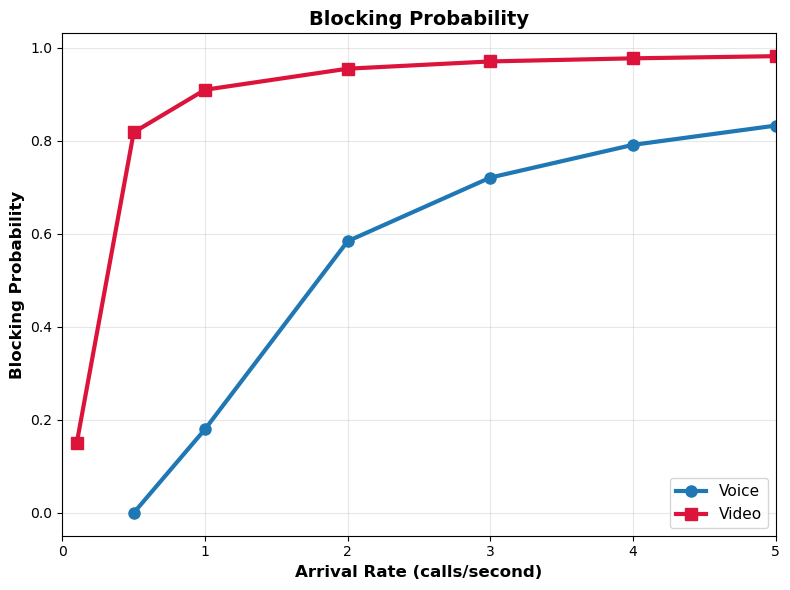

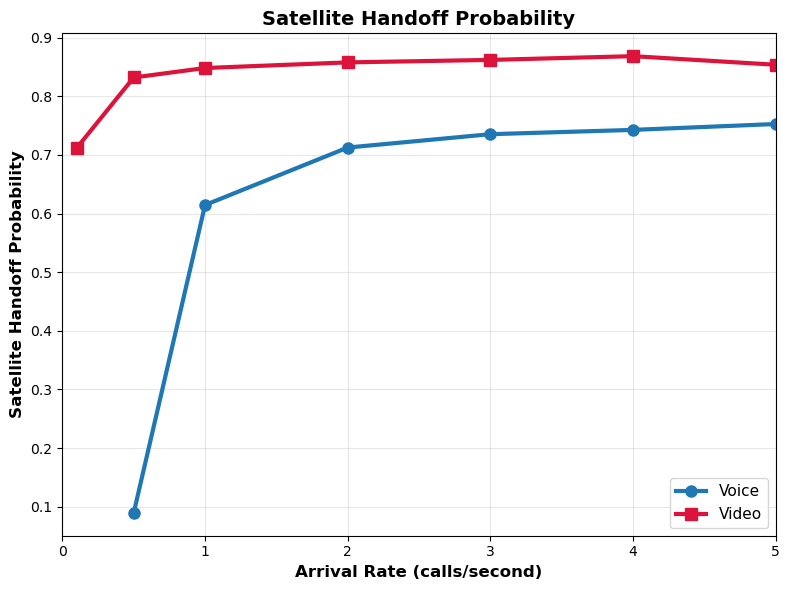

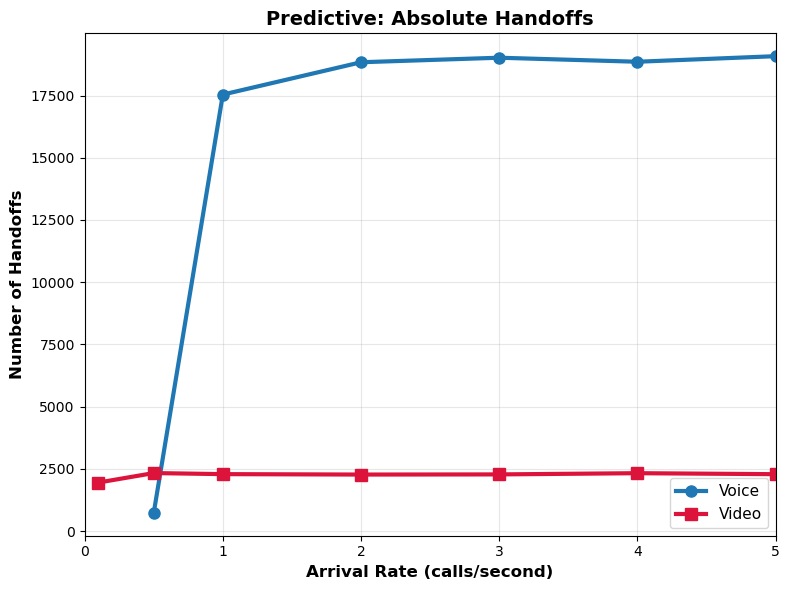


PREDICTIVE METRICS PLOTS GENERATED!


In [14]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_results(filename='service_type_different_rates_results1.pkl'):
    """Load and separate the simulation results by service type"""
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame and filter errors
    df = pd.DataFrame(results)
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Separate by service type
    voice_df = df[df['service_type'] == 'voice'].sort_values('arrival_rate_per_second')
    video_df = df[df['service_type'] == 'video'].sort_values('arrival_rate_per_second')
    
    print("Results loaded:")
    print(f"Voice calls: {len(voice_df)} simulations")
    print(f"Video calls: {len(video_df)} simulations")
    
    return voice_df, video_df

def print_handoff_probability_values(voice_df, video_df):
    """Print only the handoff probability values in a clean table format"""
    
    print("\n" + "="*60)
    print("HANDOFF PROBABILITY VALUES")
    print("="*60)
    
    print(f"\n{'Arrival Rate':<15} {'Voice Handoff Prob':<20} {'Video Handoff Prob':<20}")
    print("-" * 55)
    
    # Get all unique arrival rates
    all_rates = sorted(set(voice_df['arrival_rate_per_second'].tolist() + 
                          video_df['arrival_rate_per_second'].tolist()))
    
    for rate in all_rates:
        voice_prob = voice_df[voice_df['arrival_rate_per_second'] == rate]['predictive_handoff_prob']
        video_prob = video_df[video_df['arrival_rate_per_second'] == rate]['predictive_handoff_prob']
        
        voice_val = voice_prob.values[0] if len(voice_prob) > 0 else "N/A"
        video_val = video_prob.values[0] if len(video_prob) > 0 else "N/A"
        
        # Format values nicely
        if voice_val != "N/A":
            voice_val = f"{voice_val:.4f}"
        if video_val != "N/A":
            video_val = f"{video_val:.4f}"
            
        print(f"{rate:<15.3f} {voice_val:<20} {video_val:<20}")

def generate_predictive_only_plots():
    """Generate only predictive metrics plots"""
    
    print("Loading simulation results...")
    voice_df, video_df = load_results()
    
    # Print handoff probability values
    print_handoff_probability_values(voice_df, video_df)
    
    print("\nGenerating predictive metrics plots...")
    plot_predictive_metrics_only(voice_df, video_df)
    
    print("\n" + "=" * 50)
    print("PREDICTIVE METRICS PLOTS GENERATED!")
    print("=" * 50)

# Keep your existing plot function (unchanged)
def plot_predictive_metrics_only(voice_df, video_df):
    """Plot only predictive metrics for both voice and video in separate graphs"""
    
    # Plot 1: Predictive Blocking Probability
    plt.figure(figsize=(8, 6))
    
    if len(voice_df) > 0:
        plt.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_blocking_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='#1f77b4', linestyle='-',
                label='Voice')
    
    if len(video_df) > 0:
        plt.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_blocking_prob'], 
                marker='s', linewidth=3, markersize=8,
                color='#DC143C', linestyle='-',
                label='Video')
    
    plt.xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    plt.ylabel('Blocking Probability', fontsize=12, fontweight='bold')
    plt.title('Blocking Probability', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Remove gap between y-axis and x-axis
    plt.margins(x=0)
    plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Predictive Handoff Probability
    plt.figure(figsize=(8, 6))
    
    if len(voice_df) > 0:
        plt.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_handoff_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='#1f77b4', linestyle='-',
                label='Voice')
    
    if len(video_df) > 0:
        plt.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_handoff_prob'], 
                marker='s', linewidth=3, markersize=8,
                color='#DC143C', linestyle='-',
                label='Video')
    
    plt.xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    plt.ylabel('Satellite Handoff Probability', fontsize=12, fontweight='bold')
    plt.title('Satellite Handoff Probability', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Remove gap between y-axis and x-axis
    plt.margins(x=0)
    plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Predictive Absolute Handoffs
    plt.figure(figsize=(8, 6))
    
    if len(voice_df) > 0:
        plt.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_handoffs'], 
                marker='o', linewidth=3, markersize=8,
                color='#1f77b4', linestyle='-',
                label='Voice')
    
    if len(video_df) > 0:
        plt.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_handoffs'], 
                marker='s', linewidth=3, markersize=8,
                color='#DC143C', linestyle='-',
                label='Video')
    
    plt.xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Handoffs', fontsize=12, fontweight='bold')
    plt.title('Predictive: Absolute Handoffs', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Remove gap between y-axis and x-axis
    plt.margins(x=0)
    plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    generate_predictive_only_plots()

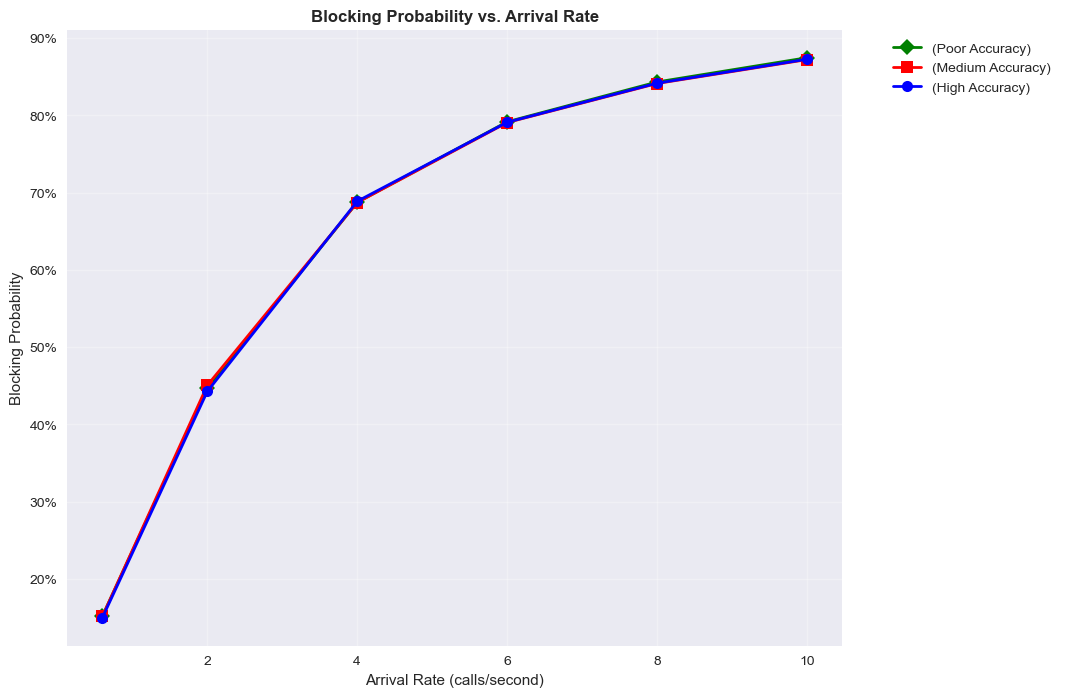

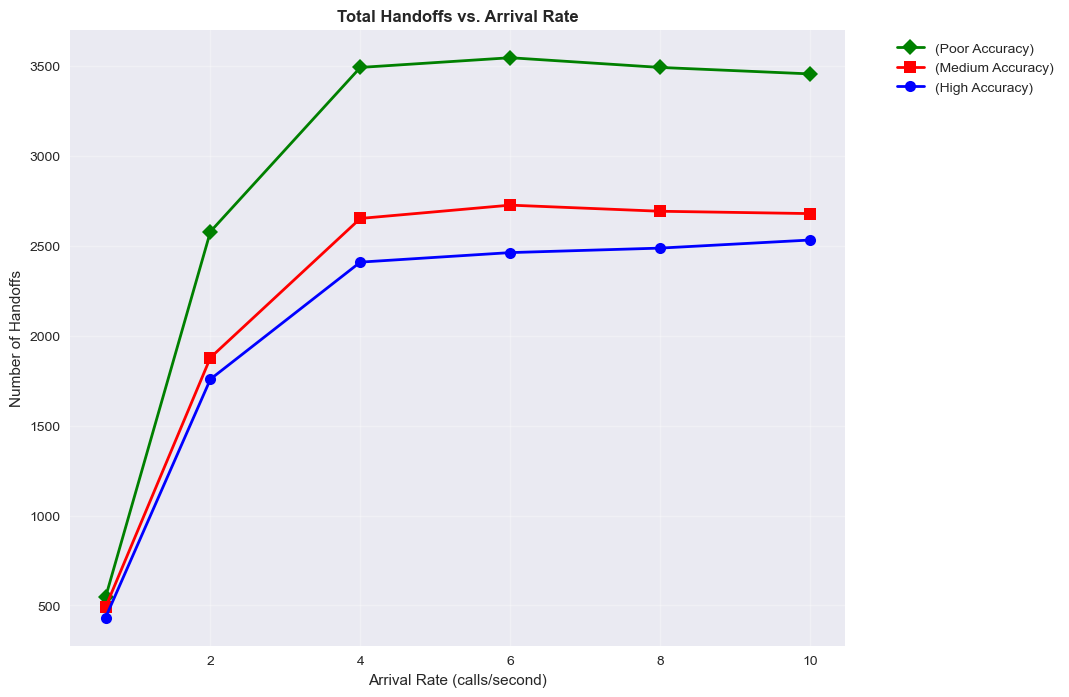

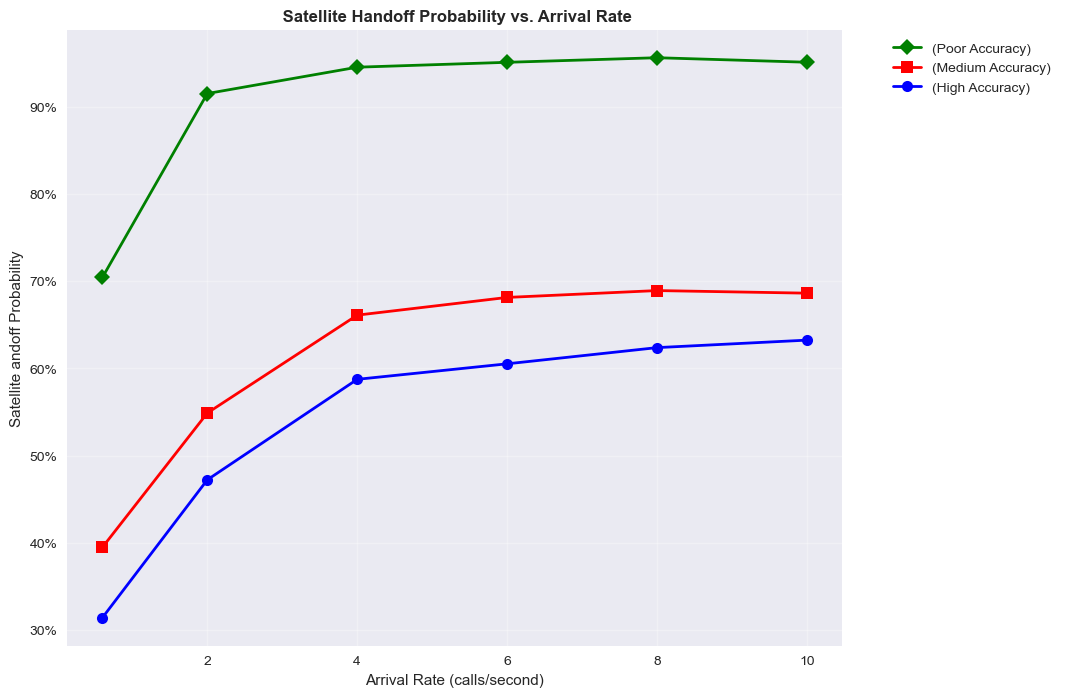


SUMMARY TABLE
 Accuracy Level  R² Score  Arrival Rate (calls/sec) Predictive Blocking Prob Non-Predictive Blocking Prob Blocking Improvement  Predictive Handoffs  Non-Predictive Handoffs Predictive Handoff Prob Non-Predictive Handoff Prob
  High Accuracy  0.998350                       0.6                    0.150                        0.152                 1.5%                  432                     1189                   0.314                       0.697
  High Accuracy  0.998350                       2.0                    0.443                        0.445                 0.4%                 1759                     2246                   0.472                       0.671
  High Accuracy  0.998350                       4.0                    0.689                        0.691                 0.3%                 2410                     2526                   0.587                       0.674
  High Accuracy  0.998350                       6.0                    0.791         

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_multi_accuracy_results(results_file):
    """
    Plot blocking probability, number of handoffs, and handoff probability
    across different accuracy levels, each in a separate figure.
    """
    
    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Remove any results with errors
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    
    # Get unique accuracy levels and sort by R² score
    accuracy_levels = sorted(df['accuracy_label'].unique(), 
                           key=lambda x: df[df['accuracy_label'] == x]['r2_score'].iloc[0])
    
    # Define colors and markers for different accuracy levels
    colors = {'High Accuracy': "blue",    # Blue
              'Medium Accuracy': 'red',   # Red
              'Low Accuracy': "green",    # Green
              'Poor Accuracy': 'green'}  # Orange 
    
    markers = {'High Accuracy': 'o', 
               'Medium Accuracy': 's', 
               'Low Accuracy': '^', 
               'Poor Accuracy': 'D'}
    
    # Use solid lines for all (no dashed lines)
    line_styles = {'High Accuracy': '-', 
                   'Medium Accuracy': '-', 
                   'Low Accuracy': '-', 
                   'Poor Accuracy': '-'}
    
    # Plot 1: Blocking Probability Comparison
    plt.figure(figsize=(10, 8))
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        # Plot predictive controller
        plt.plot(accuracy_data['arrival_rate_per_second'], 
                 accuracy_data['predictive_blocking_prob'],
                 label=f'({accuracy})',
                 color=colors.get(accuracy, '#000000'),
                 marker=markers.get(accuracy, 'o'),
                 linestyle=line_styles.get(accuracy, '-'),
                 linewidth=2,
                 markersize=8)

    
    plt.xlabel('Arrival Rate (calls/second)')
    plt.ylabel('Blocking Probability')
    plt.title('Blocking Probability vs. Arrival Rate', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.show()
    
    # Plot 2: Number of Handoffs
    plt.figure(figsize=(10, 8))
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        plt.plot(accuracy_data['arrival_rate_per_second'], 
                 accuracy_data['predictive_handoffs'],
                 label=f'({accuracy})',
                 color=colors.get(accuracy, '#000000'),
                 marker=markers.get(accuracy, 'o'),
                 linestyle=line_styles.get(accuracy, '-'),
                 linewidth=2,
                 markersize=8)
        
    
    plt.xlabel('Arrival Rate (calls/second)')
    plt.ylabel('Number of Handoffs')
    plt.title('Total Handoffs vs. Arrival Rate', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # Plot 3: Handoff Probability
    plt.figure(figsize=(10, 8))
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        plt.plot(accuracy_data['arrival_rate_per_second'], 
                 accuracy_data['predictive_handoff_prob'],
                 label=f'({accuracy})',
                 color=colors.get(accuracy, '#000000'),
                 marker=markers.get(accuracy, 'o'),
                 linestyle=line_styles.get(accuracy, '-'),
                 linewidth=2,
                 markersize=8)
        
      
    plt.xlabel('Arrival Rate (calls/second)')
    plt.ylabel('Satellite andoff Probability')
    plt.title(' Satellite Handoff Probability vs. Arrival Rate', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.show()
    
    return df


def create_summary_table(results_file):
    """
    Create a summary table of the results
    """
    
    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Create summary table
    summary_data = []
    
    for accuracy in df['accuracy_label'].unique():
        accuracy_data = df[df['accuracy_label'] == accuracy]
        r2_score = accuracy_data['r2_score'].iloc[0]
        
        for rate in sorted(accuracy_data['arrival_rate_per_second'].unique()):
            rate_data = accuracy_data[accuracy_data['arrival_rate_per_second'] == rate].iloc[0]
            
            summary_data.append({
                'Accuracy Level': accuracy,
                'R² Score': r2_score,
                'Arrival Rate (calls/sec)': rate,
                'Predictive Blocking Prob': f"{rate_data['predictive_blocking_prob']:.3f}",
                'Non-Predictive Blocking Prob': f"{rate_data['nonpredictive_blocking_prob']:.3f}",
                'Blocking Improvement': f"{(rate_data['nonpredictive_blocking_prob'] - rate_data['predictive_blocking_prob']) / rate_data['nonpredictive_blocking_prob']:.1%}",
                'Predictive Handoffs': int(rate_data['predictive_handoffs']),
                'Non-Predictive Handoffs': int(rate_data['nonpredictive_handoffs']),
                'Predictive Handoff Prob': f"{rate_data['predictive_handoff_prob']:.3f}",
                'Non-Predictive Handoff Prob': f"{rate_data['nonpredictive_handoff_prob_']:.3f}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Usage example:
if __name__ == "__main__":
    # Replace with your actual results file name
    results_file = 'arrival_rate_results_multiaccuracy_20251021_234346.pkl'
    
    try:
        # Plot all results
        df = plot_multi_accuracy_results(results_file)
        
        # Create and display summary table
        summary_table = create_summary_table(results_file)
        print("\n" + "="*100)
        print("SUMMARY TABLE")
        print("="*100)
        print(summary_table.to_string(index=False))
        
        # Save summary table to CSV
        summary_table.to_csv('simulation_results_summary.csv', index=False)
        print(f"\nSummary table saved to 'simulation_results_summary.csv'")
        
    except FileNotFoundError:
        print(f"Results file '{results_file}' not found.")
        print("Available files:")
        import glob
        result_files = glob.glob('arrival_rate_results_multiaccuracy_20251021_234346.pkl')
        for file in result_files:
            print(f"  - {file}")

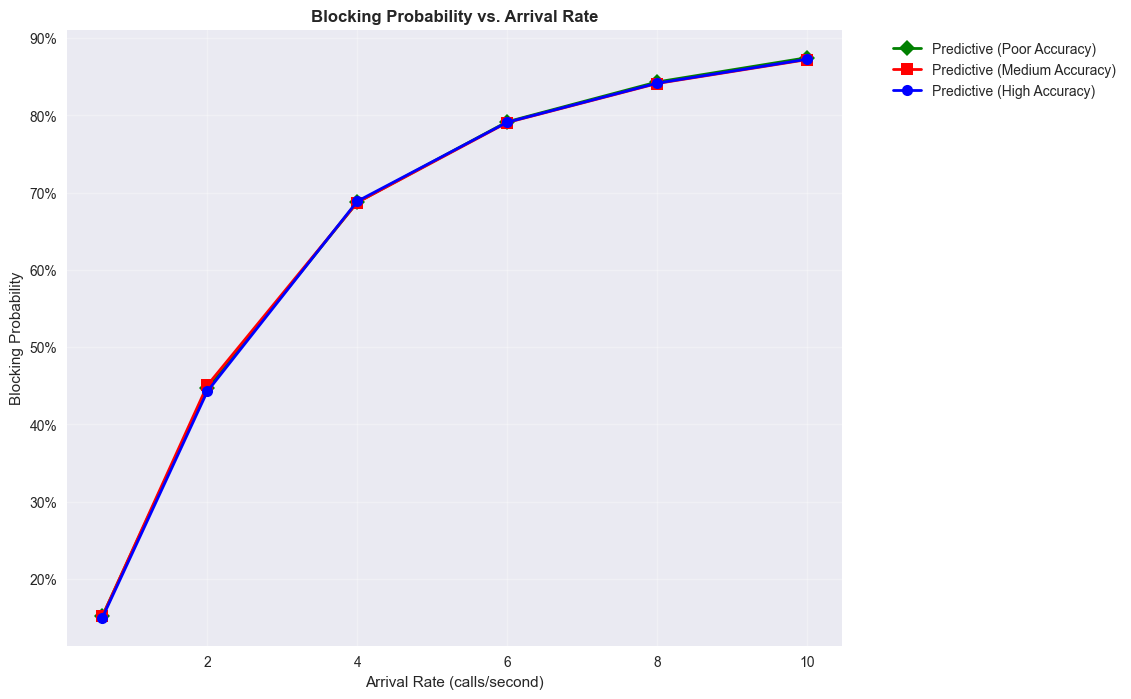

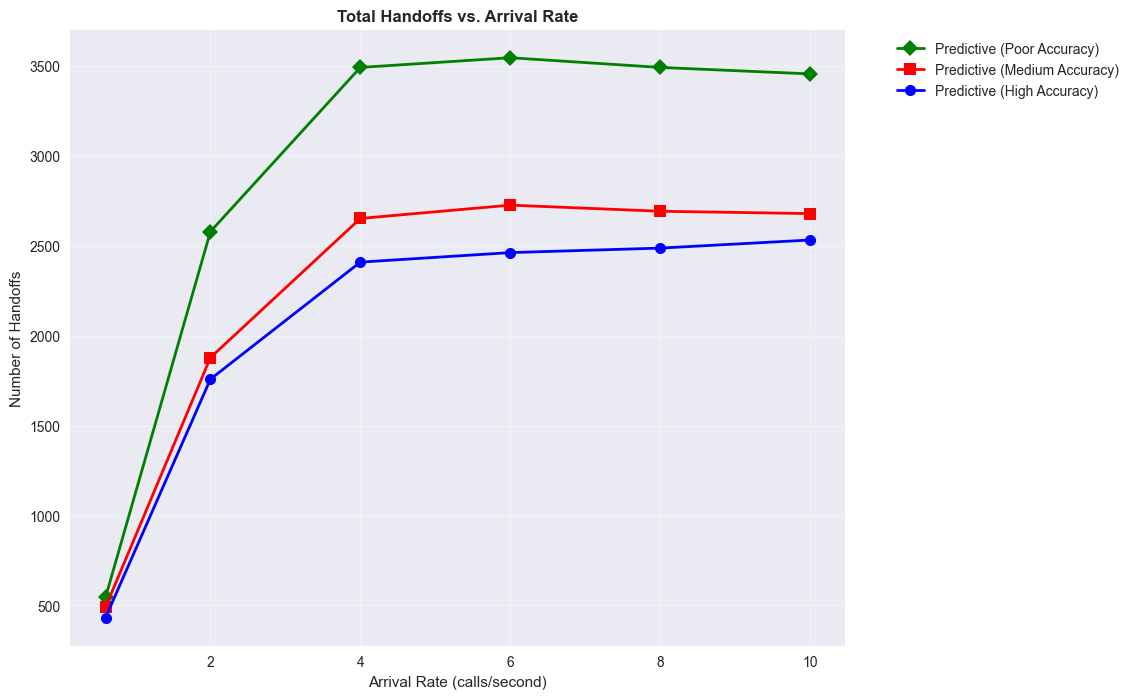

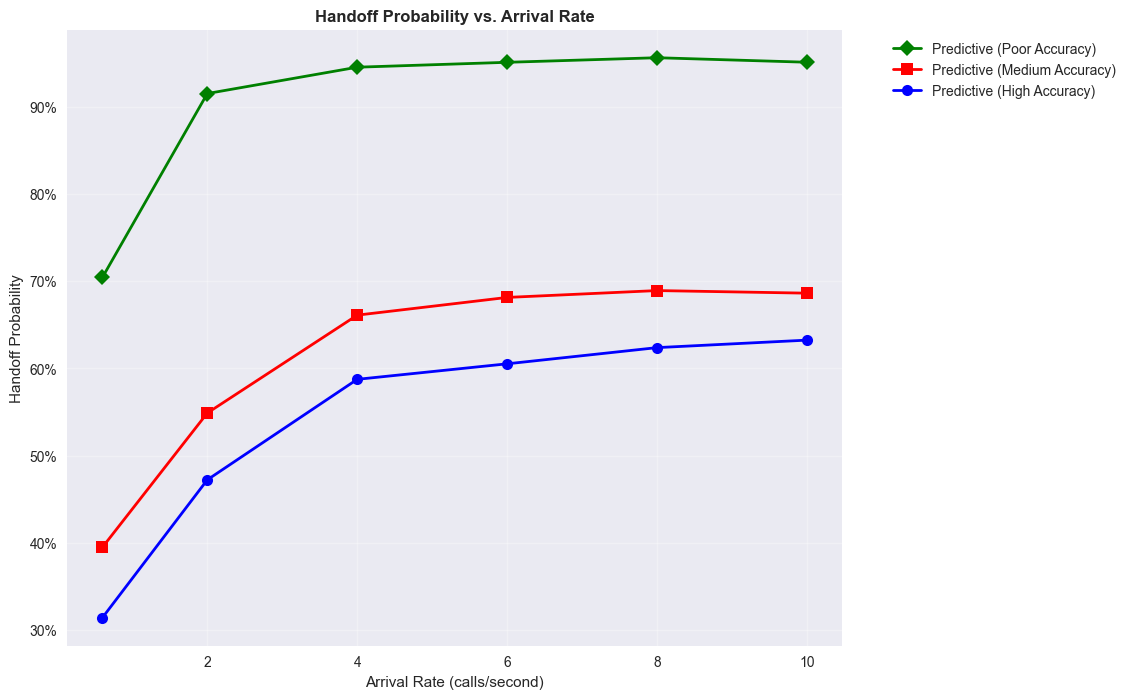


SUMMARY TABLE
 Accuracy Level  R² Score  Arrival Rate (calls/sec) Predictive Blocking Prob Non-Predictive Blocking Prob Blocking Improvement  Predictive Handoffs  Non-Predictive Handoffs Predictive Handoff Prob Non-Predictive Handoff Prob
  High Accuracy  0.998350                       0.6                    0.150                        0.152                 1.5%                  432                     1189                   0.314                       0.697
  High Accuracy  0.998350                       2.0                    0.443                        0.445                 0.4%                 1759                     2246                   0.472                       0.671
  High Accuracy  0.998350                       4.0                    0.689                        0.691                 0.3%                 2410                     2526                   0.587                       0.674
  High Accuracy  0.998350                       6.0                    0.791         

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_multi_accuracy_results(results_file):
    """
    Plot blocking probability, number of handoffs, and handoff probability
    across different accuracy levels, each in a separate figure.
    """
    
    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Remove any results with errors
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    
    # Get unique accuracy levels and sort by R² score
    accuracy_levels = sorted(df['accuracy_label'].unique(), 
                           key=lambda x: df[df['accuracy_label'] == x]['r2_score'].iloc[0])
    
    # Define colors and markers for different accuracy levels
    colors = {'High Accuracy': "blue",    # Blue
              'Medium Accuracy': 'red',   # Red
              'Low Accuracy': "green",    # Green
              'Poor Accuracy': 'green'}  # Orange 
    
    markers = {'High Accuracy': 'o', 
               'Medium Accuracy': 's', 
               'Low Accuracy': '^', 
               'Poor Accuracy': 'D'}
    
    # Use solid lines for all (no dashed lines)
    line_styles = {'High Accuracy': '-', 
                   'Medium Accuracy': '-', 
                   'Low Accuracy': '-', 
                   'Poor Accuracy': '-'}
    
    # Plot 1: Blocking Probability Comparison
    plt.figure(figsize=(10, 8))
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        # Plot predictive controller
        plt.plot(accuracy_data['arrival_rate_per_second'], 
                 accuracy_data['predictive_blocking_prob'],
                 label=f'Predictive ({accuracy})',
                 color=colors.get(accuracy, '#000000'),
                 marker=markers.get(accuracy, 'o'),
                 linestyle=line_styles.get(accuracy, '-'),
                 linewidth=2,
                 markersize=8)

    
    plt.xlabel('Arrival Rate (calls/second)')
    plt.ylabel('Blocking Probability')
    plt.title('Blocking Probability vs. Arrival Rate', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.show()
    
    # Plot 2: Number of Handoffs
    plt.figure(figsize=(10, 8))
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        plt.plot(accuracy_data['arrival_rate_per_second'], 
                 accuracy_data['predictive_handoffs'],
                 label=f'Predictive ({accuracy})',
                 color=colors.get(accuracy, '#000000'),
                 marker=markers.get(accuracy, 'o'),
                 linestyle=line_styles.get(accuracy, '-'),
                 linewidth=2,
                 markersize=8)
        
    
    plt.xlabel('Arrival Rate (calls/second)')
    plt.ylabel('Number of Handoffs')
    plt.title('Total Handoffs vs. Arrival Rate', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # Plot 3: Handoff Probability
    plt.figure(figsize=(10, 8))
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        plt.plot(accuracy_data['arrival_rate_per_second'], 
                 accuracy_data['predictive_handoff_prob'],
                 label=f'Predictive ({accuracy})',
                 color=colors.get(accuracy, '#000000'),
                 marker=markers.get(accuracy, 'o'),
                 linestyle=line_styles.get(accuracy, '-'),
                 linewidth=2,
                 markersize=8)
        
      
    plt.xlabel('Arrival Rate (calls/second)')
    plt.ylabel('Satellite andoff Probability')
    plt.title(' Satellite Handoff Probability vs. Arrival Rate', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.show()
    
    return df


def create_summary_table(results_file):
    """
    Create a summary table of the results
    """
    
    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Create summary table
    summary_data = []
    
    for accuracy in df['accuracy_label'].unique():
        accuracy_data = df[df['accuracy_label'] == accuracy]
        r2_score = accuracy_data['r2_score'].iloc[0]
        
        for rate in sorted(accuracy_data['arrival_rate_per_second'].unique()):
            rate_data = accuracy_data[accuracy_data['arrival_rate_per_second'] == rate].iloc[0]
            
            summary_data.append({
                'Accuracy Level': accuracy,
                'R² Score': r2_score,
                'Arrival Rate (calls/sec)': rate,
                'Predictive Blocking Prob': f"{rate_data['predictive_blocking_prob']:.3f}",
                'Non-Predictive Blocking Prob': f"{rate_data['nonpredictive_blocking_prob']:.3f}",
                'Blocking Improvement': f"{(rate_data['nonpredictive_blocking_prob'] - rate_data['predictive_blocking_prob']) / rate_data['nonpredictive_blocking_prob']:.1%}",
                'Predictive Handoffs': int(rate_data['predictive_handoffs']),
                'Non-Predictive Handoffs': int(rate_data['nonpredictive_handoffs']),
                'Predictive Handoff Prob': f"{rate_data['predictive_handoff_prob']:.3f}",
                'Non-Predictive Handoff Prob': f"{rate_data['nonpredictive_handoff_prob_']:.3f}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Usage example:
if __name__ == "__main__":
    # Replace with your actual results file name
    results_file = 'arrival_rate_results_multiaccuracy_20251021_234346.pkl'
    
    try:
        # Plot all results
        df = plot_multi_accuracy_results(results_file)
        
        # Create and display summary table
        summary_table = create_summary_table(results_file)
        print("\n" + "="*100)
        print("SUMMARY TABLE")
        print("="*100)
        print(summary_table.to_string(index=False))
        
        # Save summary table to CSV
        summary_table.to_csv('simulation_results_summary.csv', index=False)
        print(f"\nSummary table saved to 'simulation_results_summary.csv'")
        
    except FileNotFoundError:
        print(f"Results file '{results_file}' not found.")
        print("Available files:")
        import glob
        result_files = glob.glob('arrival_rate_results_multiaccuracy_20251021_234346.pkl')
        for file in result_files:
            print(f"  - {file}")

CALL DURATION STATISTICS ANALYSIS WITH QUARTILES

DETAILED CALL DURATION STATISTICS BY SCENARIO
--------------------------------------------------------------------------------


Scenario,Mean (s),Q25 (s),Median (s),Q75 (s),Q90 (s),Min (s),Max (s)
Weekday Working Hours,195.7 ± 5.4,107.9,170.4,256.9,350.7,33.8,1135.7
Weekend Evening,533.2 ± 32.6,255.9,432.1,690.8,1022.0,34.2,5679.2



CALL DURATION COMPARISON: WEEKDAY vs WEEKEND
--------------------------------------------------------------------------------


Metric,Weekday Working Hours,Weekend Evening,Difference
Mean Duration (s),195.7 ± 5.4,533.2 ± 32.6,+337.5
Q25 (25th Percentile),107.9,255.9,+148.0
Median (50th Percentile),170.4,432.1,+261.7
Q75 (75th Percentile),256.9,690.8,+433.9
Q90 (90th Percentile),350.7,1022.0,+671.3
Minimum Duration (s),33.8,34.2,+0.4
Maximum Duration (s),1135.7,5679.2,+4543.5


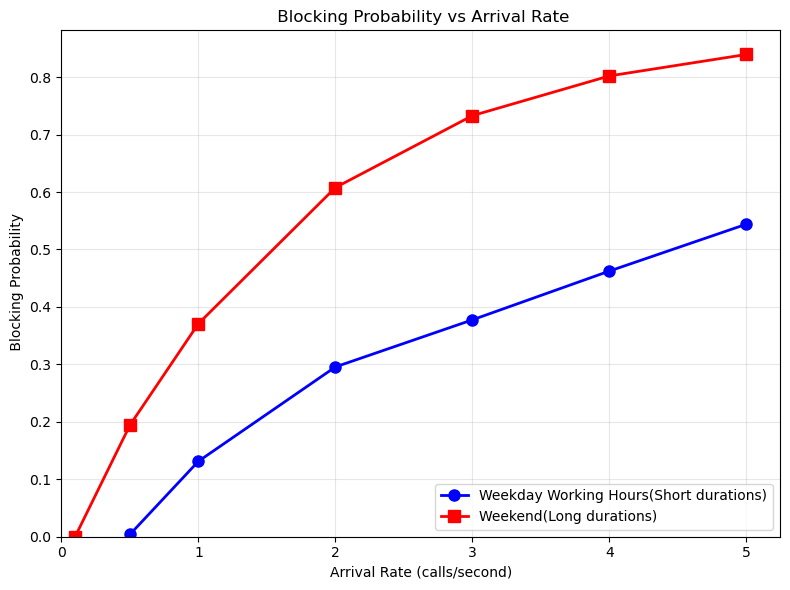

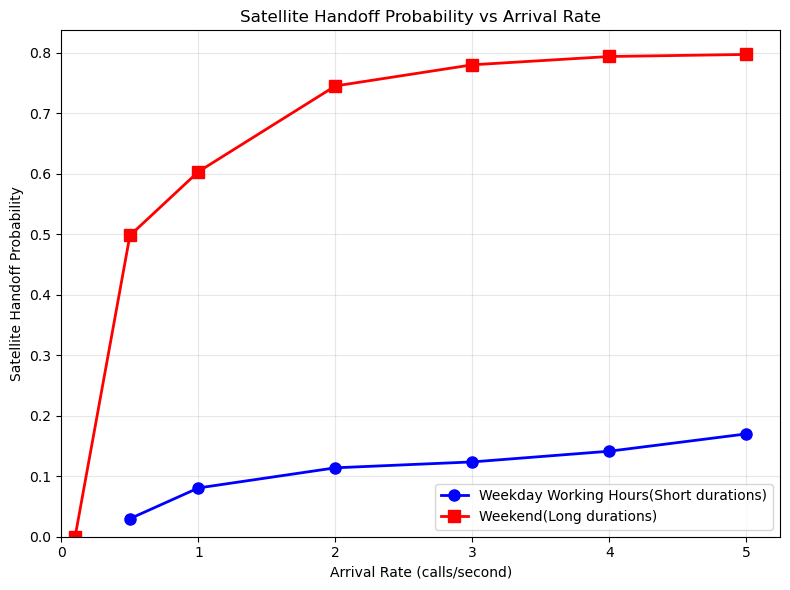

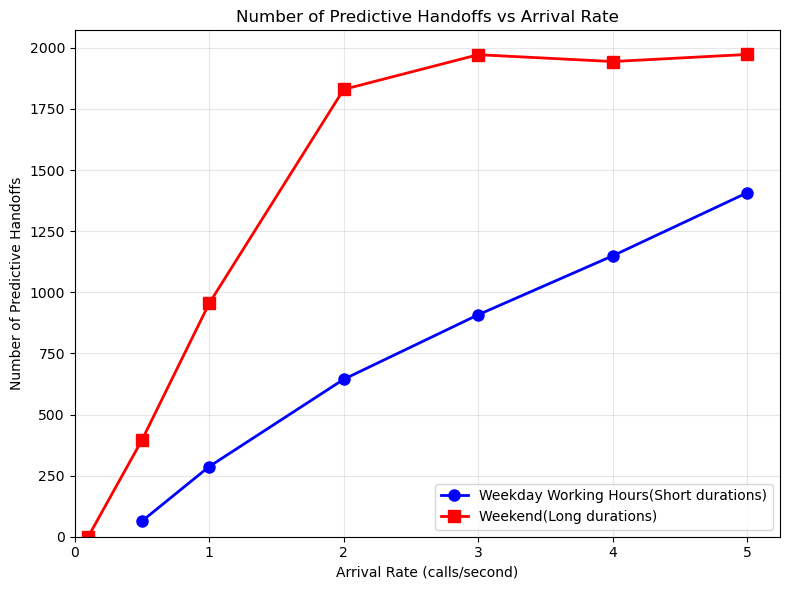


KEY INSIGHTS
• Mean call duration: 2.7x longer on weekends
• Median call duration: 2.5x longer on weekends
• 75th percentile: 2.7x longer on weekends
• Weekday: Median=170.4s, Q75=256.9s
• Weekend: Median=432.1s, Q75=690.8s
• 90% of weekday calls are under 350.7s
• 90% of weekend calls are under 1022.0s


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from IPython.display import display, HTML

# Load the results
with open('varyingduration2.pkl', 'rb') as f:
    all_results = pickle.load(f)

# Calculate overall statistics for each scenario
scenario_stats = {}

for scenario_name, results in all_results.items():
    df = pd.DataFrame(results)
    
    # Filter out any results with errors and ensure duration_stats exists
    valid_results = [r for r in results if 'error' not in r and 'duration_stats' in r]
    if not valid_results:
        print(f"Warning: No valid results with duration_stats for {scenario_name}")
        continue
        
    # Calculate overall statistics across all arrival rates
    scenario_stats[scenario_name] = {
        'scenario_type': 'Weekday Working Hours' if 'weekday' in scenario_name else 'Weekend',
        
        # Call durations with quartiles
        'mean_duration': np.mean([r['duration_stats']['mean_duration_seconds'] for r in valid_results]),
        'std_duration': np.std([r['duration_stats']['mean_duration_seconds'] for r in valid_results]),
        'min_duration': np.min([r['duration_stats']['min_duration_seconds'] for r in valid_results]),
        'max_duration': np.max([r['duration_stats']['max_duration_seconds'] for r in valid_results]),
        'q25_duration': np.mean([r['duration_stats']['q25_duration_seconds'] for r in valid_results]),
        'median_duration': np.mean([r['duration_stats']['median_duration_seconds'] for r in valid_results]),
        'q75_duration': np.mean([r['duration_stats']['q75_duration_seconds'] for r in valid_results]),
        'q90_duration': np.mean([r['duration_stats']['q90_duration_seconds'] for r in valid_results]),
        
        # For plotting
        'arrival_rates': df['arrival_rate_per_second'].tolist(),
        'blocking_probs': df['predictive_blocking_prob'].tolist(),
        'handoff_probs': df['predictive_handoff_prob'].tolist(),
        'num_handoffs': df['predictive_handoffs'].tolist()
    }

# Create call duration statistics table with quartiles
def create_duration_table():
    """Create a call duration statistics table with quartiles"""
    data = []
    for scenario_name, stats in scenario_stats.items():
        data.append({
            'Scenario': stats['scenario_type'],
            'Mean (s)': f"{stats['mean_duration']:.1f} ± {stats['std_duration']:.1f}",
            'Q25 (s)': f"{stats['q25_duration']:.1f}",
            'Median (s)': f"{stats['median_duration']:.1f}",
            'Q75 (s)': f"{stats['q75_duration']:.1f}",
            'Q90 (s)': f"{stats['q90_duration']:.1f}",
            'Min (s)': f"{stats['min_duration']:.1f}",
            'Max (s)': f"{stats['max_duration']:.1f}"
        })
    
    df_table = pd.DataFrame(data)
    return df_table

def create_duration_comparison_table():
    """Create a side-by-side duration comparison table with quartiles"""
    weekday_stats = next((stats for scenario, stats in scenario_stats.items() if 'weekday' in scenario), None)
    weekend_stats = next((stats for scenario, stats in scenario_stats.items() if 'weekend' in scenario), None)
    
    if not weekday_stats or not weekend_stats:
        return None
        
    comparison_data = {
        'Metric': [
            'Mean Duration (s)',
            'Q25 (25th Percentile)',
            'Median (50th Percentile)', 
            'Q75 (75th Percentile)',
            'Q90 (90th Percentile)',
            'Minimum Duration (s)',
            'Maximum Duration (s)'
        ],
        'Weekday Working Hours': [
            f"{weekday_stats['mean_duration']:.1f} ± {weekday_stats['std_duration']:.1f}",
            f"{weekday_stats['q25_duration']:.1f}",
            f"{weekday_stats['median_duration']:.1f}",
            f"{weekday_stats['q75_duration']:.1f}",
            f"{weekday_stats['q90_duration']:.1f}",
            f"{weekday_stats['min_duration']:.1f}",
            f"{weekday_stats['max_duration']:.1f}"
        ],
        'Weekend': [
            f"{weekend_stats['mean_duration']:.1f} ± {weekend_stats['std_duration']:.1f}",
            f"{weekend_stats['q25_duration']:.1f}",
            f"{weekend_stats['median_duration']:.1f}",
            f"{weekend_stats['q75_duration']:.1f}",
            f"{weekend_stats['q90_duration']:.1f}",
            f"{weekend_stats['min_duration']:.1f}",
            f"{weekend_stats['max_duration']:.1f}"
        ],
        'Difference': [
            f"{weekend_stats['mean_duration'] - weekday_stats['mean_duration']:+.1f}",
            f"{weekend_stats['q25_duration'] - weekday_stats['q25_duration']:+.1f}",
            f"{weekend_stats['median_duration'] - weekday_stats['median_duration']:+.1f}",
            f"{weekend_stats['q75_duration'] - weekday_stats['q75_duration']:+.1f}",
            f"{weekend_stats['q90_duration'] - weekday_stats['q90_duration']:+.1f}",
            f"{weekend_stats['min_duration'] - weekday_stats['min_duration']:+.1f}",
            f"{weekend_stats['max_duration'] - weekday_stats['max_duration']:+.1f}"
        ]
    }
    
    return pd.DataFrame(comparison_data)

# Display the tables
print("CALL DURATION STATISTICS ANALYSIS WITH QUARTILES")
print("=" * 80)

# Table 1: Detailed Duration Statistics for Each Scenario
print("\nDETAILED CALL DURATION STATISTICS BY SCENARIO")
print("-" * 80)
duration_table = create_duration_table()
display(HTML(duration_table.to_html(index=False, classes='table table-striped')))

# Table 2: Duration Comparison
print("\nCALL DURATION COMPARISON: WEEKDAY vs WEEKEND")
print("-" * 80)
comparison_table = create_duration_comparison_table()
if comparison_table is not None:
    display(HTML(comparison_table.to_html(index=False, classes='table table-striped')))

# Set custom colors for plots
PREDICTIVE_COLOR = '#2C89D4'
NON_PREDICTIVE_COLOR = '#DC143C'

# Plot 1: Blocking Probability (Predictive only - both scenarios)
plt.figure(figsize=(8, 6))
for scenario_name, stats in scenario_stats.items():
    label = 'Weekday Working Hours(Short durations)' if 'weekday' in scenario_name else 'Weekend(Long durations)'
    color = 'blue' if 'weekday' in scenario_name else 'red'
    marker = 'o' if 'weekday' in scenario_name else 's'
    
    # For weekday, filter out 0.1 arrival rate point
    if 'weekday' in scenario_name:
        # Filter out arrival rates <= 0.1
        filtered_rates = []
        filtered_probs = []
        for rate, prob in zip(stats['arrival_rates'], stats['blocking_probs']):
            if rate > 0.1:  # Only include rates greater than 0.1
                filtered_rates.append(rate)
                filtered_probs.append(prob)
        plt.plot(filtered_rates, filtered_probs, 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)
    else:
        plt.plot(stats['arrival_rates'], stats['blocking_probs'], 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)

plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel(' Blocking Probability')
plt.title(' Blocking Probability vs Arrival Rate')
plt.xlim(0)  # Start x-axis at 0
plt.ylim(0)  # Start y-axis at 0
plt.legend(loc='lower right')  # Changed to lower right
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Handoff Probability (Predictive only - both scenarios)
plt.figure(figsize=(8, 6))
for scenario_name, stats in scenario_stats.items():
    label = 'Weekday Working Hours(Short durations)' if 'weekday' in scenario_name else 'Weekend(Long durations)'
    color = 'blue' if 'weekday' in scenario_name else 'red'
    marker = 'o' if 'weekday' in scenario_name else 's'
    

    if 'weekday' in scenario_name:
        filtered_rates = []
        filtered_probs = []
        for rate, prob in zip(stats['arrival_rates'], stats['handoff_probs']):
            if rate > 0.1:  
                filtered_rates.append(rate)
                filtered_probs.append(prob)
        plt.plot(filtered_rates, filtered_probs, 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)
    else:
        plt.plot(stats['arrival_rates'], stats['handoff_probs'], 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)

plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('Satellite Handoff Probability')
plt.title('Satellite Handoff Probability vs Arrival Rate')
plt.xlim(0)  # Start x-axis at 0
plt.ylim(0)  # Start y-axis at 0
plt.legend(loc='lower right')  # Changed to lower right
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Number of Handoffs (Predictive only - both scenarios)
plt.figure(figsize=(8, 6))
for scenario_name, stats in scenario_stats.items():
    label = 'Weekday Working Hours(Short durations)' if 'weekday' in scenario_name else 'Weekend(Long durations)'
    color = 'blue' if 'weekday' in scenario_name else 'red'
    marker = 'o' if 'weekday' in scenario_name else 's'
    
   
    if 'weekday' in scenario_name:
        filtered_rates = []
        filtered_handoffs = []
        for rate, handoff in zip(stats['arrival_rates'], stats['num_handoffs']):
            if rate > 0.1: 
                filtered_rates.append(rate)
                filtered_handoffs.append(handoff)
        plt.plot(filtered_rates, filtered_handoffs, 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)
    else:
        plt.plot(stats['arrival_rates'], stats['num_handoffs'], 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)

plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('Number of Predictive Handoffs')
plt.title('Number of Predictive Handoffs vs Arrival Rate')
plt.xlim(0)  # Start x-axis at 0
plt.ylim(0)  # Start y-axis at 0
plt.legend(loc='lower right')  # Changed to lower right
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary insights with quartiles
print("\nKEY INSIGHTS")
print("=" * 70)
weekday_stats = next((stats for scenario, stats in scenario_stats.items() if 'weekday' in scenario), None)
weekend_stats = next((stats for scenario, stats in scenario_stats.items() if 'weekend' in scenario), None)

if weekday_stats and weekend_stats:
    mean_ratio = weekend_stats['mean_duration'] / weekday_stats['mean_duration']
    median_ratio = weekend_stats['median_duration'] / weekday_stats['median_duration']
    q75_ratio = weekend_stats['q75_duration'] / weekday_stats['q75_duration']
    
    insights = [
        f"Mean call duration: {mean_ratio:.1f}x longer on weekends",
        f"Median call duration: {median_ratio:.1f}x longer on weekends", 
        f"75th percentile: {q75_ratio:.1f}x longer on weekends",
        f"Weekday: Median={weekday_stats['median_duration']:.1f}s, Q75={weekday_stats['q75_duration']:.1f}s",
        f"Weekend: Median={weekend_stats['median_duration']:.1f}s, Q75={weekend_stats['q75_duration']:.1f}s",
        f"90% of weekday calls are under {weekday_stats['q90_duration']:.1f}s",
        f"90% of weekend calls are under {weekend_stats['q90_duration']:.1f}s"
    ]
    
    for insight in insights:
        print(f"• {insight}")

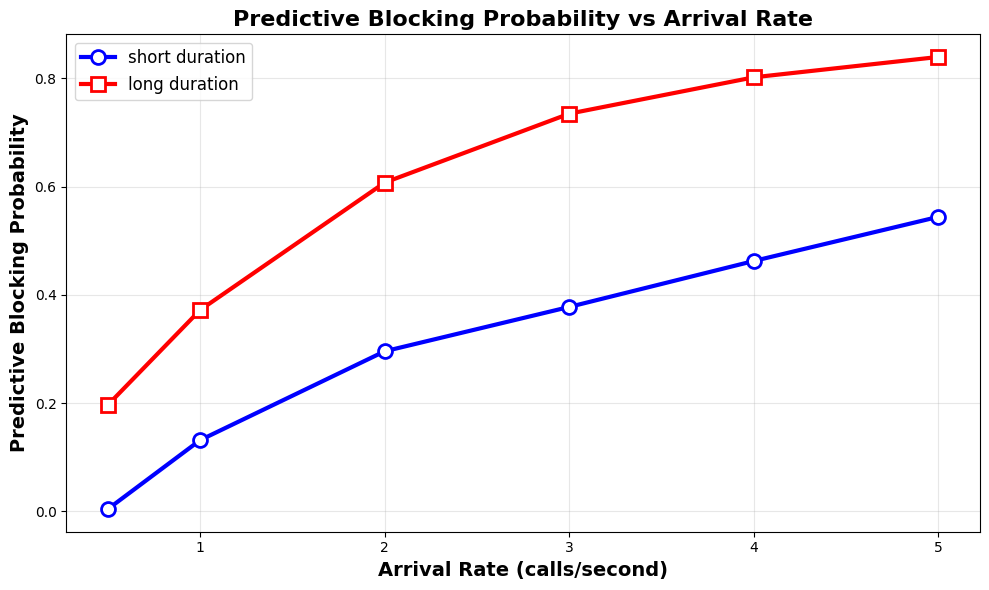

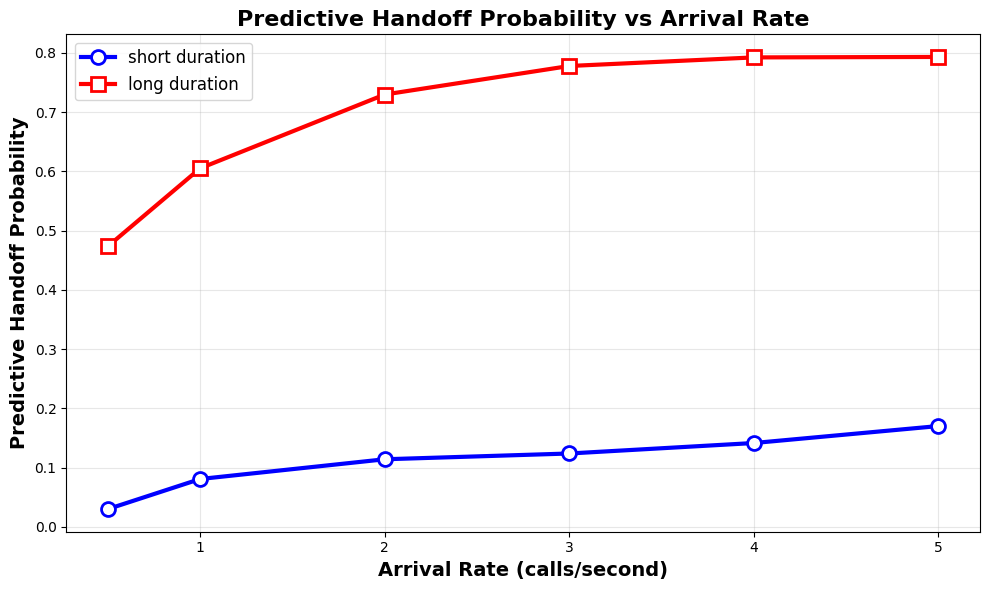

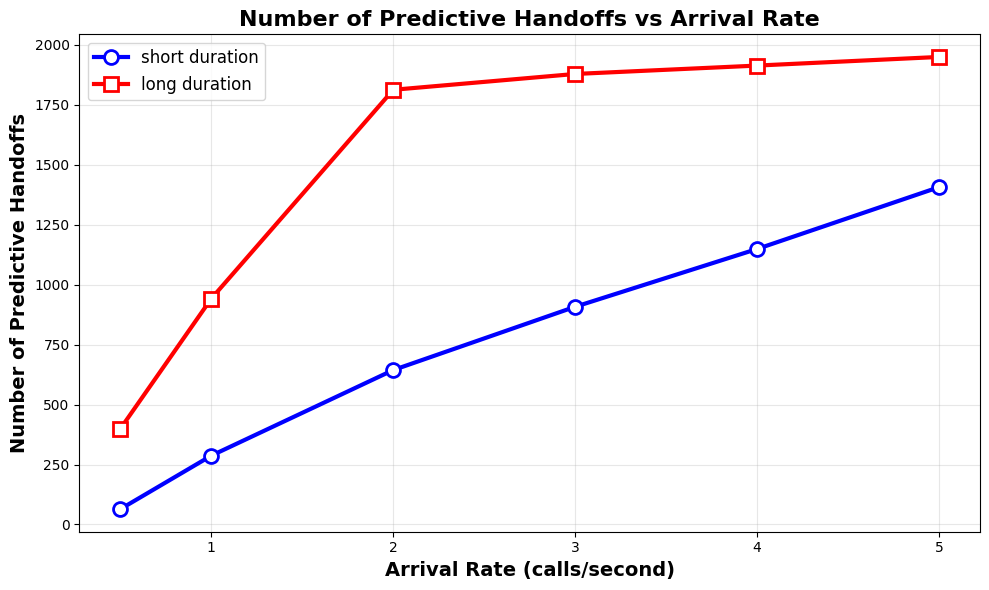

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np

# Load the results
with open('varyingduration.pkl', 'rb') as f:
    all_results = pickle.load(f)

# Individual plot for Blocking Probability
plt.figure(figsize=(10, 6))
for scenario_name, results in all_results.items():
    df = pd.DataFrame(results)
    arrival_rates = df['arrival_rate_per_second']
    blocking_probs = df['predictive_blocking_prob']
    
    label = 'short duration' if 'weekday' in scenario_name else 'long duration'
    color = 'blue' if 'weekday' in scenario_name else 'red'
    marker = 'o' if 'weekday' in scenario_name else 's'
    
    plt.plot(arrival_rates, blocking_probs, 
             marker=marker, color=color, linewidth=3, markersize=10, 
             label=label, markerfacecolor='white', markeredgewidth=2)

plt.xlabel('Arrival Rate (calls/second)', fontsize=14, fontweight='bold')
plt.ylabel('Predictive Blocking Probability', fontsize=14, fontweight='bold')
plt.title('Predictive Blocking Probability vs Arrival Rate', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

# Individual plot for Handoff Probability
plt.figure(figsize=(10, 6))
for scenario_name, results in all_results.items():
    df = pd.DataFrame(results)
    arrival_rates = df['arrival_rate_per_second']
    handoff_probs = df['predictive_handoff_prob']
    
    label = 'short duration' if 'weekday' in scenario_name else 'long duration'
    color = 'blue' if 'weekday' in scenario_name else 'red'
    marker = 'o' if 'weekday' in scenario_name else 's'
    
    plt.plot(arrival_rates, handoff_probs, 
             marker=marker, color=color, linewidth=3, markersize=10, 
             label=label, markerfacecolor='white', markeredgewidth=2)

plt.xlabel('Arrival Rate (calls/second)', fontsize=14, fontweight='bold')
plt.ylabel('Predictive Handoff Probability', fontsize=14, fontweight='bold')
plt.title('Predictive Handoff Probability vs Arrival Rate', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

# Individual plot for Number of Handoffs
plt.figure(figsize=(10, 6))
for scenario_name, results in all_results.items():
    df = pd.DataFrame(results)
    arrival_rates = df['arrival_rate_per_second']
    num_handoffs = df['predictive_handoffs']
    
    label = 'short duration' if 'weekday' in scenario_name else 'long duration'
    color = 'blue' if 'weekday' in scenario_name else 'red'
    marker = 'o' if 'weekday' in scenario_name else 's'
    
    plt.plot(arrival_rates, num_handoffs, 
             marker=marker, color=color, linewidth=3, markersize=10, 
             label=label, markerfacecolor='white', markeredgewidth=2)

plt.xlabel('Arrival Rate (calls/second)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Predictive Handoffs', fontsize=14, fontweight='bold')
plt.title('Number of Predictive Handoffs vs Arrival Rate', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

Total scenarios: 30
Satellite heights: [np.int64(1300), np.int64(1400), np.int64(1600)]
Arrival rates: [np.float64(0.3), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]

PLOT 1: All Metrics Comparison (Individual Plots)

PLOT 2: Predictive Metrics by Height


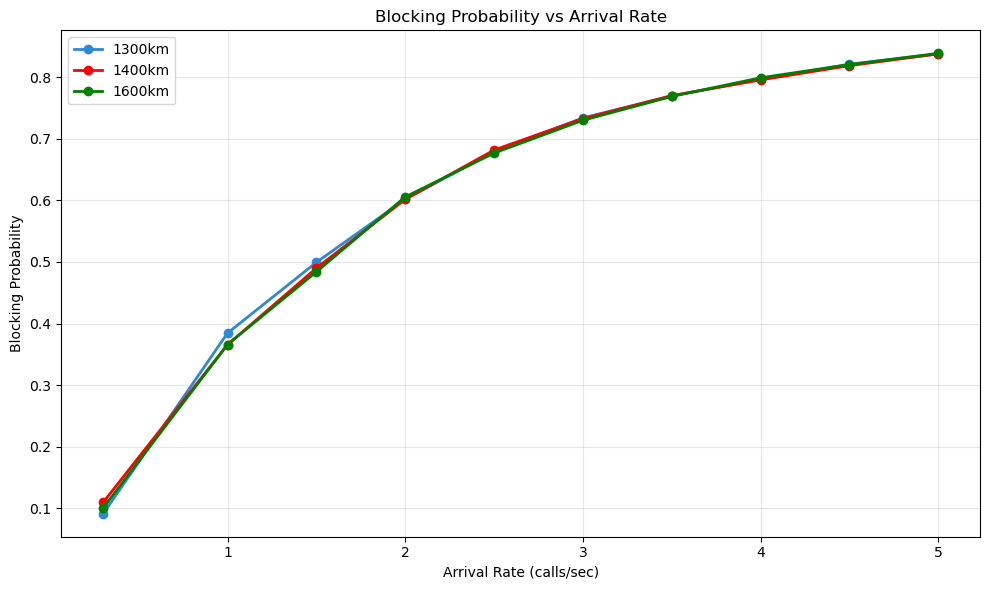

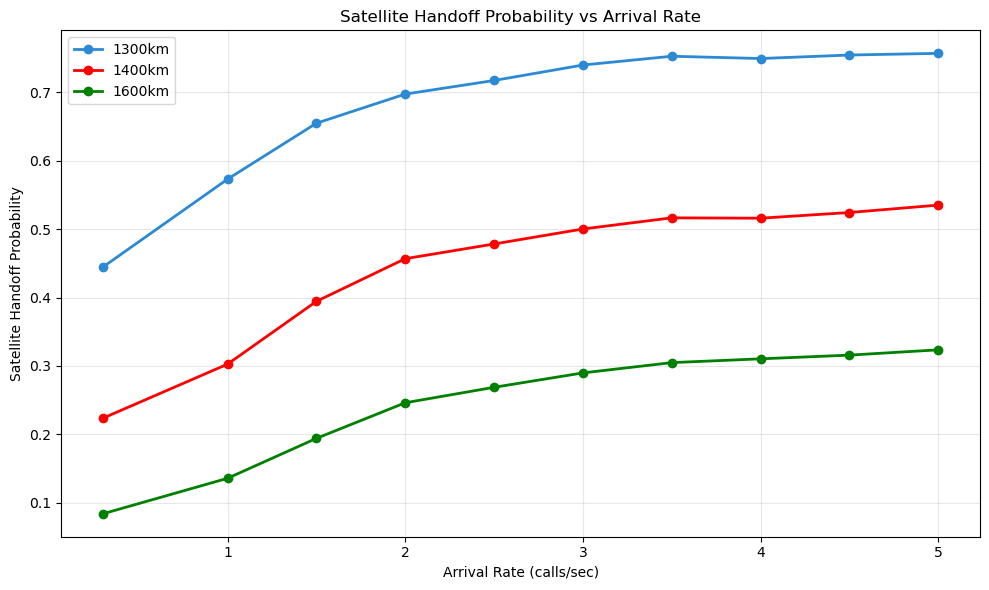

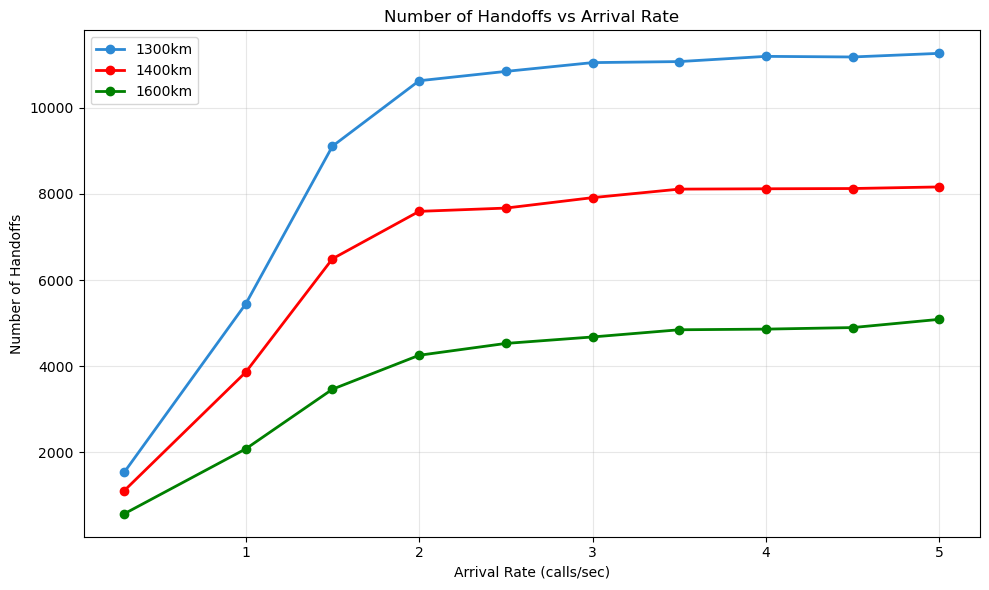


DETAILED RESULTS TABLE

DETAILED METRICS FOR ALL SCENARIOS

SATELLITE HEIGHT: 1300 km
----------------------------------------------------------------------------------------------------
Arrival Rate   Blocking P  Blocking NP    Handoff P   Handoff NP Handoffs P Handoffs NP
 (calls/sec)                                   Prob         Prob    Count    Count
----------------------------------------------------------------------------------------------------
         0.3       0.0915       0.0966       0.4448       0.8251     1543     4634
         1.0       0.3846       0.3732       0.5732       0.8102     5447     9227
         1.5       0.4994       0.4880       0.6550       0.7972     9108    10799
         2.0       0.6018       0.6019       0.6977       0.7951    10627    10972
         2.5       0.6789       0.6781       0.7176       0.7914    10844    11074
         3.0       0.7338       0.7322       0.7402       0.7918    11048    11008
         3.5       0.7696       0.7683    

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

def plot_all_metrics_individual(results):
    """Plot all metrics with different heights as individual plots"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    if df.empty:
        print("No data to plot!")
        return
    
    # Get unique heights and colors for each height
    heights = sorted(df['satellite_height_km'].unique())
    colors = ['#2C89D4', 'red', 'green', 'orange', 'purple'][:len(heights)]
    
    # Plot 1: Blocking Probability (All heights on same plot)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        
        # Predictive - solid lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_blocking_prob'], 
                'o-', color=color, linewidth=2, markersize=6, 
                label=f'P {height}km', alpha=0.8)
        
        # Non-Predictive - dashed lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_blocking_prob'], 
                's--', color=color, linewidth=2, markersize=6, 
                label=f'NP {height}km', alpha=0.8)
    
    plt.title('Blocking Probability vs Arrival Rate\n(All Satellite Heights)')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Blocking Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Handoff Probability (All heights on same plot)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        
        # Predictive - solid lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_handoff_prob'], 
                'o-', color=color, linewidth=2, markersize=6, 
                label=f'P {height}km', alpha=0.8)
        
        # Non-Predictive - dashed lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_handoff_prob'], 
                's--', color=color, linewidth=2, markersize=6, 
                label=f'NP {height}km', alpha=0.8)
    
    plt.title('Handoff Probability vs Arrival Rate\n(All Satellite Heights)')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Satellite Handoff Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Number of Handoffs (All heights on same plot)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        
        # Predictive - solid lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_handoffs'], 
                'o-', color=color, linewidth=2, markersize=6, 
                label=f'P {height}km', alpha=0.8)
        
        # Non-Predictive - dashed lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_handoffs'], 
                's--', color=color, linewidth=2, markersize=6, 
                label=f'NP {height}km', alpha=0.8)
    
    plt.title('Number of Handoffs vs Arrival Rate\n(All Satellite Heights)')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Number of Handoffs')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_height_comparison_individual(results):
    """Create individual plots showing how each metric varies with height for predictive vs non-predictive"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    heights = sorted(df['satellite_height_km'].unique())
    colors = ['#2C89D4', 'red', 'green'][:len(heights)]
    
    # Plot 1: Blocking Probability - Predictive (all heights)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_blocking_prob'], 
                'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    plt.title('Blocking Probability vs Arrival Rate')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Blocking Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Handoff Probability - Predictive (all heights)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_handoff_prob'], 
                'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    plt.title('Satellite Handoff Probability vs Arrival Rate')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Satellite Handoff Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Number of Handoffs - Predictive (all heights)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_handoffs'], 
                'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    plt.title('Number of Handoffs vs Arrival Rate')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Number of Handoffs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_detailed_table(results):
    """Create a detailed table showing all metrics for all scenarios"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    print(f"\n{'='*100}")
    print("DETAILED METRICS FOR ALL SCENARIOS")
    print(f"{'='*100}")
    
    # Sort by height and arrival rate
    df_sorted = df.sort_values(['satellite_height_km', 'arrival_rate_per_second'])
    
    for height in sorted(df_sorted['satellite_height_km'].unique()):
        print(f"\nSATELLITE HEIGHT: {height} km")
        print(f"{'-'*100}")
        print(f"{'Arrival Rate':>12} {'Blocking P':>12} {'Blocking NP':>12} {'Handoff P':>12} {'Handoff NP':>12} {'Handoffs P':>8} {'Handoffs NP':>8}")
        print(f"{'(calls/sec)':>12} {'':>12} {'':>12} {'Prob':>12} {'Prob':>12} {'Count':>8} {'Count':>8}")
        print(f"{'-'*100}")
        
        height_data = df_sorted[df_sorted['satellite_height_km'] == height]
        
        for _, row in height_data.iterrows():
            print(f"{row['arrival_rate_per_second']:>12.1f} "
                  f"{row['predictive_blocking_prob']:>12.4f} "
                  f"{row['nonpredictive_blocking_prob']:>12.4f} "
                  f"{row['predictive_handoff_prob']:>12.4f} "
                  f"{row['nonpredictive_handoff_prob']:>12.4f} "
                  f"{row['predictive_handoffs']:>8.0f} "
                  f"{row['nonpredictive_handoffs']:>8.0f}")

def show_all_plots_individual(results):
    """Display all plots as individual figures"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    print(f"Total scenarios: {len(df)}")
    print(f"Satellite heights: {sorted(df['satellite_height_km'].unique())}")
    print(f"Arrival rates: {sorted(df['arrival_rate_per_second'].unique())}")
    
    # Plot 1: All metrics comparison
    print("\nPLOT 1: All Metrics Comparison (Individual Plots)")
    #plot_all_metrics_individual(results)
    
    # Plot 2: Predictive metrics by height
    print("\nPLOT 2: Predictive Metrics by Height")
    plot_height_comparison_individual(results)
    
    # Table
    print("\nDETAILED RESULTS TABLE")
    create_detailed_table(results)

# Simple usage in Jupyter:
# Load results and show plots as individual figures
with open('satellite_height_results2.pkl', 'rb') as f:
    results = pickle.load(f)

show_all_plots_individual(results)

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np

# Load the results
with open('scenario_comparison_results1.pkl', 'rb') as f:
    all_results = pickle.load(f)

# Extract weekend evening data
weekend_results = all_results['weekend_evening_long']
df_weekend = pd.DataFrame(weekend_results)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Blocking Probability
ax1.plot(df_weekend['arrival_rate_per_second'], df_weekend['predictive_blocking_prob'], 
         marker='o', color='blue', linewidth=3, markersize=8, label='Predictive', markerfacecolor='white', markeredgewidth=2)
ax1.plot(df_weekend['arrival_rate_per_second'], df_weekend['nonpredictive_blocking_prob'], 
         marker='s', color='red', linewidth=3, markersize=8, label='Non-Predictive', markerfacecolor='white', markeredgewidth=2)

ax1.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Blocking Probability', fontsize=12, fontweight='bold')
ax1.set_title('Weekend Evening - Blocking Probability', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Plot 2: Handoff Probability
ax2.plot(df_weekend['arrival_rate_per_second'], df_weekend['predictive_handoff_prob'], 
         marker='o', color='blue', linewidth=3, markersize=8, label='Predictive', markerfacecolor='white', markeredgewidth=2)
ax2.plot(df_weekend['arrival_rate_per_second'], df_weekend['nonpredictive_handoff_prob_'], 
         marker='s', color='red', linewidth=3, markersize=8, label='Non-Predictive', markerfacecolor='white', markeredgewidth=2)

ax2.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Handoff Probability', fontsize=12, fontweight='bold')
ax2.set_title('Weekend Evening - Handoff Probability', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

# Plot 3: Number of Handoffs
ax3.plot(df_weekend['arrival_rate_per_second'], df_weekend['predictive_handoffs'], 
         marker='o', color='blue', linewidth=3, markersize=8, label='Predictive', markerfacecolor='white', markeredgewidth=2)
ax3.plot(df_weekend['arrival_rate_per_second'], df_weekend['nonpredictive_handoffs'], 
         marker='s', color='red', linewidth=3, markersize=8, label='Non-Predictive', markerfacecolor='white', markeredgewidth=2)

ax3.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Handoffs', fontsize=12, fontweight='bold')
ax3.set_title('Weekend Evening - Number of Handoffs', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=11)

# Adjust layout
plt.tight_layout(pad=3.0)

# Save the plot
plt.savefig('weekend_evening_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('weekend_evening_comparison.pdf', bbox_inches='tight')

# Show the plot
plt.show()

# Print numerical values
print("WEEKEND EVENING - NUMERICAL VALUES")
print("=" * 70)
print(f"{'Arrival Rate':<12} | {'Blocking Prob':<20} | {'Handoff Prob':<20} | {'Num Handoffs':<20}")
print(f"{'(calls/sec)':<12} | {'P':<8} {'NP':<8} {'Diff':<6} | {'P':<8} {'NP':<8} {'Diff':<6} | {'P':<8} {'NP':<8} {'Diff':<6}")
print("-" * 95)

for _, row in df_weekend.iterrows():
    arr_rate = row['arrival_rate_per_second']
    
    # Blocking probabilities
    p_block = row['predictive_blocking_prob']
    np_block = row['nonpredictive_blocking_prob']
    block_diff = p_block - np_block
    
    # Handoff probabilities
    p_handoff_prob = row['predictive_handoff_prob']
    np_handoff_prob = row['nonpredictive_handoff_prob_']
    handoff_prob_diff = p_handoff_prob - np_handoff_prob
    
    # Number of handoffs
    p_handoffs = row['predictive_handoffs']
    np_handoffs = row['nonpredictive_handoffs']
    handoffs_diff = p_handoffs - np_handoffs
    
    print(f"{arr_rate:<12.1f} | "
          f"{p_block:<8.3f} {np_block:<8.3f} {block_diff:<6.3f} | "
          f"{p_handoff_prob:<8.3f} {np_handoff_prob:<8.3f} {handoff_prob_diff:<6.3f} | "
          f"{p_handoffs:<8.0f} {np_handoffs:<8.0f} {handoffs_diff:<6.0f}")

FileNotFoundError: [Errno 2] No such file or directory: 'scenario_comparison_results1.pkl'

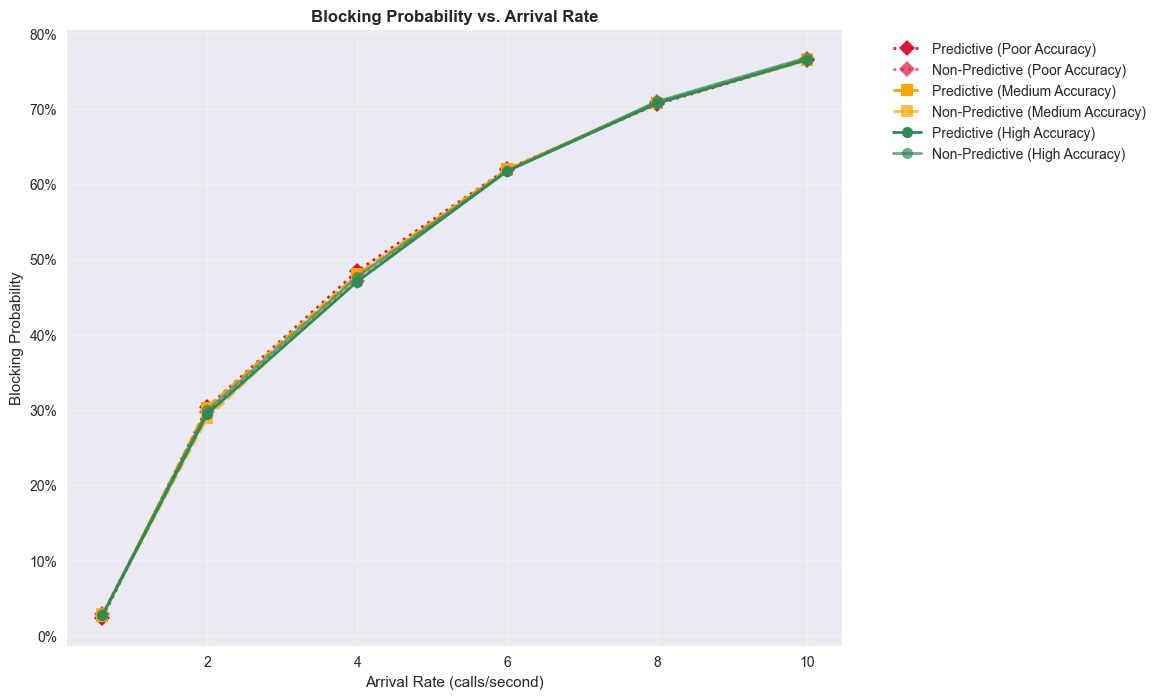

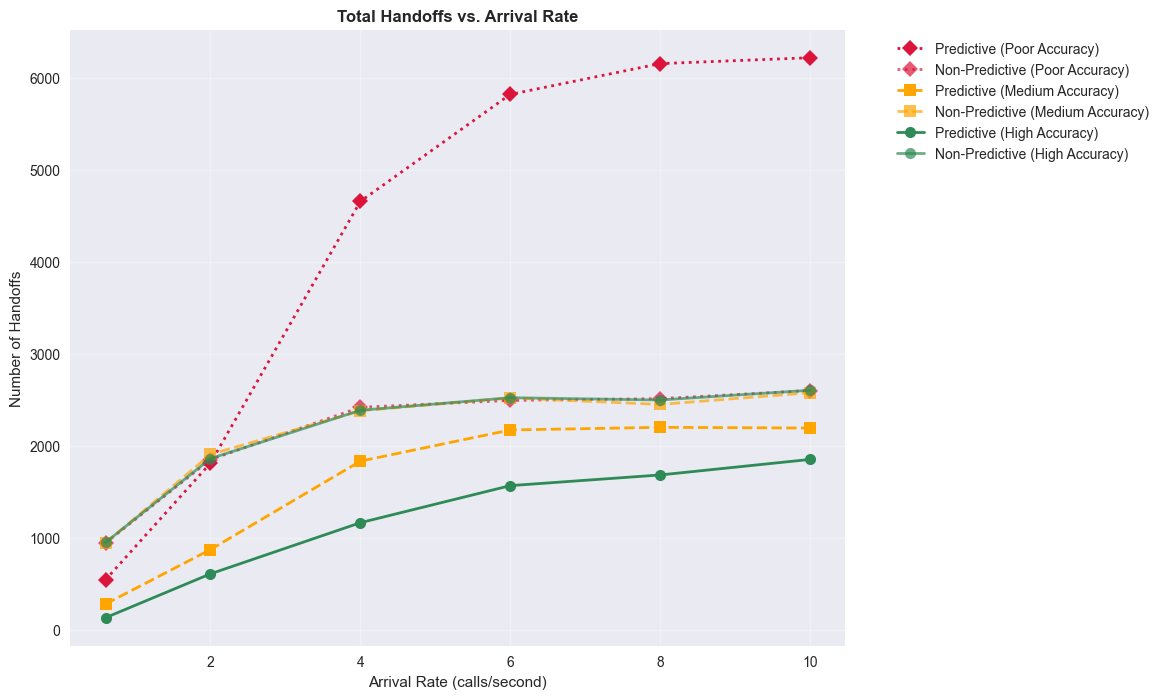

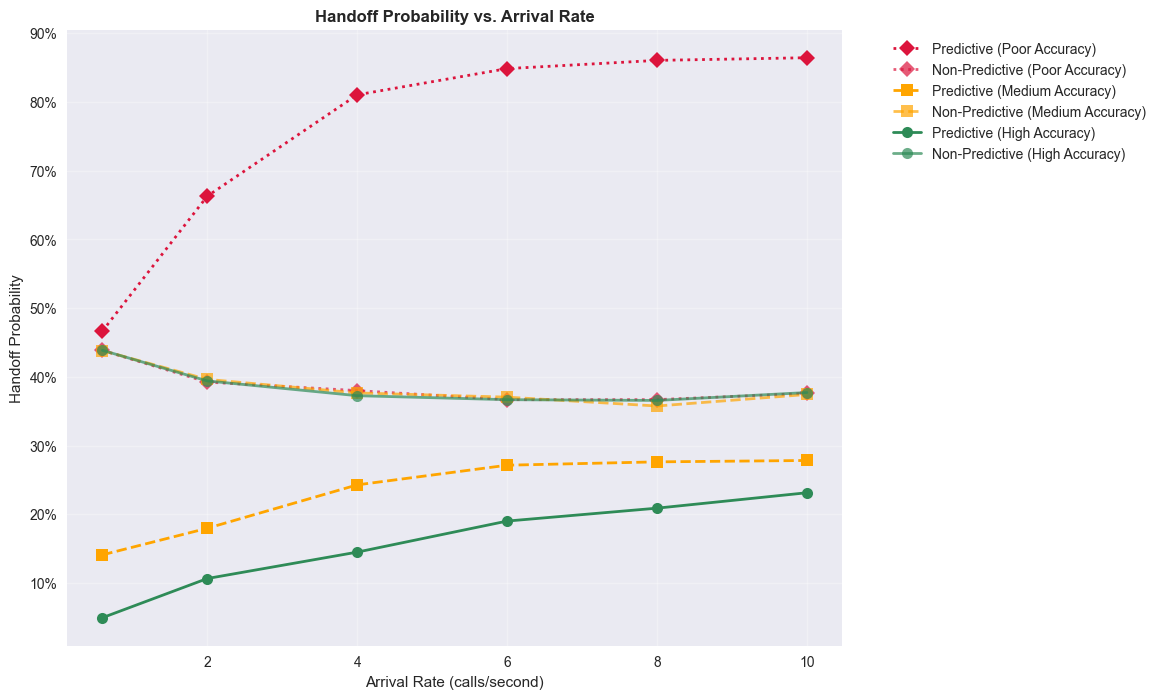


SUMMARY TABLE
 Accuracy Level  R² Score  Arrival Rate (calls/sec) Predictive Blocking Prob Non-Predictive Blocking Prob Blocking Improvement  Predictive Handoffs  Non-Predictive Handoffs Predictive Handoff Prob Non-Predictive Handoff Prob
  High Accuracy  0.991872                       0.6                    0.027                        0.027                 1.5%                  130                      948                   0.050                       0.438
  High Accuracy  0.991872                       2.0                    0.295                        0.299                 1.5%                  607                     1860                   0.107                       0.394
  High Accuracy  0.991872                       4.0                    0.470                        0.477                 1.3%                 1163                     2385                   0.145                       0.372
  High Accuracy  0.991872                       6.0                    0.617         

In [7]:
import pandas as pd
import pickle

# Load the results
with open('scenario_comparison_results1.pkl', 'rb') as f:
    all_results = pickle.load(f)

print("COMPLETE PERFORMANCE METRICS - PREDICTIVE vs NON-PREDICTIVE")
print("=" * 80)

for scenario_name, results in all_results.items():
    scenario_label = 'Weekday Working Hours' if 'weekday' in scenario_name else 'Weekend Evening'
    print(f"\n{scenario_label.upper()}")
    print("=" * 60)
    
    df = pd.DataFrame(results)
    
    # Print header
    print(f"{'Arrival Rate':<12} | {'Blocking Prob':<20} | {'Handoff Prob':<20} | {'Num Handoffs':<15}")
    print(f"{'(calls/sec)':<12} | {'P':<8} {'NP':<8} {'Diff':<6} | {'P':<8} {'NP':<8} {'Diff':<6} | {'P':<6} {'NP':<6} {'Diff':<6}")
    print("-" * 95)
    
    for _, row in df.iterrows():
        arr_rate = row['arrival_rate_per_second']
        
        # Blocking probabilities
        p_block = row['predictive_blocking_prob']
        np_block = row['nonpredictive_blocking_prob']
        block_diff = p_block - np_block
        
        # Handoff probabilities
        p_handoff_prob = row['predictive_handoff_prob']
        np_handoff_prob = row['nonpredictive_handoff_prob_']
        handoff_prob_diff = p_handoff_prob - np_handoff_prob
        
        # Number of handoffs
        p_handoffs = row['predictive_handoffs']
        np_handoffs = row['nonpredictive_handoffs']
        handoffs_diff = p_handoffs - np_handoffs
        
        print(f"{arr_rate:<12.1f} | "
              f"{p_block:<8.3f} {np_block:<8.3f} {block_diff:<6.3f} | "
              f"{p_handoff_prob:<8.3f} {np_handoff_prob:<8.3f} {handoff_prob_diff:<6.3f} | "
              f"{p_handoffs:<6.0f} {np_handoffs:<6.0f} {handoffs_diff:<6.0f}")

# Detailed breakdown for each scenario
print("\n\nDETAILED BREAKDOWN BY SCENARIO")
print("=" * 80)

for scenario_name, results in all_results.items():
    scenario_label = 'Weekday Working Hours' if 'weekday' in scenario_name else 'Weekend Evening'
    duration = results[0]['duration_hours'] if results else 0
    
    print(f"\n{scenario_label.upper()} ({duration:.1f} hours)")
    print("=" * 50)
    
    df = pd.DataFrame(results)
    
    for _, row in df.iterrows():
        arr_rate = row['arrival_rate_per_second']
        total_calls = row['total_calls']
        
        print(f"\nArrival Rate: {arr_rate} calls/sec | Total Calls: {total_calls}")
        print("-" * 50)
        
        # Blocking metrics
        p_block = row['predictive_blocking_prob']
        np_block = row['nonpredictive_blocking_prob']
        block_improvement = ((np_block - p_block) / np_block * 100) if np_block > 0 else 0
        
        print(f"BLOCKING PROBABILITY:")
        print(f"  Predictive:    {p_block:.3f} ({p_block*100:.1f}%)")
        print(f"  Non-Predictive: {np_block:.3f} ({np_block*100:.1f}%)")
        print(f"  Improvement:    {block_improvement:+.1f}%")
        
        # Handoff probability metrics
        p_handoff_prob = row['predictive_handoff_prob']
        np_handoff_prob = row['nonpredictive_handoff_prob_']
        handoff_prob_diff = p_handoff_prob - np_handoff_prob
        
        print(f"\nHANDOFF PROBABILITY:")
        print(f"  Predictive:    {p_handoff_prob:.3f} ({p_handoff_prob*100:.1f}%)")
        print(f"  Non-Predictive: {np_handoff_prob:.3f} ({np_handoff_prob*100:.1f}%)")
        print(f"  Difference:     {handoff_prob_diff:+.3f}")
        
        # Number of handoffs
        p_handoffs = row['predictive_handoffs']
        np_handoffs = row['nonpredictive_handoffs']
        handoffs_diff = p_handoffs - np_handoffs
        handoffs_ratio = p_handoffs / np_handoffs if np_handoffs > 0 else float('inf')
        
        print(f"\nNUMBER OF HANDOFFS:")
        print(f"  Predictive:    {p_handoffs:.0f}")
        print(f"  Non-Predictive: {np_handoffs:.0f}")
        print(f"  Difference:     {handoffs_diff:+.0f}")
        print(f"  Ratio (P/NP):   {handoffs_ratio:.2f}")
        
        # Additional metrics
        p_admitted = row['predictive_admitted']
        np_admitted = row['nonpredictive_admitted']
        admission_improvement = ((p_admitted - np_admitted) / np_admitted * 100) if np_admitted > 0 else 0
        
        print(f"\nADDITIONAL METRICS:")
        print(f"  Calls Admitted - P: {p_admitted}, NP: {np_admitted}")
        print(f"  Admission Improvement: {admission_improvement:+.1f}%")

# Summary comparison table
print("\n\nSUMMARY COMPARISON TABLE")
print("=" * 80)

summary_data = []

for scenario_name, results in all_results.items():
    scenario_label = 'Weekday Working Hours' if 'weekday' in scenario_name else 'Weekend Evening'
    
    for result in results:
        arr_rate = result['arrival_rate_per_second']
        
        summary_data.append({
            'Scenario': scenario_label,
            'Arrival_Rate': arr_rate,
            'P_Blocking': result['predictive_blocking_prob'],
            'NP_Blocking': result['nonpredictive_blocking_prob'],
            'P_Handoff_Prob': result['predictive_handoff_prob'],
            'NP_Handoff_Prob': result['nonpredictive_handoff_prob_'],
            'P_Handoffs': result['predictive_handoffs'],
            'NP_Handoffs': result['nonpredictive_handoffs'],
            'Blocking_Improvement': result['nonpredictive_blocking_prob'] - result['predictive_blocking_prob'],
            'Handoff_Prob_Diff': result['predictive_handoff_prob'] - result['nonpredictive_handoff_prob_'],
            'Handoffs_Diff': result['predictive_handoffs'] - result['nonpredictive_handoffs']
        })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Print summary in a clean format
print("\nAverage Performance Across All Arrival Rates:")
print("-" * 60)

avg_performance = summary_df.groupby('Scenario').mean()

for scenario in avg_performance.index:
    data = avg_performance.loc[scenario]
    print(f"\n{scenario}:")
    print(f"  Blocking Prob - P: {data['P_Blocking']:.3f}, NP: {data['NP_Blocking']:.3f}, Improvement: {data['Blocking_Improvement']:.3f}")
    print(f"  Handoff Prob  - P: {data['P_Handoff_Prob']:.3f}, NP: {data['NP_Handoff_Prob']:.3f}, Difference: {data['Handoff_Prob_Diff']:.3f}")
    print(f"  Num Handoffs  - P: {data['P_Handoffs']:.0f}, NP: {data['NP_Handoffs']:.0f}, Difference: {data['Handoffs_Diff']:.0f}")



COMPLETE PERFORMANCE METRICS - PREDICTIVE vs NON-PREDICTIVE

WEEKDAY WORKING HOURS
Arrival Rate | Blocking Prob        | Handoff Prob         | Num Handoffs   
(calls/sec)  | P        NP       Diff   | P        NP       Diff   | P      NP     Diff  
-----------------------------------------------------------------------------------------------
0.5          | 0.003    0.005    -0.002 | 0.113    0.371    -0.259 | 170    698    -528  
2.0          | 0.297    0.300    -0.003 | 0.253    0.336    -0.083 | 1163   1584   -421  
4.0          | 0.477    0.472    0.005  | 0.341    0.323    0.018  | 2461   2033   428   
6.0          | 0.615    0.616    -0.000 | 0.397    0.320    0.077  | 3184   2178   1006  
8.0          | 0.707    0.707    0.001  | 0.426    0.309    0.117  | 3400   2116   1284  

WEEKEND EVENING
Arrival Rate | Blocking Prob        | Handoff Prob         | Num Handoffs   
(calls/sec)  | P        NP       Diff   | P        NP       Diff   | P      NP     Diff  
--------------------

Total scenarios: 18
Satellite heights: [np.int64(1300), np.int64(1400), np.int64(1600)]
Arrival rates: [np.float64(0.3), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]

 PLOT 1: All Heights Comparison (Same Axes)


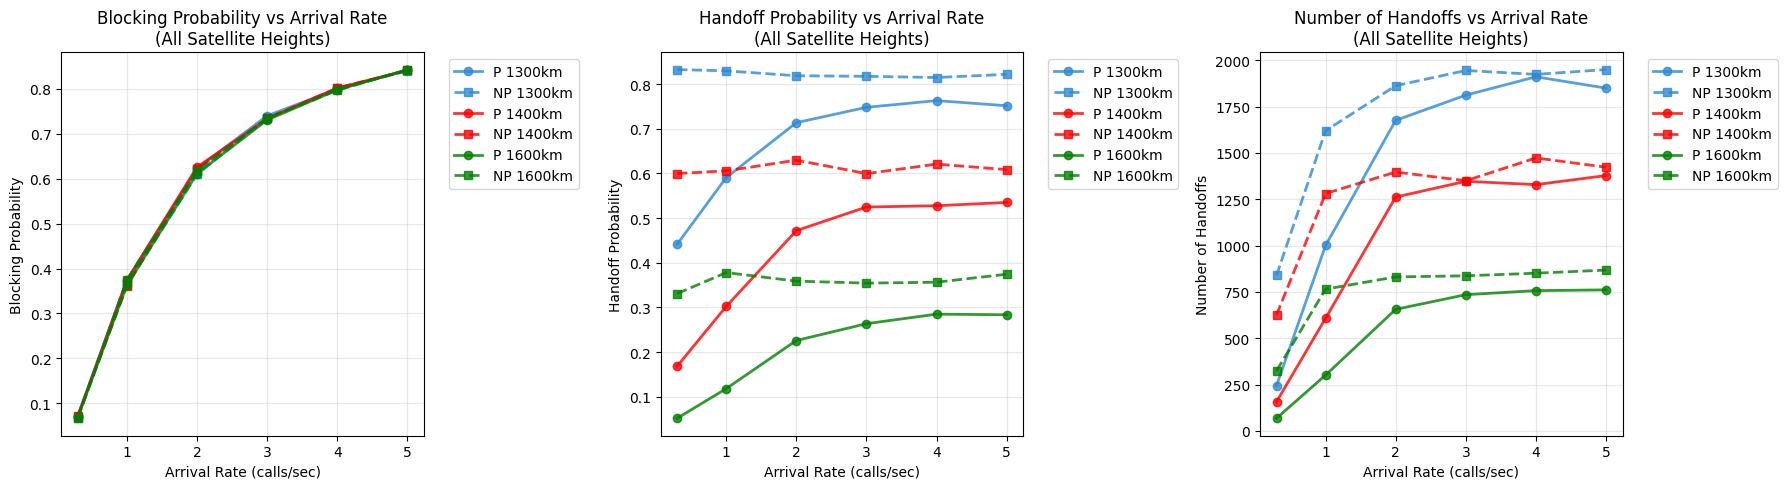


 PLOT 2: Predictive vs Non-Predictive Comparison


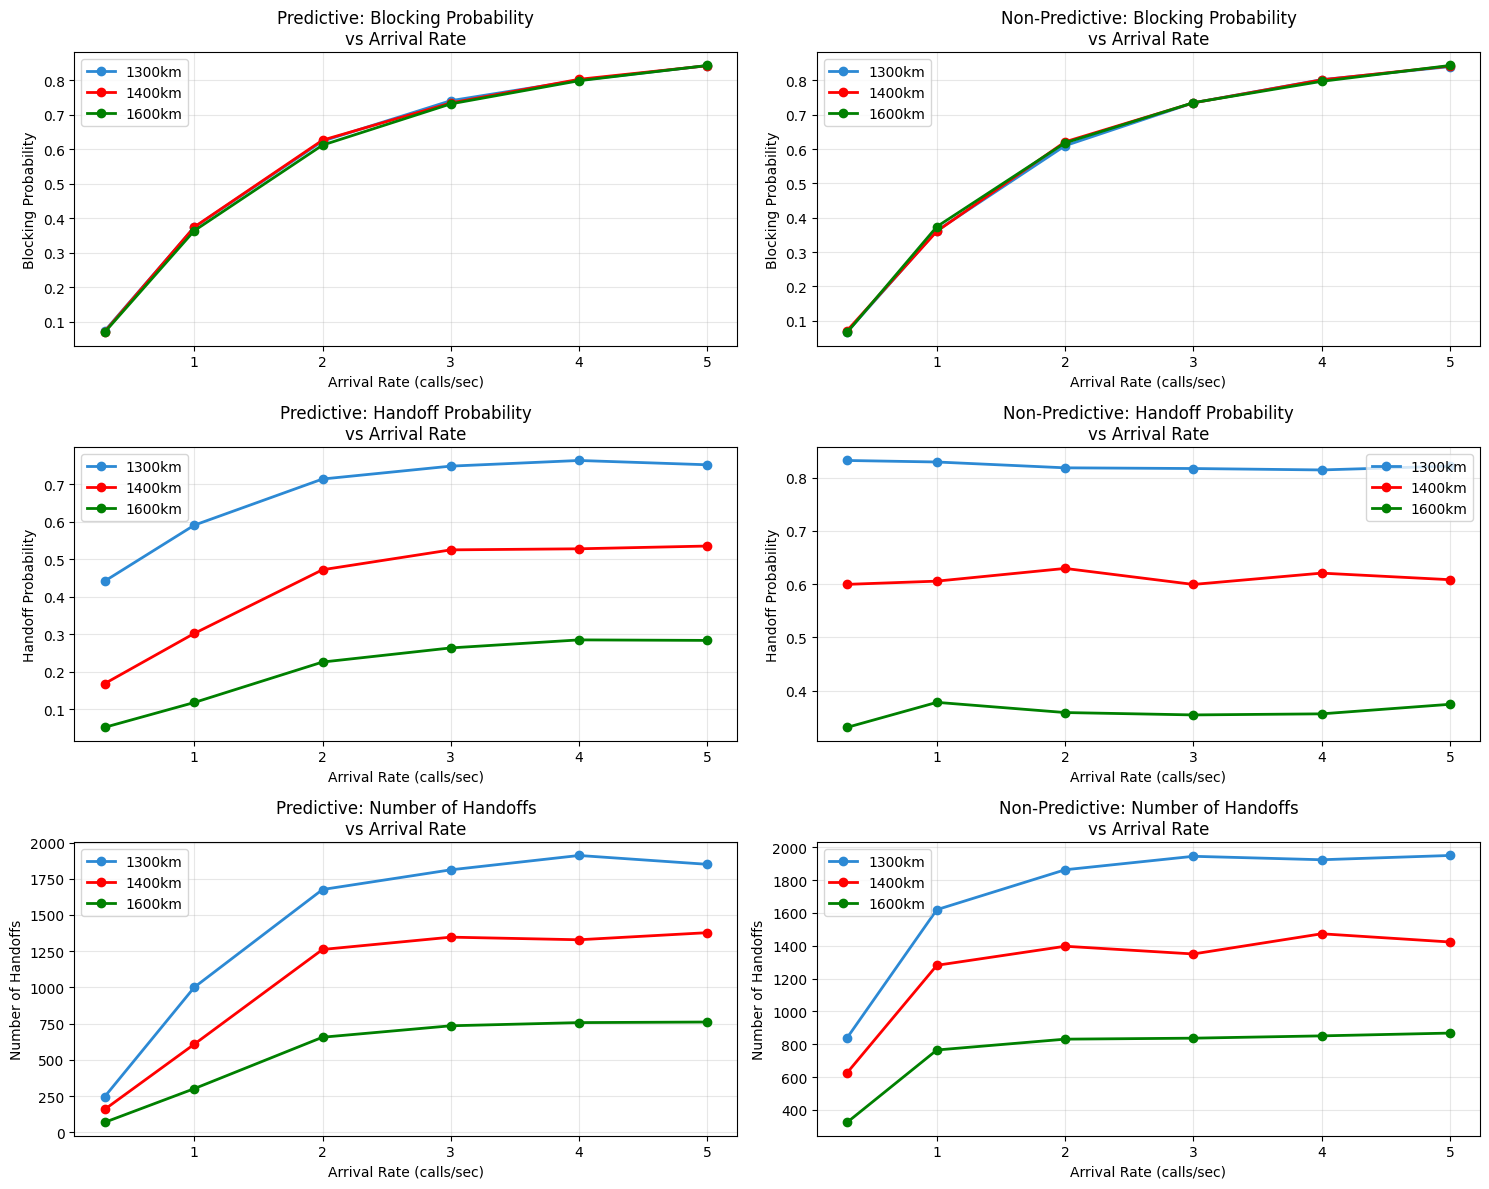


 DETAILED RESULTS TABLE

DETAILED METRICS FOR ALL SCENARIOS

SATELLITE HEIGHT: 1300 km
----------------------------------------------------------------------------------------------------
Arrival Rate   Blocking P  Blocking NP    Handoff P   Handoff NP Handoffs P Handoffs NP
 (calls/sec)                                   Prob         Prob    Count    Count
----------------------------------------------------------------------------------------------------
         0.3       0.0722       0.0677       0.4412       0.8323      244      839
         1.0       0.3733       0.3626       0.5906       0.8295     1001     1620
         2.0       0.6228       0.6097       0.7135       0.8185     1676     1863
         3.0       0.7401       0.7345       0.7478       0.8172     1812     1945
         4.0       0.7994       0.8018       0.7629       0.8146     1911     1924
         5.0       0.8416       0.8398       0.7514       0.8217     1850     1950

SATELLITE HEIGHT: 1400 km
--------------

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_all_metrics_same_axis(results):
    """Plot all metrics with different heights on the same axes for easy comparison"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    if df.empty:
        print("No data to plot!")
        return
    
    # Get unique heights and colors for each height
    heights = sorted(df['satellite_height_km'].unique())
    colors = ['#2C89D4', 'red', 'green', 'orange', 'purple'][:len(heights)]
    
    # Create a 1x3 grid of subplots for the 3 metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Blocking Probability (All heights on same plot)
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        
        # Predictive - solid lines
        axes[0].plot(height_data['arrival_rate_per_second'], height_data['predictive_blocking_prob'], 
                    'o-', color=color, linewidth=2, markersize=6, 
                    label=f'P {height}km', alpha=0.8)
        
        # Non-Predictive - dashed lines
        axes[0].plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_blocking_prob'], 
                    's--', color=color, linewidth=2, markersize=6, 
                    label=f'NP {height}km', alpha=0.8)
    
    axes[0].set_title('Blocking Probability vs Arrival Rate\n(All Satellite Heights)')
    axes[0].set_xlabel('Arrival Rate (calls/sec)')
    axes[0].set_ylabel('Blocking Probability')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Handoff Probability (All heights on same plot)
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        
        # Predictive - solid lines
        axes[1].plot(height_data['arrival_rate_per_second'], height_data['predictive_handoff_prob'], 
                    'o-', color=color, linewidth=2, markersize=6, 
                    label=f'P {height}km', alpha=0.8)
        
        # Non-Predictive - dashed lines
        axes[1].plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_handoff_prob'], 
                    's--', color=color, linewidth=2, markersize=6, 
                    label=f'NP {height}km', alpha=0.8)
    
    axes[1].set_title('Handoff Probability vs Arrival Rate\n(All Satellite Heights)')
    axes[1].set_xlabel('Arrival Rate (calls/sec)')
    axes[1].set_ylabel('Handoff Probability')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Number of Handoffs (All heights on same plot)
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        
        # Predictive - solid lines
        axes[2].plot(height_data['arrival_rate_per_second'], height_data['predictive_handoffs'], 
                    'o-', color=color, linewidth=2, markersize=6, 
                    label=f'P {height}km', alpha=0.8)
        
        # Non-Predictive - dashed lines
        axes[2].plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_handoffs'], 
                    's--', color=color, linewidth=2, markersize=6, 
                    label=f'NP {height}km', alpha=0.8)
    
    axes[2].set_title('Number of Handoffs vs Arrival Rate\n(All Satellite Heights)')
    axes[2].set_xlabel('Arrival Rate (calls/sec)')
    axes[2].set_ylabel('Number of Handoffs')
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_height_comparison_grid(results):
    """Create a grid showing how each metric varies with height for predictive vs non-predictive"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    # Create a 3x2 grid for comprehensive comparison
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    heights = sorted(df['satellite_height_km'].unique())
    colors = ['#2C89D4', 'red', 'green'][:len(heights)]
    
    # Plot 1: Blocking Probability - Predictive (all heights)
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        axes[0, 0].plot(height_data['arrival_rate_per_second'], height_data['predictive_blocking_prob'], 
                       'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    axes[0, 0].set_title('Predictive: Blocking Probability\nvs Arrival Rate')
    axes[0, 0].set_xlabel('Arrival Rate (calls/sec)')
    axes[0, 0].set_ylabel('Blocking Probability')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Blocking Probability - Non-Predictive (all heights)
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        axes[0, 1].plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_blocking_prob'], 
                       'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    axes[0, 1].set_title('Non-Predictive: Blocking Probability\nvs Arrival Rate')
    axes[0, 1].set_xlabel('Arrival Rate (calls/sec)')
    axes[0, 1].set_ylabel('Blocking Probability')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Handoff Probability - Predictive (all heights)
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        axes[1, 0].plot(height_data['arrival_rate_per_second'], height_data['predictive_handoff_prob'], 
                       'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    axes[1, 0].set_title('Predictive: Handoff Probability\nvs Arrival Rate')
    axes[1, 0].set_xlabel('Arrival Rate (calls/sec)')
    axes[1, 0].set_ylabel('Handoff Probability')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Handoff Probability - Non-Predictive (all heights)
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        axes[1, 1].plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_handoff_prob'], 
                       'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    axes[1, 1].set_title('Non-Predictive: Handoff Probability\nvs Arrival Rate')
    axes[1, 1].set_xlabel('Arrival Rate (calls/sec)')
    axes[1, 1].set_ylabel('Handoff Probability')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 5: Number of Handoffs - Predictive (all heights)
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        axes[2, 0].plot(height_data['arrival_rate_per_second'], height_data['predictive_handoffs'], 
                       'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    axes[2, 0].set_title('Predictive: Number of Handoffs\nvs Arrival Rate')
    axes[2, 0].set_xlabel('Arrival Rate (calls/sec)')
    axes[2, 0].set_ylabel('Number of Handoffs')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Plot 6: Number of Handoffs - Non-Predictive (all heights)
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        axes[2, 1].plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_handoffs'], 
                       'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    axes[2, 1].set_title('Non-Predictive: Number of Handoffs\nvs Arrival Rate')
    axes[2, 1].set_xlabel('Arrival Rate (calls/sec)')
    axes[2, 1].set_ylabel('Number of Handoffs')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_detailed_table(results):
    """Create a detailed table showing all metrics for all scenarios"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    print(f"\n{'='*100}")
    print("DETAILED METRICS FOR ALL SCENARIOS")
    print(f"{'='*100}")
    
    # Sort by height and arrival rate
    df_sorted = df.sort_values(['satellite_height_km', 'arrival_rate_per_second'])
    
    for height in sorted(df_sorted['satellite_height_km'].unique()):
        print(f"\nSATELLITE HEIGHT: {height} km")
        print(f"{'-'*100}")
        print(f"{'Arrival Rate':>12} {'Blocking P':>12} {'Blocking NP':>12} {'Handoff P':>12} {'Handoff NP':>12} {'Handoffs P':>8} {'Handoffs NP':>8}")
        print(f"{'(calls/sec)':>12} {'':>12} {'':>12} {'Prob':>12} {'Prob':>12} {'Count':>8} {'Count':>8}")
        print(f"{'-'*100}")
        
        height_data = df_sorted[df_sorted['satellite_height_km'] == height]
        
        for _, row in height_data.iterrows():
            print(f"{row['arrival_rate_per_second']:>12.1f} "
                  f"{row['predictive_blocking_prob']:>12.4f} "
                  f"{row['nonpredictive_blocking_prob']:>12.4f} "
                  f"{row['predictive_handoff_prob']:>12.4f} "
                  f"{row['nonpredictive_handoff_prob']:>12.4f} "
                  f"{row['predictive_handoffs']:>8.0f} "
                  f"{row['nonpredictive_handoffs']:>8.0f}")

def show_all_plots_fixed(results):
    """Display all plots in Jupyter Notebook - FIXED VERSION"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    print(f"Total scenarios: {len(df)}")
    print(f"Satellite heights: {sorted(df['satellite_height_km'].unique())}")
    print(f"Arrival rates: {sorted(df['arrival_rate_per_second'].unique())}")
    
    # Plot 1: All heights on same axes
    print("\n PLOT 1: All Heights Comparison (Same Axes)")
    plot_all_metrics_same_axis(results)
    
    # Plot 2: Grid comparison
    print("\n PLOT 2: Predictive vs Non-Predictive Comparison")
    plot_height_comparison_grid(results) 
    # Table
    print("\n DETAILED RESULTS TABLE")
    create_detailed_table(results)

# Simple usage in Jupyter:
# Load results and show plots (FIXED VERSION)
with open('satellite_height_results_detailed1.pkl', 'rb') as f:
    results = pickle.load(f)

show_all_plots_fixed(results)

In [ ]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_results(filename='service_type_different_rates_results.pkl'):
    """Load and separate the simulation results by service type"""
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame and filter errors
    df = pd.DataFrame(results)
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Separate by service type
    voice_df = df[df['service_type'] == 'voice'].sort_values('arrival_rate_per_second')
    video_df = df[df['service_type'] == 'video'].sort_values('arrival_rate_per_second')
    
    print("Results loaded:")
    print(f"Voice calls: {len(voice_df)} simulations")
    print(f"Video calls: {len(video_df)} simulations")
    
    return voice_df, video_df

def plot_voice_call_line_graphs(voice_df):
    """Plot line graphs for VOICE calls only"""
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    if len(voice_df) > 0:
        # Plot 1: Blocking Probability for Voice
        ax1.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_blocking_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='#2C89D4', linestyle='-',
                label='Predictive')
        
        ax1.plot(voice_df['arrival_rate_per_second'], 
                voice_df['nonpredictive_blocking_prob'], 
                marker='s', linewidth=3, markersize=8,
                color='red', linestyle='--',
                label='Non-Predictive')
        
        ax1.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Blocking Probability', fontsize=12, fontweight='bold')
        ax1.set_title('VOICE CALLS: Blocking Probability', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Handoff Probability for Voice
        ax2.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_handoff_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='#2C89D4', linestyle='-',
                label='Predictive')
        
        ax2.plot(voice_df['arrival_rate_per_second'], 
                voice_df['nonpredictive_handoff_prob_'], 
                marker='s', linewidth=3, markersize=8,
                color='red', linestyle='--',
                label='Non-Predictive')
        
        ax2.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Handoff Probability', fontsize=12, fontweight='bold')
        ax2.set_title('VOICE CALLS: Handoff Probability', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Absolute Number of Handoffs for Voice
        ax3.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_handoffs'], 
                marker='o', linewidth=3, markersize=8,
                color='#2C89D4', linestyle='-',
                label='Predictive')
        
        ax3.plot(voice_df['arrival_rate_per_second'], 
                voice_df['nonpredictive_handoffs'], 
                marker='s', linewidth=3, markersize=8,
                color='red', linestyle='--',
                label='Non-Predictive')
        
        ax3.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Number of Handoffs', fontsize=12, fontweight='bold')
        ax3.set_title('VOICE CALLS: Absolute Handoffs', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=11)
        ax3.grid(True, alpha=0.3)
    
    else:
        for ax in [ax1, ax2, ax3]:
            ax.text(0.5, 0.5, 'No Voice Call Data Available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=16)
            ax.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_video_call_line_graphs(video_df):
    """Plot line graphs for VIDEO calls only"""
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    if len(video_df) > 0:
        # Plot 1: Blocking Probability for Video
        ax1.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_blocking_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='purple', linestyle='-',
                label='Predictive')
        
        ax1.plot(video_df['arrival_rate_per_second'], 
                video_df['nonpredictive_blocking_prob'], 
                marker='s', linewidth=3, markersize=8,
                color='orange', linestyle='--',
                label='Non-Predictive')
        
        ax1.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Blocking Probability', fontsize=12, fontweight='bold')
        ax1.set_title('VIDEO CALLS: Blocking Probability', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Handoff Probability for Video
        ax2.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_handoff_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='purple', linestyle='-',
                label='Predictive')
        
        ax2.plot(video_df['arrival_rate_per_second'], 
                video_df['nonpredictive_handoff_prob_'], 
                marker='s', linewidth=3, markersize=8,
                color='orange', linestyle='--',
                label='Non-Predictive')
        
        ax2.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Handoff Probability', fontsize=12, fontweight='bold')
        ax2.set_title('VIDEO CALLS: Handoff Probability', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Absolute Number of Handoffs for Video
        ax3.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_handoffs'], 
                marker='o', linewidth=3, markersize=8,
                color='purple', linestyle='-',
                label='Predictive')
        
        ax3.plot(video_df['arrival_rate_per_second'], 
                video_df['nonpredictive_handoffs'], 
                marker='s', linewidth=3, markersize=8,
                color='orange', linestyle='--',
                label='Non-Predictive')
        
        ax3.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Number of Handoffs', fontsize=12, fontweight='bold')
        ax3.set_title('VIDEO CALLS: Absolute Handoffs', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=11)
        ax3.grid(True, alpha=0.3)
    
    else:
        for ax in [ax1, ax2, ax3]:
            ax.text(0.5, 0.5, 'No Video Call Data Available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=16)
            ax.set_xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_simple_comparison(voice_df, video_df):
    """Simple side-by-side line graph comparison"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Voice Calls - Row 0
    if len(voice_df) > 0:
        # Voice Blocking Probability
        axes[0,0].plot(voice_df['arrival_rate_per_second'], 
                      voice_df['predictive_blocking_prob'], 
                      marker='o', linewidth=2, color='#2C89D4', label='Predictive')
        axes[0,0].plot(voice_df['arrival_rate_per_second'], 
                      voice_df['nonpredictive_blocking_prob'], 
                      marker='s', linewidth=2, color='red', label='Non-Predictive')
        axes[0,0].set_title('Voice: Blocking Probability', fontweight='bold')
        axes[0,0].set_ylabel('Blocking Probability')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Voice Handoff Probability
        axes[0,1].plot(voice_df['arrival_rate_per_second'], 
                      voice_df['predictive_handoff_prob'], 
                      marker='o', linewidth=2, color='#2C89D4', label='Predictive')
        axes[0,1].plot(voice_df['arrival_rate_per_second'], 
                      voice_df['nonpredictive_handoff_prob_'], 
                      marker='s', linewidth=2, color='red', label='Non-Predictive')
        axes[0,1].set_title('Voice: Handoff Probability', fontweight='bold')
        axes[0,1].set_ylabel('Handoff Probability')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Voice Absolute Handoffs
        axes[0,2].plot(voice_df['arrival_rate_per_second'], 
                      voice_df['predictive_handoffs'], 
                      marker='o', linewidth=2, color='#2C89D4', label='Predictive')
        axes[0,2].plot(voice_df['arrival_rate_per_second'], 
                      voice_df['nonpredictive_handoffs'], 
                      marker='s', linewidth=2, color='red', label='Non-Predictive')
        axes[0,2].set_title('Voice: Absolute Handoffs', fontweight='bold')
        axes[0,2].set_ylabel('Number of Handoffs')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    
    # Video Calls - Row 1  
    if len(video_df) > 0:
        # Video Blocking Probability
        axes[1,0].plot(video_df['arrival_rate_per_second'], 
                      video_df['predictive_blocking_prob'], 
                      marker='o', linewidth=2, color='purple', label='Predictive')
        axes[1,0].plot(video_df['arrival_rate_per_second'], 
                      video_df['nonpredictive_blocking_prob'], 
                      marker='s', linewidth=2, color='orange', label='Non-Predictive')
        axes[1,0].set_title('Video: Blocking Probability', fontweight='bold')
        axes[1,0].set_xlabel('Arrival Rate (calls/sec)')
        axes[1,0].set_ylabel('Blocking Probability')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Video Handoff Probability
        axes[1,1].plot(video_df['arrival_rate_per_second'], 
                      video_df['predictive_handoff_prob'], 
                      marker='o', linewidth=2, color='purple', label='Predictive')
        axes[1,1].plot(video_df['arrival_rate_per_second'], 
                      video_df['nonpredictive_handoff_prob_'], 
                      marker='s', linewidth=2, color='orange', label='Non-Predictive')
        axes[1,1].set_title('Video: Handoff Probability', fontweight='bold')
        axes[1,1].set_xlabel('Arrival Rate (calls/sec)')
        axes[1,1].set_ylabel('Handoff Probability')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        # Video Absolute Handoffs
        axes[1,2].plot(video_df['arrival_rate_per_second'], 
                      video_df['predictive_handoffs'], 
                      marker='o', linewidth=2, color='purple', label='Predictive')
        axes[1,2].plot(video_df['arrival_rate_per_second'], 
                      video_df['nonpredictive_handoffs'], 
                      marker='s', linewidth=2, color='orange', label='Non-Predictive')
        axes[1,2].set_title('Video: Absolute Handoffs', fontweight='bold')
        axes[1,2].set_xlabel('Arrival Rate (calls/sec)')
        axes[1,2].set_ylabel('Number of Handoffs')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def generate_line_graphs_only(results_file='service_type_different_rates_results.pkl'):
    """Generate only line graphs for voice and video calls"""
    
    print("Loading simulation results...")
    voice_df, video_df = load_results(results_file)
    
    print("\nGenerating voice call line graphs...")
    plot_voice_call_line_graphs(voice_df)
    
    print("\nGenerating video call line graphs...")
    plot_video_call_line_graphs(video_df)
    
    print("\nGenerating simple comparison...")
    plot_simple_comparison(voice_df, video_df)
    
    print("\n" + "=" * 50)
    print("LINE GRAPHS GENERATED SUCCESSFULLY!")
    print("=" * 50)

# Run the line graph analysis
if __name__ == "__main__":
    generate_line_graphs_only()

group A only

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

def display_arrival_rate_results():
    """Load and display arrival rate experiment results in Jupyter"""
    
    # Load results
    try:
        with open('arrival_rate_resultsGroup.pkl', 'rb') as f:
            results = pickle.load(f)
        df_results = pd.DataFrame(results)
        print(" Results loaded successfully!")
    except FileNotFoundError:
        print("Results file not found. Run main.py first.")
        return None
    
    # Create styled display
    print("\n" + "="*80)
    print(" ARRIVAL RATE EXPERIMENT RESULTS")
    print("="*80)
    
    # Summary Table
    summary_cols = ['arrival_rate_per_second', 'total_calls', 
                   'predictive_blocking_prob', 'nonpredictive_blocking_prob',
                   'predictive_handoff_success_rate', 'nonpredictive_handoff_success_rate']
    
    summary_df = df_results[summary_cols].copy()
    summary_df.columns = ['Rate (/s)', 'Total Calls', 'Blocking P', 'Blocking NP', 
                         'Handoff Success P', 'Handoff Success NP']
    
    # Format percentages
    for col in ['Blocking P', 'Blocking NP', 'Handoff Success P', 'Handoff Success NP']:
        summary_df[col] = summary_df[col].apply(lambda x: f"{x:.1%}")
    
    display(HTML("<h3> Performance Summary</h3>"))
    display(summary_df.style.set_properties(**{'text-align': 'center'}) \
                          .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))
    
    return df_results

# Usage in Jupyter:
df_results = display_arrival_rate_results()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_multi_accuracy_results(results_file):
    """
    Plot blocking probability, number of handoffs, and handoff probability
    across different accuracy levels
    """
    
    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Remove any results with errors
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Satellite Network Performance vs. Arrival Rate and Prediction Accuracy', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Get unique accuracy levels and sort by R² score
    accuracy_levels = sorted(df['accuracy_label'].unique(), 
                           key=lambda x: df[df['accuracy_label'] == x]['r2_score'].iloc[0])
    
    # Define colors and markers for different accuracy levels
    colors = {'High Accuracy': '#2E8B57',    # Sea Green
              'Medium Accuracy': '#FFA500',   # Orange
              'Low Accuracy': '#FF6347',      # Tomato Red
              'Poor Accuracy': '#DC143C'}     # Crimson
    
    markers = {'High Accuracy': 'o', 
               'Medium Accuracy': 's', 
               'Low Accuracy': '^', 
               'Poor Accuracy': 'D'}
    
    line_styles = {'High Accuracy': '-', 
                   'Medium Accuracy': '--', 
                   'Low Accuracy': '-.', 
                   'Poor Accuracy': ':'}
    
    # Plot 1: Blocking Probability Comparison
    ax1 = axes[0, 0]
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        # Plot predictive controller
        ax1.plot(accuracy_data['arrival_rate_per_second'], 
                accuracy_data['predictive_blocking_prob'],
                label=f'Predictive ({accuracy})',
                color=colors.get(accuracy, '#000000'),
                marker=markers.get(accuracy, 'o'),
                linestyle=line_styles.get(accuracy, '-'),
                linewidth=2,
                markersize=8)
        
        # Plot non-predictive controller
        ax1.plot(accuracy_data['arrival_rate_per_second'], 
                accuracy_data['nonpredictive_blocking_prob'],
                label=f'Non-Predictive ({accuracy})',
                color=colors.get(accuracy, '#000000'),
                marker=markers.get(accuracy, 's'),
                linestyle=line_styles.get(accuracy, '--'),
                linewidth=2,
                markersize=8,
                alpha=0.7)
    
    ax1.set_xlabel('Arrival Rate (calls/second)')
    ax1.set_ylabel('Blocking Probability')
    ax1.set_title('Blocking Probability vs. Arrival Rate', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Plot 2: Number of Handoffs
    ax2 = axes[0, 1]
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        ax2.plot(accuracy_data['arrival_rate_per_second'], 
                accuracy_data['predictive_handoffs'],
                label=f'Predictive ({accuracy})',
                color=colors.get(accuracy, '#000000'),
                marker=markers.get(accuracy, 'o'),
                linestyle=line_styles.get(accuracy, '-'),
                linewidth=2,
                markersize=8)
        
        ax2.plot(accuracy_data['arrival_rate_per_second'], 
                accuracy_data['nonpredictive_handoffs'],
                label=f'Non-Predictive ({accuracy})',
                color=colors.get(accuracy, '#000000'),
                marker=markers.get(accuracy, 's'),
                linestyle=line_styles.get(accuracy, '--'),
                linewidth=2,
                markersize=8,
                alpha=0.7)
    
    ax2.set_xlabel('Arrival Rate (calls/second)')
    ax2.set_ylabel('Number of Handoffs')
    ax2.set_title('Total Handoffs vs. Arrival Rate', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 3: Handoff Probability
    ax3 = axes[1, 0]
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        ax3.plot(accuracy_data['arrival_rate_per_second'], 
                accuracy_data['predictive_handoff_prob'],
                label=f'Predictive ({accuracy})',
                color=colors.get(accuracy, '#000000'),
                marker=markers.get(accuracy, 'o'),
                linestyle=line_styles.get(accuracy, '-'),
                linewidth=2,
                markersize=8)
        
        ax3.plot(accuracy_data['arrival_rate_per_second'], 
                accuracy_data['nonpredictive_handoff_prob_'],
                label=f'Non-Predictive ({accuracy})',
                color=colors.get(accuracy, '#000000'),
                marker=markers.get(accuracy, 's'),
                linestyle=line_styles.get(accuracy, '--'),
                linewidth=2,
                markersize=8,
                alpha=0.7)
    
    ax3.set_xlabel('Arrival Rate (calls/second)')
    ax3.set_ylabel('Handoff Probability')
    ax3.set_title('Handoff Probability vs. Arrival Rate', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Plot 4: Performance Improvement (Blocking Probability Reduction)
    ax4 = axes[1, 1]
    improvement_data = []
    
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        # Calculate improvement: (NP_blocking - P_blocking) / NP_blocking
        improvement = ((accuracy_data['nonpredictive_blocking_prob'] - 
                       accuracy_data['predictive_blocking_prob']) / 
                      accuracy_data['nonpredictive_blocking_prob'])
        
        ax4.plot(accuracy_data['arrival_rate_per_second'], 
                improvement,
                label=f'{accuracy} (R²={accuracy_data["r2_score"].iloc[0]:.3f})',
                color=colors.get(accuracy, '#000000'),
                marker=markers.get(accuracy, 'o'),
                linestyle=line_styles.get(accuracy, '-'),
                linewidth=2,
                markersize=8)
    
    ax4.set_xlabel('Arrival Rate (calls/second)')
    ax4.set_ylabel('Blocking Probability Reduction')
    ax4.set_title('Predictive Controller Improvement\n(Relative Blocking Probability Reduction)', 
                 fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    plt.tight_layout()
    plt.show()
    
    return df

def plot_accuracy_comparison_at_fixed_rate(results_file, target_rate=6.0):
    """
    Plot comparison of all metrics at a fixed arrival rate across different accuracy levels
    """
    
    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Filter for target arrival rate (with some tolerance)
    rate_data = df[np.abs(df['arrival_rate_per_second'] - target_rate) < 0.1]
    
    if len(rate_data) == 0:
        print(f"No data found for arrival rate {target_rate}")
        return
    
    # Sort by R² score
    rate_data = rate_data.sort_values('r2_score')
    
    # Set up the plotting
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Performance Comparison Across Accuracy Levels at {target_rate} calls/second', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Colors for bars
    predictive_color = '#2E5F8A'
    nonpredictive_color = '#8B4513'
    
    # Plot 1: Blocking Probability by Accuracy Level
    ax1 = axes[0, 0]
    x_pos = np.arange(len(rate_data))
    width = 0.35
    
    ax1.bar(x_pos - width/2, rate_data['predictive_blocking_prob'], 
            width, label='Predictive', color=predictive_color, alpha=0.8)
    ax1.bar(x_pos + width/2, rate_data['nonpredictive_blocking_prob'], 
            width, label='Non-Predictive', color=nonpredictive_color, alpha=0.8)
    
    ax1.set_xlabel('Prediction Accuracy Level')
    ax1.set_ylabel('Blocking Probability')
    ax1.set_title('Blocking Probability by Accuracy Level', fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f"{row['accuracy_label']}\n(R²={row['r2_score']:.3f})" 
                        for _, row in rate_data.iterrows()], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Plot 2: Number of Handoffs by Accuracy Level
    ax2 = axes[0, 1]
    ax2.bar(x_pos - width/2, rate_data['predictive_handoffs'], 
            width, label='Predictive', color=predictive_color, alpha=0.8)
    ax2.bar(x_pos + width/2, rate_data['nonpredictive_handoffs'], 
            width, label='Non-Predictive', color=nonpredictive_color, alpha=0.8)
    
    ax2.set_xlabel('Prediction Accuracy Level')
    ax2.set_ylabel('Number of Handoffs')
    ax2.set_title('Total Handoffs by Accuracy Level', fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f"{row['accuracy_label']}\n(R²={row['r2_score']:.3f})" 
                        for _, row in rate_data.iterrows()], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Handoff Probability by Accuracy Level
    ax3 = axes[1, 0]
    ax3.bar(x_pos - width/2, rate_data['predictive_handoff_prob'], 
            width, label='Predictive', color=predictive_color, alpha=0.8)
    ax3.bar(x_pos + width/2, rate_data['nonpredictive_handoff_prob_'], 
            width, label='Non-Predictive', color=nonpredictive_color, alpha=0.8)
    
    ax3.set_xlabel('Prediction Accuracy Level')
    ax3.set_ylabel('Handoff Probability')
    ax3.set_title('Handoff Probability by Accuracy Level', fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f"{row['accuracy_label']}\n(R²={row['r2_score']:.3f})" 
                        for _, row in rate_data.iterrows()], rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Plot 4: Performance Improvement vs. Accuracy
    ax4 = axes[1, 1]
    improvement = ((rate_data['nonpredictive_blocking_prob'] - 
                   rate_data['predictive_blocking_prob']) / 
                  rate_data['nonpredictive_blocking_prob'])
    
    ax4.plot(range(len(rate_data)), improvement, 
             marker='o', linewidth=3, markersize=10, color='#228B22')
    
    ax4.set_xlabel('Prediction Accuracy Level')
    ax4.set_ylabel('Blocking Probability Reduction')
    ax4.set_title('Performance Improvement vs. Prediction Accuracy', fontweight='bold')
    ax4.set_xticks(range(len(rate_data)))
    ax4.set_xticklabels([f"{row['accuracy_label']}\n(R²={row['r2_score']:.3f})" 
                        for _, row in rate_data.iterrows()], rotation=45)
    ax4.grid(True, alpha=0.3)
    ax4.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Add value annotations on improvement plot
    for i, (idx, row) in enumerate(rate_data.iterrows()):
        ax4.annotate(f'{improvement[idx]:.1%}', 
                    (i, improvement[idx]),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def create_summary_table(results_file):
    """
    Create a summary table of the results
    """
    
    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Create summary table
    summary_data = []
    
    for accuracy in df['accuracy_label'].unique():
        accuracy_data = df[df['accuracy_label'] == accuracy]
        r2_score = accuracy_data['r2_score'].iloc[0]
        
        for rate in sorted(accuracy_data['arrival_rate_per_second'].unique()):
            rate_data = accuracy_data[accuracy_data['arrival_rate_per_second'] == rate].iloc[0]
            
            summary_data.append({
                'Accuracy Level': accuracy,
                'R² Score': r2_score,
                'Arrival Rate (calls/sec)': rate,
                'Predictive Blocking Prob': f"{rate_data['predictive_blocking_prob']:.3f}",
                'Non-Predictive Blocking Prob': f"{rate_data['nonpredictive_blocking_prob']:.3f}",
                'Blocking Improvement': f"{(rate_data['nonpredictive_blocking_prob'] - rate_data['predictive_blocking_prob']) / rate_data['nonpredictive_blocking_prob']:.1%}",
                'Predictive Handoffs': int(rate_data['predictive_handoffs']),
                'Non-Predictive Handoffs': int(rate_data['nonpredictive_handoffs']),
                'Predictive Handoff Prob': f"{rate_data['predictive_handoff_prob']:.3f}",
                'Non-Predictive Handoff Prob': f"{rate_data['nonpredictive_handoff_prob_']:.3f}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Usage example:
if __name__ == "__main__":
    # Replace with your actual results file name
    results_file = "arrival_rate_results_multiaccuracy_20250811_103000.pkl"
    
    try:
        # Plot all results
        df = plot_multi_accuracy_results(results_file)
        
        # Plot fixed rate comparison (choose a rate that exists in your data)
        plot_accuracy_comparison_at_fixed_rate(results_file, target_rate=6.0)
        
        # Create and display summary table
        summary_table = create_summary_table(results_file)
        print("\n" + "="*100)
        print("SUMMARY TABLE")
        print("="*100)
        print(summary_table.to_string(index=False))
        
        # Save summary table to CSV
        summary_table.to_csv('simulation_results_summary.csv', index=False)
        print(f"\nSummary table saved to 'simulation_results_summary.csv'")
        
    except FileNotFoundError:
        print(f"Results file '{results_file}' not found.")
        print("Available files:")
        import glob
        result_files = glob.glob("arrival_rate_results_multiaccuracy_*.pkl")
        for file in result_files:
            print(f"  - {file}")

In [ ]:
#Group A

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the saved results
with open('arrival_rate_results_multiple_groups.pkl', 'rb') as f:
    results = pickle.load(f)

# Group results by configuration for better readability
results_by_config = {}
for result in results:
    config_name = result['config_name']
    if config_name not in results_by_config:
        results_by_config[config_name] = []
    results_by_config[config_name].append(result)

# Define metrics to plot
metrics = [
    ('predictive_blocking_prob', 'Predictive Blocking Probability'),
    ('nonpredictive_blocking_prob', 'Non-Predictive Blocking Probability'),
    ('predictive_handoff_attempt_prob', 'Predictive Handoff Attempt Probability'),
    ('nonpredictive_handoff_prob_attempt_prob', 'Non-Predictive Handoff Attempt Probability'),
    ('predictive_handoff_success_rate', 'Predictive Handoff Success Rate'),
    ('nonpredictive_handoff_success_rate', 'Non-Predictive Handoff Success Rate')
]

# Define the arrival rates to plot against
arrival_rates = [1, 2, 3, 4, 5, 6, 7,8]

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 6 * len(metrics)))
fig.tight_layout(pad=6.0)

# Plot each metric
for idx, (metric, label) in enumerate(metrics):
    ax = axes[idx]
    
    # Initialize a dictionary to hold the data for each group configuration
    group_data = {config_name: [] for config_name in results_by_config.keys()}
    
    # Collect the data for each arrival rate for each configuration
    for config_name, config_results in results_by_config.items():
        for result in config_results:
            if 'error' not in result:
                # Find the corresponding result for each arrival rate
                if result['arrival_rate_per_second'] in arrival_rates:
                    group_data[config_name].append(result[metric])
    
    # Plot the data for each configuration
    for config_name, data in group_data.items():
        ax.plot(arrival_rates, data, label=config_name, marker='o')

    # Customize the plot
    ax.set_title(label)
    ax.set_xlabel('Arrival Rate (calls/second)')
    ax.set_ylabel(label)
    ax.legend()

# Show the plots
plt.show()


In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Load the results (replace with your path to the file)
results_file = 'arrival_rate_results_multiple_groups.pkl'

# Load the results
with open(results_file, 'rb') as f:
    results = pickle.load(f)

# Convert results into a pandas DataFrame for easier manipulation
df_results = pd.DataFrame(results)

# Inspect the DataFrame to see the columns available
print("Columns in the DataFrame:")
print(df_results.columns)

# Safely filter out any erroneous rows (we'll check if 'arrival_rate_per_second' is valid)
df_results_clean = df_results[df_results['arrival_rate_per_second'].notna()]

# Plotting: Blocking Probability vs. Arrival Rate
def plot_blocking_prob(df):
    # Group by configuration name and arrival rate
    grouped = df.groupby(['config_name', 'arrival_rate_per_second']).agg(
        predictive_blocking_prob=('predictive_blocking_prob', 'mean'),
        nonpredictive_blocking_prob=('nonpredictive_blocking_prob', 'mean')
    ).reset_index()

    plt.figure(figsize=(10, 6))

    # Plotting each group's blocking probability for predictive and nonpredictive
    for config_name in grouped['config_name'].unique():
        group_data = grouped[grouped['config_name'] == config_name]
        plt.plot(group_data['arrival_rate_per_second'], group_data['predictive_blocking_prob'], label=f'{config_name} - Predictive', marker='o')
        plt.plot(group_data['arrival_rate_per_second'], group_data['nonpredictive_blocking_prob'], label=f'{config_name} - Non-Predictive', marker='x')

    plt.title("Blocking Probability vs Arrival Rate")
    plt.xlabel("Arrival Rate (calls per second)")
    plt.ylabel("Blocking Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting: Handoff Attempt Probability vs. Arrival Rate
def plot_handoff_prob(df):
    # Group by configuration name and arrival rate
    grouped = df.groupby(['config_name', 'arrival_rate_per_second']).agg(
        predictive_handoff_attempt_prob=('predictive_handoff_attempt_prob', 'mean'),
        nonpredictive_handoff_prob_attempt_prob=('nonpredictive_handoff_prob_attempt_prob', 'mean')
    ).reset_index()

    plt.figure(figsize=(10, 6))

    # Plotting each group's handoff attempt probability for predictive and nonpredictive
    for config_name in grouped['config_name'].unique():
        group_data = grouped[grouped['config_name'] == config_name]
        plt.plot(group_data['arrival_rate_per_second'], group_data['predictive_handoff_attempt_prob'], label=f'{config_name} - Predictive', marker='o')
        plt.plot(group_data['arrival_rate_per_second'], group_data['nonpredictive_handoff_prob_attempt_prob'], label=f'{config_name} - Non-Predictive', marker='x')

    plt.title("Handoff Attempt Probability vs Arrival Rate")
    plt.xlabel("Arrival Rate (calls per second)")
    plt.ylabel("Handoff Attempt Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting: Total Calls vs. Arrival Rate
def plot_total_calls(df):
    # Group by configuration name and arrival rate
    grouped = df.groupby(['config_name', 'arrival_rate_per_second']).agg(
        total_calls=('total_calls', 'sum')
    ).reset_index()

    plt.figure(figsize=(10, 6))

    # Plotting total calls for each configuration
    for config_name in grouped['config_name'].unique():
        group_data = grouped[grouped['config_name'] == config_name]
        plt.plot(group_data['arrival_rate_per_second'], group_data['total_calls'], label=f'{config_name}', marker='o')

    plt.title("Total Calls vs Arrival Rate")
    plt.xlabel("Arrival Rate (calls per second)")
    plt.ylabel("Total Calls")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting functions to display results
plot_blocking_prob(df_results_clean)
plot_handoff_prob(df_results_clean)
plot_total_calls(df_results_clean)


In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Load the results (replace with your path to the file)
results_file = 'arrival_rate_results_multiple_groups.pkl'

# Load the results
with open(results_file, 'rb') as f:
    results = pickle.load(f)

# Convert results into a pandas DataFrame for easier manipulation
df_results = pd.DataFrame(results)

# Inspect the DataFrame to see the columns available
print("Columns in the DataFrame:")
print(df_results.columns)

# Safely filter out any erroneous rows (we'll check if 'arrival_rate_per_second' is valid)
df_results_clean = df_results[df_results['arrival_rate_per_second'].notna()]

# Calculate Success Rates and Handoff Failure Rates (from induced drops)
df_results_clean['predictive_success_rate'] = 1 - df_results_clean['predictive_handoff_failure_prob']
df_results_clean['nonpredictive_success_rate'] = 1 - df_results_clean['nonpredictive_handoff_failure_prob']

# Calculate Handoff Failure Rate based on handoff-induced drops
df_results_clean['predictive_handoff_failure_rate'] = (
    df_results_clean['predictive_handoff_induced_drops'] / 
    df_results_clean['predictive_handoff_attempts']
)

df_results_clean['nonpredictive_handoff_failure_rate'] = (
    df_results_clean['nonpredictive_handoff_induced_drops'] / 
    df_results_clean['nonpredictive_handoff_attempts']
)

# Plotting: Blocking Probability vs. Arrival Rate
def plot_blocking_prob(df):
    # Group by configuration name and arrival rate
    grouped = df.groupby(['config_name', 'arrival_rate_per_second']).agg(
        predictive_blocking_prob=('predictive_blocking_prob', 'mean'),
        nonpredictive_blocking_prob=('nonpredictive_blocking_prob', 'mean')
    ).reset_index()

    plt.figure(figsize=(10, 6))

    # Plotting each group's blocking probability for predictive and nonpredictive
    for config_name in grouped['config_name'].unique():
        group_data = grouped[grouped['config_name'] == config_name]
        plt.plot(group_data['arrival_rate_per_second'], group_data['predictive_blocking_prob'], label=f'{config_name} - Predictive', marker='o')
        plt.plot(group_data['arrival_rate_per_second'], group_data['nonpredictive_blocking_prob'], label=f'{config_name} - Non-Predictive', marker='x')

    plt.title("Blocking Probability vs Arrival Rate")
    plt.xlabel("Arrival Rate (calls per second)")
    plt.ylabel("Blocking Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting: Handoff Attempt Probability vs. Arrival Rate
def plot_handoff_prob(df):
    # Group by configuration name and arrival rate
    grouped = df.groupby(['config_name', 'arrival_rate_per_second']).agg(
        predictive_handoff_attempt_prob=('predictive_handoff_attempt_prob', 'mean'),
        nonpredictive_handoff_prob_attempt_prob=('nonpredictive_handoff_prob_attempt_prob', 'mean')
    ).reset_index()

    plt.figure(figsize=(10, 6))

    # Plotting each group's handoff attempt probability for predictive and nonpredictive
    for config_name in grouped['config_name'].unique():
        group_data = grouped[grouped['config_name'] == config_name]
        plt.plot(group_data['arrival_rate_per_second'], group_data['predictive_handoff_attempt_prob'], label=f'{config_name} - Predictive', marker='o')
        plt.plot(group_data['arrival_rate_per_second'], group_data['nonpredictive_handoff_prob_attempt_prob'], label=f'{config_name} - Non-Predictive', marker='x')

    plt.title("Handoff Attempt Probability vs Arrival Rate")
    plt.xlabel("Arrival Rate (calls per second)")
    plt.ylabel("Handoff Attempt Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting: Success Rate vs. Arrival Rate
def plot_success_rate(df):
    # Group by configuration name and arrival rate
    grouped = df.groupby(['config_name', 'arrival_rate_per_second']).agg(
        predictive_success_rate=('predictive_success_rate', 'mean'),
        nonpredictive_success_rate=('nonpredictive_success_rate', 'mean')
    ).reset_index()

    plt.figure(figsize=(10, 6))

    # Plotting each group's success rate for predictive and nonpredictive
    for config_name in grouped['config_name'].unique():
        group_data = grouped[grouped['config_name'] == config_name]
        plt.plot(group_data['arrival_rate_per_second'], group_data['predictive_success_rate'], label=f'{config_name} - Predictive Success Rate', marker='o')
        plt.plot(group_data['arrival_rate_per_second'], group_data['nonpredictive_success_rate'], label=f'{config_name} - Non-Predictive Success Rate', marker='x')

    plt.title("Success Rate vs Arrival Rate")
    plt.xlabel("Arrival Rate (calls per second)")
    plt.ylabel("Success Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting: Handoff Failure Rate vs. Arrival Rate (using handoff-induced drops)
def plot_handoff_failure_rate(df):
    # Group by configuration name and arrival rate
    grouped = df.groupby(['config_name', 'arrival_rate_per_second']).agg(
        predictive_handoff_failure_rate=('predictive_handoff_failure_rate', 'mean'),
        nonpredictive_handoff_failure_rate=('nonpredictive_handoff_failure_rate', 'mean')
    ).reset_index()

    plt.figure(figsize=(10, 6))

    # Plotting each group's handoff failure rate for predictive and nonpredictive
    for config_name in grouped['config_name'].unique():
        group_data = grouped[grouped['config_name'] == config_name]
        plt.plot(group_data['arrival_rate_per_second'], group_data['predictive_handoff_failure_rate'], label=f'{config_name} - Predictive Handoff Failure Rate', marker='o')
        plt.plot(group_data['arrival_rate_per_second'], group_data['nonpredictive_handoff_failure_rate'], label=f'{config_name} - Non-Predictive Handoff Failure Rate', marker='x')

    plt.title("Handoff Failure Rate vs Arrival Rate")
    plt.xlabel("Arrival Rate (calls per second)")
    plt.ylabel("Handoff Failure Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting functions to display results
plot_blocking_prob(df_results_clean)
plot_handoff_prob(df_results_clean)
plot_success_rate(df_results_clean)
plot_handoff_failure_rate(df_results_clean)


In [ ]:
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_prepare_data():
    """Load and prepare the simulation results"""
    # Load the results
    with open('service_type_sequential_results.pkl', 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Remove any errored runs
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Create proper service type labels - ONLY VOICE AND VIDEO
    df['service_type_label'] = df['service_type'].apply(
        lambda x: 'Voice-only' if x == 'voice' else 'Video-only' if x == 'video' else 'Mixed'
    )
    
    # Filter out mixed calls
    df = df[df['service_type_label'].isin(['Voice-only', 'Video-only'])]
    
    return df

def plot_handoff_counts_comprehensive(df):
    """Plot comprehensive handoff counts analysis - TWO SIDE-BY-SIDE PLOTS"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Handoff attempts by service type and approach
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        # Predictive handoff attempts
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_attempts'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        # Non-predictive handoff attempts
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_attempts'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax1.set_xlabel('Arrival Rate (calls/second)')
    ax1.set_ylabel('Number of Handoff Attempts')
    ax1.set_title('Handoff Attempts vs Arrival Rate\nby Service Type and Approach')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    
    # Plot 2: Successful handoffs by service type and approach
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        # Predictive successful handoffs
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoffs'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        # Non-predictive successful handoffs
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoffs'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax2.set_xlabel('Arrival Rate (calls/second)')
    ax2.set_ylabel('Number of Successful Handoffs')
    ax2.set_title('Successful Handoffs vs Arrival Rate\nby Service Type and Approach')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.savefig('handoff_counts_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_handoff_failure_analysis(df):
    """Plot detailed handoff failure analysis - TWO SIDE-BY-SIDE PLOTS"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Handoff failure probability
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_failure_prob'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_failure_prob'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax1.set_xlabel('Arrival Rate (calls/second)')
    ax1.set_ylabel('Handoff Failure Probability')
    ax1.set_title('Handoff Failure Probability vs Arrival Rate\nby Service Type and Approach')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot 2: Handoff failure ratio (predictive vs non-predictive)
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        failure_ratio = service_data['predictive_handoff_failures'] / service_data['nonpredictive_handoff_failures']
        
        ax2.plot(service_data['arrival_rate_per_second'], 
                failure_ratio, 
                marker='o', linewidth=2.5, markersize=8,
                label=service_type)
    
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Equal failures line')
    ax2.set_xlabel('Arrival Rate (calls/second)')
    ax2.set_ylabel('Failure Ratio\n(Predictive / Non-predictive)')
    ax2.set_title('Handoff Failure Ratio: Predictive vs Non-predictive\nby Service Type')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('handoff_failure_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_handoff_trend_analysis(df):
    """Plot trend analysis for handoff behavior - TWO SIDE-BY-SIDE PLOTS"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Handoff success rate trend
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        predictive_success_rate = service_data['predictive_handoffs'] / service_data['predictive_handoff_attempts']
        nonpredictive_success_rate = service_data['nonpredictive_handoffs'] / service_data['nonpredictive_handoff_attempts']
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                predictive_success_rate, 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                nonpredictive_success_rate, 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax1.set_xlabel('Arrival Rate (calls/second)')
    ax1.set_ylabel('Handoff Success Rate')
    ax1.set_title('Handoff Success Rate Trend with Increasing Load')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot 2: Handoff-induced drops trend
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_induced_drops'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_induced_drops'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax2.set_xlabel('Arrival Rate (calls/second)')
    ax2.set_ylabel('Number of Handoff-Induced Drops')
    ax2.set_title('Handoff-Induced Drops Trend with Increasing Load')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('handoff_trend_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_handoff_statistics(df):
    """Print detailed handoff statistics"""
    print("=" * 80)
    print("DETAILED HANDOFF STATISTICS")
    print("=" * 80)
    
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type]
        
        print(f"\n{service_type.upper()}:" + "="*50)
        
        # Total counts
        total_predictive_attempts = service_data['predictive_handoff_attempts'].sum()
        total_predictive_success = service_data['predictive_handoffs'].sum()
        total_predictive_failures = service_data['predictive_handoff_failures'].sum()
        total_predictive_drops = service_data['predictive_handoff_induced_drops'].sum()
        
        total_nonpredictive_attempts = service_data['nonpredictive_handoff_attempts'].sum()
        total_nonpredictive_success = service_data['nonpredictive_handoffs'].sum()
        total_nonpredictive_failures = service_data['nonpredictive_handoff_failures'].sum()
        total_nonpredictive_drops = service_data['nonpredictive_handoff_induced_drops'].sum()
        
        print(f"Total Handoff Attempts:")
        print(f"  Predictive:    {total_predictive_attempts:,}")
        print(f"  Non-predictive: {total_nonpredictive_attempts:,}")
        print(f"  Difference:    {total_predictive_attempts - total_nonpredictive_attempts:+,}")
        
        print(f"\nTotal Successful Handoffs:")
        print(f"  Predictive:    {total_predictive_success:,}")
        print(f"  Non-predictive: {total_nonpredictive_success:,}")
        print(f"  Difference:    {total_predictive_success - total_nonpredictive_success:+,}")
        
        print(f"\nTotal Handoff Failures:")
        print(f"  Predictive:    {total_predictive_failures:,}")
        print(f"  Non-predictive: {total_nonpredictive_failures:,}")
        print(f"  Difference:    {total_predictive_failures - total_nonpredictive_failures:+,}")
        
        print(f"\nTotal Handoff-Induced Drops:")
        print(f"  Predictive:    {total_predictive_drops:,}")
        print(f"  Non-predictive: {total_nonpredictive_drops:,}")
        print(f"  Difference:    {total_predictive_drops - total_nonpredictive_drops:+,}")
        
        # Success rates
        predictive_success_rate = total_predictive_success / total_predictive_attempts if total_predictive_attempts > 0 else 0
        nonpredictive_success_rate = total_nonpredictive_success / total_nonpredictive_attempts if total_nonpredictive_attempts > 0 else 0
        
        predictive_failure_rate = total_predictive_failures / total_predictive_attempts if total_predictive_attempts > 0 else 0
        nonpredictive_failure_rate = total_nonpredictive_failures / total_nonpredictive_attempts if total_nonpredictive_attempts > 0 else 0
        
        print(f"\nOverall Handoff Success Rates:")
        print(f"  Predictive:    {predictive_success_rate:.3f} ({predictive_success_rate*100:.1f}%)")
        print(f"  Non-predictive: {nonpredictive_success_rate:.3f} ({nonpredictive_success_rate*100:.1f}%)")
        
        print(f"\nOverall Handoff Failure Rates:")
        print(f"  Predictive:    {predictive_failure_rate:.3f} ({predictive_failure_rate*100:.1f}%)")
        print(f"  Non-predictive: {nonpredictive_failure_rate:.3f} ({nonpredictive_failure_rate*100:.1f}%)")
        
        # Drop rates (as percentage of total calls)
        total_calls = service_data['total_calls'].sum()
        predictive_drop_rate = total_predictive_drops / total_calls if total_calls > 0 else 0
        nonpredictive_drop_rate = total_nonpredictive_drops / total_calls if total_calls > 0 else 0
        
        print(f"\nDrop Rates (as % of total calls):")
        print(f"  Predictive:    {predictive_drop_rate:.4f} ({predictive_drop_rate*100:.2f}%)")
        print(f"  Non-predictive: {nonpredictive_drop_rate:.4f} ({nonpredictive_drop_rate*100:.2f}%)")

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    print("Loading simulation results...")
    df = load_and_prepare_data()
    
    print(f"Loaded {len(df)} successful simulation runs")
    print(f"Service types: {df['service_type_label'].unique()}")
    print(f"Arrival rates: {sorted(df['arrival_rate_per_second'].unique())}")
    
    # Generate all handoff plots - ONLY ONCE EACH
    print("\nGenerating handoff plots...")
    
    print("1. Comprehensive handoff counts analysis...")
    plot_handoff_counts_comprehensive(df)
    
    print("2. Handoff failure analysis...")
    plot_handoff_failure_analysis(df)
    
    print("3. Handoff trend analysis...")
    plot_handoff_trend_analysis(df)
    
    # Print detailed statistics
    print("\n" + "="*80)
    print("GENERATING HANDOFF STATISTICS")
    print("="*80)
    print_handoff_statistics(df)
    
    print("\n" + "="*80)
    print("ALL HANDOFF PLOTS GENERATED SUCCESSFULLY!")
    print("="*80)
    print("Generated files:")
    print("  - handoff_counts_comprehensive.png")
    print("  - handoff_failure_analysis.png") 
    print("  - handoff_trend_analysis.png")

In [ ]:
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_prepare_data():
    """Load and prepare the simulation results"""
    # Load the results
    with open('service_type_sequential_results.pkl', 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Remove any errored runs
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Create proper service type labels - ONLY VOICE AND VIDEO
    df['service_type_label'] = df['service_type'].apply(
        lambda x: 'Voice-only' if x == 'voice' else 'Video-only' if x == 'video' else 'Mixed'
    )
    
    # Filter out mixed calls
    df = df[df['service_type_label'].isin(['Voice-only', 'Video-only'])]
    
    return df

def plot_probability_analysis(df):
    """Plot all probability metrics - TWO SIDE-BY-SIDE PLOTS"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Blocking and Handoff Failure Probabilities
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        # Blocking probability
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_blocking_prob'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Blocking P - {service_type}')
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_blocking_prob'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Blocking NP - {service_type}')
        
        # Handoff failure probability
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_failure_prob'], 
                marker='^', linewidth=2.5, markersize=8,
                label=f'Handoff Fail P - {service_type}')
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_failure_prob'], 
                marker='v', linestyle='--', linewidth=2, markersize=6,
                label=f'Handoff Fail NP - {service_type}')
    
    ax1.set_xlabel('Arrival Rate (calls/second)')
    ax1.set_ylabel('Probability')
    ax1.set_title('Blocking and Handoff Failure Probabilities\nby Service Type and Approach')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot 2: Handoff Attempt and Success Rate Probabilities
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        # Handoff attempt probability
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_attempt_prob'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Handoff Attempt P - {service_type}')
        
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_prob_attempt_prob'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Handoff Attempt NP - {service_type}')
        
        # Handoff success rate
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_success_rate'], 
                marker='^', linewidth=2.5, markersize=8,
                label=f'Handoff Success P - {service_type}')
        
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_success_rate'], 
                marker='v', linestyle='--', linewidth=2, markersize=6,
                label=f'Handoff Success NP - {service_type}')
    
    ax2.set_xlabel('Arrival Rate (calls/second)')
    ax2.set_ylabel('Probability')
    ax2.set_title('Handoff Attempt and Success Rate Probabilities\nby Service Type and Approach')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('probability_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_probability_values(df):
    """Print all probability values in a clean format"""
    print("=" * 100)
    print("PROBABILITY VALUES BY SERVICE TYPE AND ARRIVAL RATE")
    print("=" * 100)
    
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        print(f"\n{service_type.upper()}:" + "="*80)
        print(f"{'Arrival Rate':<12} {'Blocking Prob':<25} {'Handoff Fail Prob':<25} {'Handoff Attempt Prob':<25} {'Handoff Success Rate':<25}")
        print(f"{'(calls/s)':<12} {'P':<12} {'NP':<12} {'P':<12} {'NP':<12} {'P':<12} {'NP':<12} {'P':<12} {'NP':<12}")
        print("-" * 100)
        
        for _, row in service_data.iterrows():
            print(f"{row['arrival_rate_per_second']:<12} "
                  f"{row['predictive_blocking_prob']:<12.4f} {row['nonpredictive_blocking_prob']:<12.4f} "
                  f"{row['predictive_handoff_failure_prob']:<12.4f} {row['nonpredictive_handoff_failure_prob']:<12.4f} "
                  f"{row['predictive_handoff_attempt_prob']:<12.4f} {row['nonpredictive_handoff_prob_attempt_prob']:<12.4f} "
                  f"{row['predictive_handoff_success_rate']:<12.4f} {row['nonpredictive_handoff_success_rate']:<12.4f}")

def print_summary_statistics(df):
    """Print summary statistics for probabilities"""
    print("\n" + "=" * 100)
    print("SUMMARY STATISTICS (Average Probabilities)")
    print("=" * 100)
    
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type]
        
        print(f"\n{service_type.upper()} - AVERAGES:" + "-"*60)
        
        # Calculate averages
        avg_blocking_p = service_data['predictive_blocking_prob'].mean()
        avg_blocking_np = service_data['nonpredictive_blocking_prob'].mean()
        
        avg_handoff_fail_p = service_data['predictive_handoff_failure_prob'].mean()
        avg_handoff_fail_np = service_data['nonpredictive_handoff_failure_prob'].mean()
        
        avg_handoff_attempt_p = service_data['predictive_handoff_attempt_prob'].mean()
        avg_handoff_attempt_np = service_data['nonpredictive_handoff_prob_attempt_prob'].mean()
        
        avg_handoff_success_p = service_data['predictive_handoff_success_rate'].mean()
        avg_handoff_success_np = service_data['nonpredictive_handoff_success_rate'].mean()
        
        print(f"Blocking Probability:      Predictive = {avg_blocking_p:.4f}, Non-predictive = {avg_blocking_np:.4f}")
        print(f"Handoff Failure Probability: Predictive = {avg_handoff_fail_p:.4f}, Non-predictive = {avg_handoff_fail_np:.4f}")
        print(f"Handoff Attempt Probability: Predictive = {avg_handoff_attempt_p:.4f}, Non-predictive = {avg_handoff_attempt_np:.4f}")
        print(f"Handoff Success Rate:       Predictive = {avg_handoff_success_p:.4f}, Non-predictive = {avg_handoff_success_np:.4f}")
        
        # Calculate improvements
        blocking_improvement = ((avg_blocking_np - avg_blocking_p) / avg_blocking_np) * 100 if avg_blocking_np > 0 else 0
        handoff_fail_improvement = ((avg_handoff_fail_np - avg_handoff_fail_p) / avg_handoff_fail_np) * 100 if avg_handoff_fail_np > 0 else 0
        handoff_success_improvement = ((avg_handoff_success_p - avg_handoff_success_np) / avg_handoff_success_np) * 100 if avg_handoff_success_np > 0 else 0
        
        print(f"\nImprovements (Predictive vs Non-predictive):")
        print(f"  Blocking reduction:      {blocking_improvement:+.1f}%")
        print(f"  Handoff failure reduction: {handoff_fail_improvement:+.1f}%")
        print(f"  Handoff success increase:  {handoff_success_improvement:+.1f}%")

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    print("Loading simulation results...")
    df = load_and_prepare_data()
    
    print(f"Loaded {len(df)} successful simulation runs")
    print(f"Service types: {df['service_type_label'].unique()}")
    print(f"Arrival rates: {sorted(df['arrival_rate_per_second'].unique())}")
    
    # Generate probability plots
    print("\nGenerating probability plots...")
    plot_probability_analysis(df)
    
    # Print all probability values
    print("\n" + "="*100)
    print("PRINTING PROBABILITY VALUES")
    print("="*100)
    print_probability_values(df)
    
    # Print summary statistics
    print_summary_statistics(df)
    
    print("\n" + "="*100)
    print("ANALYSIS COMPLETED!")
    print("="*100)
    print("Generated file: probability_analysis.png")

In [ ]:
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_prepare_data():
    """Load and prepare the simulation results"""
    # Load the results
    with open('service_type_sequential_results.pkl', 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Remove any errored runs
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Create proper service type labels - ONLY VOICE AND VIDEO
    df['service_type_label'] = df['service_type'].apply(
        lambda x: 'Voice-only' if x == 'voice' else 'Video-only' if x == 'video' else 'Mixed'
    )
    
    # Filter out mixed calls
    df = df[df['service_type_label'].isin(['Voice-only', 'Video-only'])]
    
    return df

def plot_handoff_counts_comprehensive(df):
    """Plot comprehensive handoff counts analysis - SINGLE PLOT"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Handoff attempts by service type and approach
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        # Predictive handoff attempts
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_attempt_prob'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        # Non-predictive handoff attempts
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_prob_attempt_prob'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax1.set_xlabel('Arrival Rate (calls/second)')
    ax1.set_ylabel('Number of Handoff Attempts')
    ax1.set_title('Handoff Attempts vs Arrival Rate\nby Service Type and Approach')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    
    # Plot 2: Successful handoffs by service type and approach
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        # Predictive successful handoffs
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_success_rate'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        # Non-predictive successful handoffs
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_success_rate'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax2.set_xlabel('Arrival Rate (calls/second)')
    ax2.set_ylabel('sucess rate')
    ax2.set_title('Successful Handoffs vs Arrival Rate\nby Service Type ')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(bottom=0)
    
    # Plot 3: Handoff failures by service type and approach
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        # Predictive handoff failures
        ax3.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_prob_attempt_prob'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        # Non-predictive handoff failures
        ax3.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_failure_prob'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax3.set_xlabel('Arrival Rate (calls/second)')
    ax3.set_ylabel('Number of Handoff Failures')
    ax3.set_title('Handoff Failures vs Arrival Rate\nby Service Type and Approach')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(bottom=0)
    
    # Plot 4: Handoff-induced drops by service type and approach
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        # Predictive handoff-induced drops
        ax4.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_induced_drops'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        # Non-predictive handoff-induced drops
        ax4.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_induced_drops'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax4.set_xlabel('Arrival Rate (calls/second)')
    ax4.set_ylabel('Number of Handoff-Induced Drops')
    ax4.set_title('Handoff-Induced Call Drops vs Arrival Rate\nby Service Type and Approach')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.savefig('handoff_counts_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_handoff_failure_analysis(df):
    """Plot detailed handoff failure analysis"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Handoff failure probability
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_failure_prob'], 
                marker='o', linewidth=2.5, markersize=8,
                label=f'Predictive - {service_type}')
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_failure_prob'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax1.set_xlabel('Arrival Rate (calls/second)')
    ax1.set_ylabel('Handoff Failure Probability')
    ax1.set_title('Handoff Failure Probability vs Arrival Rate\nby Service Type and Approach')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    
    
def plot_handoff_trend_analysis(df):
    """Plot trend analysis for handoff behavior"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Handoff attempts growth rate
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_attempts'], 
                marker='o', linewidth=3, markersize=8,
                label=f'Predictive - {service_type}')
        
        ax1.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_attempts'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax1.set_xlabel('Arrival Rate (calls/second)')
    ax1.set_ylabel('Number of Handoff Attempts')
    ax1.set_title('Handoff Attempts Growth with Increasing Load')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Handoff failure rate trend
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['predictive_handoff_failure_prob'], 
                marker='o', linewidth=3, markersize=8,
                label=f'Predictive - {service_type}')
        
        ax2.plot(service_data['arrival_rate_per_second'], 
                service_data['nonpredictive_handoff_failure_prob'], 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax2.set_xlabel('Arrival Rate (calls/second)')
    ax2.set_ylabel('Handoff Failure Probability')
    ax2.set_title('Handoff Failure Rate Trend with Increasing Load')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Plot 3: Handoff success rate trend
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type].sort_values('arrival_rate_per_second')
        
        predictive_success_rate = service_data['predictive_handoffs'] / service_data['predictive_handoff_attempts']
        nonpredictive_success_rate = service_data['nonpredictive_handoffs'] / service_data['nonpredictive_handoff_attempts']
        
        ax3.plot(service_data['arrival_rate_per_second'], 
                predictive_success_rate, 
                marker='o', linewidth=3, markersize=8,
                label=f'Predictive - {service_type}')
        
        ax3.plot(service_data['arrival_rate_per_second'], 
                nonpredictive_success_rate, 
                marker='s', linestyle='--', linewidth=2, markersize=6,
                label=f'Non-predictive - {service_type}')
    
    ax3.set_xlabel('Arrival Rate (calls/second)')
    ax3.set_ylabel('Handoff Success Rate')
    ax3.set_title('Handoff Success Rate Trend with Increasing Load')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    
def print_handoff_statistics(df):
    """Print detailed handoff statistics"""
    print("=" * 80)
    print("DETAILED HANDOFF STATISTICS")
    print("=" * 80)
    
    for service_type in df['service_type_label'].unique():
        service_data = df[df['service_type_label'] == service_type]
        
        print(f"\n{service_type.upper()}:" + "="*50)
        
        # Total counts
        total_predictive_attempts = service_data['predictive_handoff_attempts'].sum()
        total_predictive_success = service_data['predictive_handoffs'].sum()
        total_predictive_failures = service_data['predictive_handoff_failures'].sum()
        total_predictive_drops = service_data['predictive_handoff_induced_drops'].sum()
        
        total_nonpredictive_attempts = service_data['nonpredictive_handoff_attempts'].sum()
        total_nonpredictive_success = service_data['nonpredictive_handoffs'].sum()
        total_nonpredictive_failures = service_data['nonpredictive_handoff_failures'].sum()
        total_nonpredictive_drops = service_data['nonpredictive_handoff_induced_drops'].sum()
        
        print(f"Total Handoff Attempts:")
        print(f"  Predictive:    {total_predictive_attempts:,}")
        print(f"  Non-predictive: {total_nonpredictive_attempts:,}")
        print(f"  Difference:    {total_predictive_attempts - total_nonpredictive_attempts:+,}")
        
        print(f"\nTotal Successful Handoffs:")
        print(f"  Predictive:    {total_predictive_success:,}")
        print(f"  Non-predictive: {total_nonpredictive_success:,}")
        print(f"  Difference:    {total_predictive_success - total_nonpredictive_success:+,}")
        
        print(f"\nTotal Handoff Failures:")
        print(f"  Predictive:    {total_predictive_failures:,}")
        print(f"  Non-predictive: {total_nonpredictive_failures:,}")
        print(f"  Difference:    {total_predictive_failures - total_nonpredictive_failures:+,}")
        
        print(f"\nTotal Handoff-Induced Drops:")
        print(f"  Predictive:    {total_predictive_drops:,}")
        print(f"  Non-predictive: {total_nonpredictive_drops:,}")
        print(f"  Difference:    {total_predictive_drops - total_nonpredictive_drops:+,}")
        
        # Success rates
        predictive_success_rate = total_predictive_success / total_predictive_attempts if total_predictive_attempts > 0 else 0
        nonpredictive_success_rate = total_nonpredictive_success / total_nonpredictive_attempts if total_nonpredictive_attempts > 0 else 0
        
        predictive_failure_rate = total_predictive_failures / total_predictive_attempts if total_predictive_attempts > 0 else 0
        nonpredictive_failure_rate = total_nonpredictive_failures / total_nonpredictive_attempts if total_nonpredictive_attempts > 0 else 0
        
        print(f"\nOverall Handoff Success Rates:")
        print(f"  Predictive:    {predictive_success_rate:.3f} ({predictive_success_rate*100:.1f}%)")
        print(f"  Non-predictive: {nonpredictive_success_rate:.3f} ({nonpredictive_success_rate*100:.1f}%)")
        
        print(f"\nOverall Handoff Failure Rates:")
        print(f"  Predictive:    {predictive_failure_rate:.3f} ({predictive_failure_rate*100:.1f}%)")
        print(f"  Non-predictive: {nonpredictive_failure_rate:.3f} ({nonpredictive_failure_rate*100:.1f}%)")
        
        # Drop rates (as percentage of total calls)
        total_calls = service_data['total_calls'].sum()
        predictive_drop_rate = total_predictive_drops / total_calls if total_calls > 0 else 0
        nonpredictive_drop_rate = total_nonpredictive_drops / total_calls if total_calls > 0 else 0
        
        print(f"\nDrop Rates (as % of total calls):")
        print(f"  Predictive:    {predictive_drop_rate:.4f} ({predictive_drop_rate*100:.2f}%)")
        print(f"  Non-predictive: {nonpredictive_drop_rate:.4f} ({nonpredictive_drop_rate*100:.2f}%)")

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    print("Loading simulation results...")
    df = load_and_prepare_data()
    
    print(f"Loaded {len(df)} successful simulation runs")
    print(f"Service types: {df['service_type_label'].unique()}")
    print(f"Arrival rates: {sorted(df['arrival_rate_per_second'].unique())}")
    
    # Generate all handoff plots - ONLY ONCE EACH
    print("\nGenerating handoff plots...")
    
    print("1. Comprehensive handoff counts analysis...")
    plot_handoff_counts_comprehensive(df)
    
    print("2. Handoff failure analysis...")

    
    print("3. Handoff trend analysis...")
    #plot_handoff_trend_analysis(df)
    
    # Print detailed statistics
    print("\n" + "="*80)
    print("GENERATING HANDOFF STATISTICS")
    print("="*80)
    print_handoff_statistics(df)
    
  